# Part 3 : EDA and Modelling

In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import datetime
from sklearn.metrics import precision_score, recall_score, roc_auc_score, plot_roc_curve, plot_precision_recall_curve
import pickle


plt.style.use('ggplot')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline
sns.set_theme(context='notebook', style='darkgrid', palette='Set2', font_scale=1.5)

In [2]:
df_final = pd.read_csv('df_clean.csv')
df_final.drop('Unnamed: 0',inplace=True,axis=1)
df_final.head()

jobtitle  \
0           Data Comms Engineer/ Data Cable Engineer   
1                                  Big Data Engineer   
2  Remote Data Scientist / Machine Learning Engin...   
3                          Data and Research Analyst   
4         Data Scientist / Machine Learning Engineer   

                           company   salary         location    city  \
0          Installation Technology  30000.0  London WC2R 2LS  london   
1                  The App Experts  32500.0           London  london   
2  GCS Recruitment Specialists Ltd  65000.0           London  london   
3               Cancer Research UK  31000.0        Stratford  london   
4                     Blue Pelican  57500.0           London  london   

  salary_pay_type salary_security position_level salary_level  
0           daily      short_term   intermediate          low  
1          yearly       long_term   intermediate          low  
2          yearly       long_term   intermediate         high  
3          yearly       long_term   intermediate          low  
4          yearly       long_term   intermediate         high

## EDA 

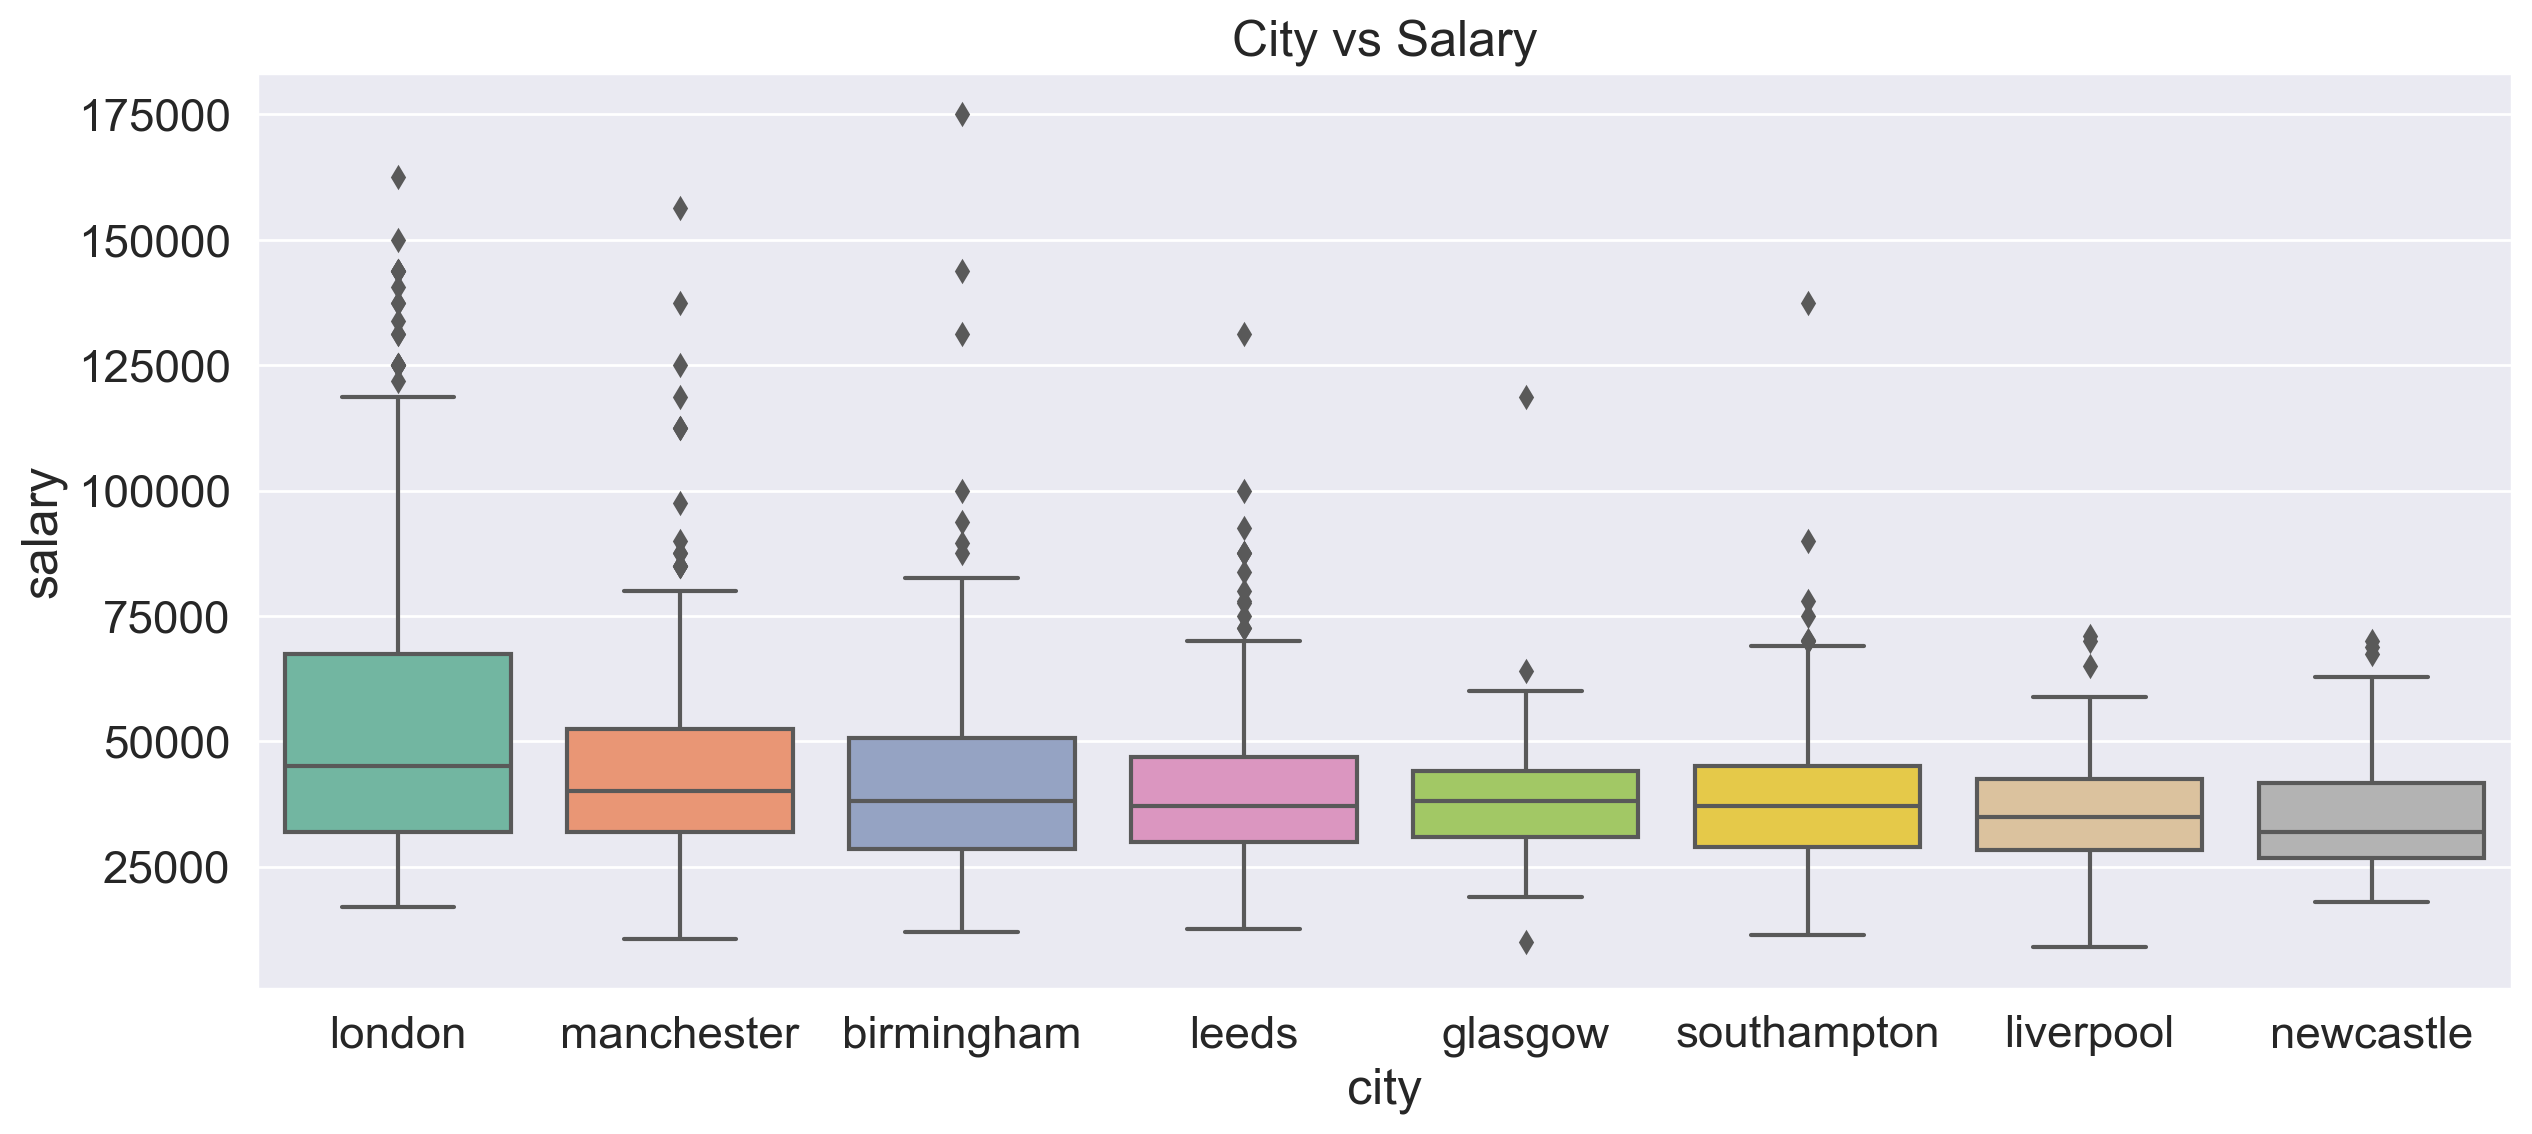

In [3]:
fig2, ax = plt.subplots(nrows=1,ncols=1,figsize=(13,6))
sns.boxplot(x = df_final.city, y = df_final.salary,  data = df_final, ax=ax)
ax.set_title('City vs Salary')
fig2.tight_layout()
plt.show()
#pickle.dump(fig2, open('fig2.png', 'wb')) #saving fig
fig2.savefig("fig2.png")

Boxplot shows that London and Newcastle have the highest and lowest average paid salaries respectively. Expect that both will give the largest coefficients for a simple logisitical regression model on just city as a feature, for each class, 'high' and 'low' respectively.

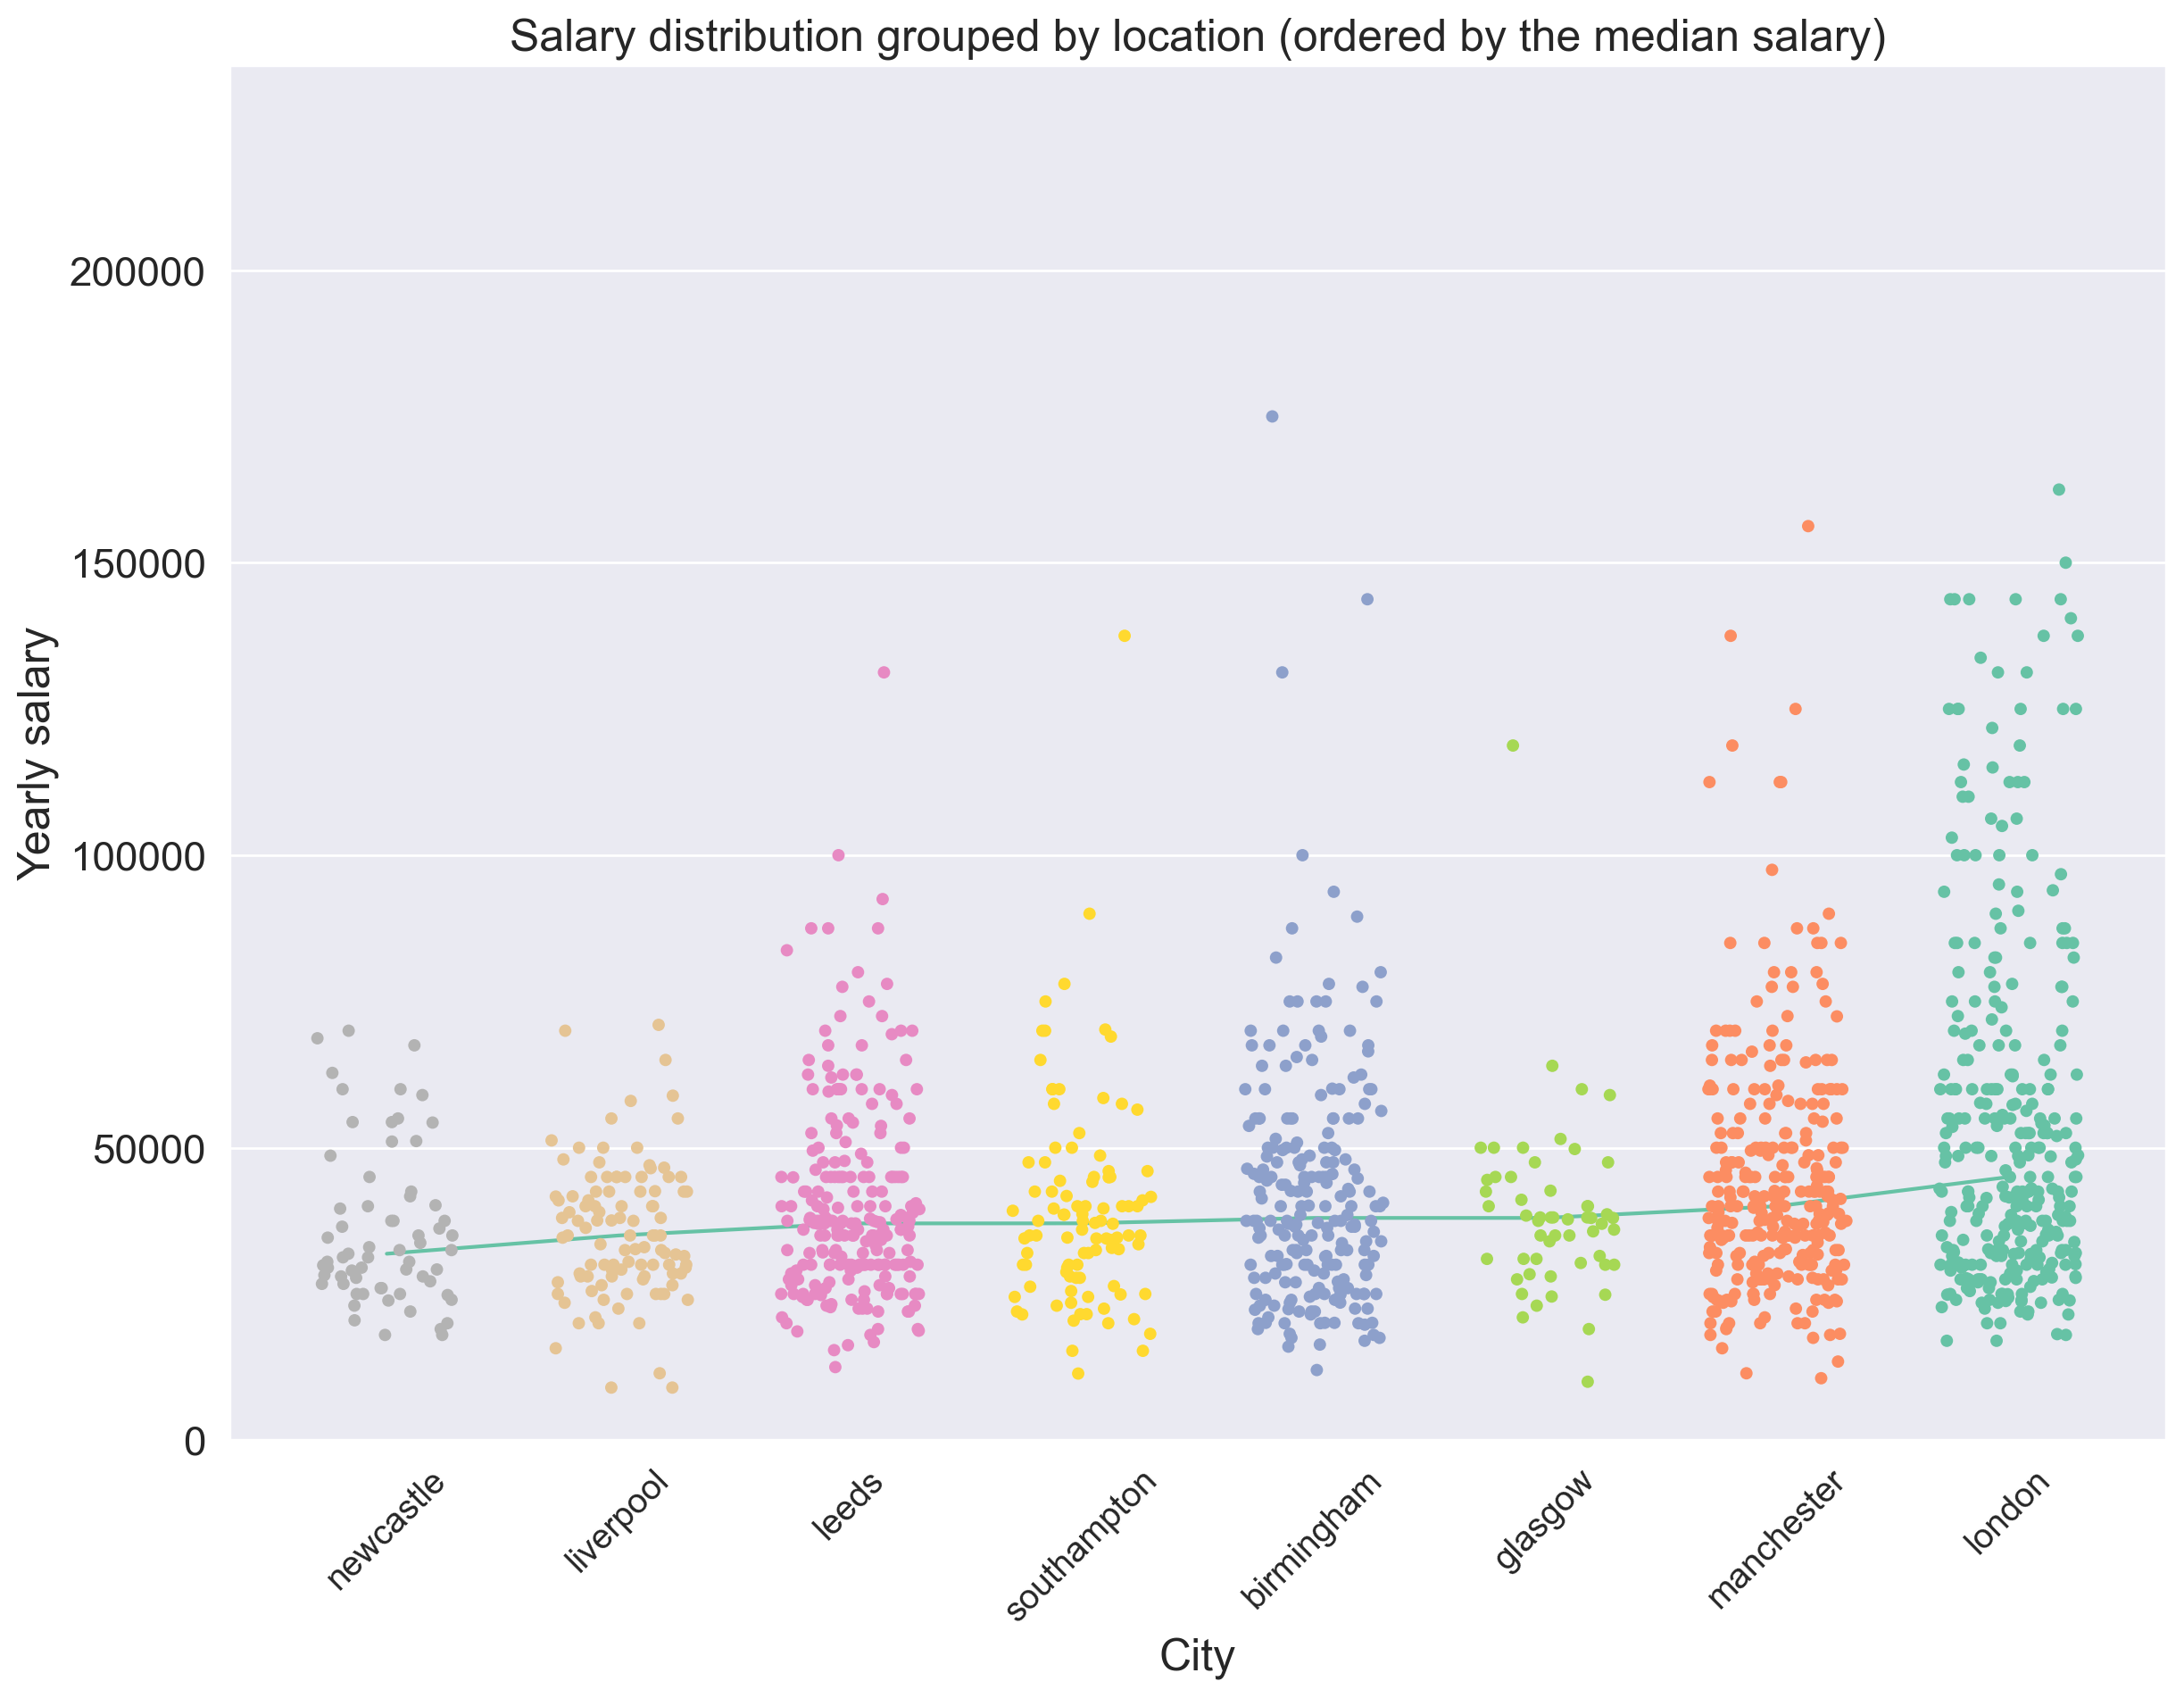

In [4]:
plot_order = list(df_final.groupby(by='city').median().salary.sort_values().index)
fig3, ax = plt.subplots(figsize=(14, 10))
sns.stripplot(data=df_final, x='city', y='salary', order = plot_order, hue='city',jitter=0.3 ,legend = False)
sns.lineplot(y=df_final.groupby('city').salary.median().sort_values(),
             x=df_final.groupby('city').salary.median().sort_values().index)
plt.xticks(rotation=45, fontsize=14)
plt.ylim(0,235000)
plt.xlabel('City')
plt.ylabel('Yearly salary')
plt.title('Salary distribution grouped by location (ordered by the median salary)')
plt.show()
#pickle.dump(fig3, open('fig3.png', 'wb'))
fig3.savefig("fig3.png")

The plot of salary distribution by city, ordered by the median salary (shown by the line). Can see that London has the largest number of data points and the highest median salary. Seems that city should be a reasonable predictor for salary

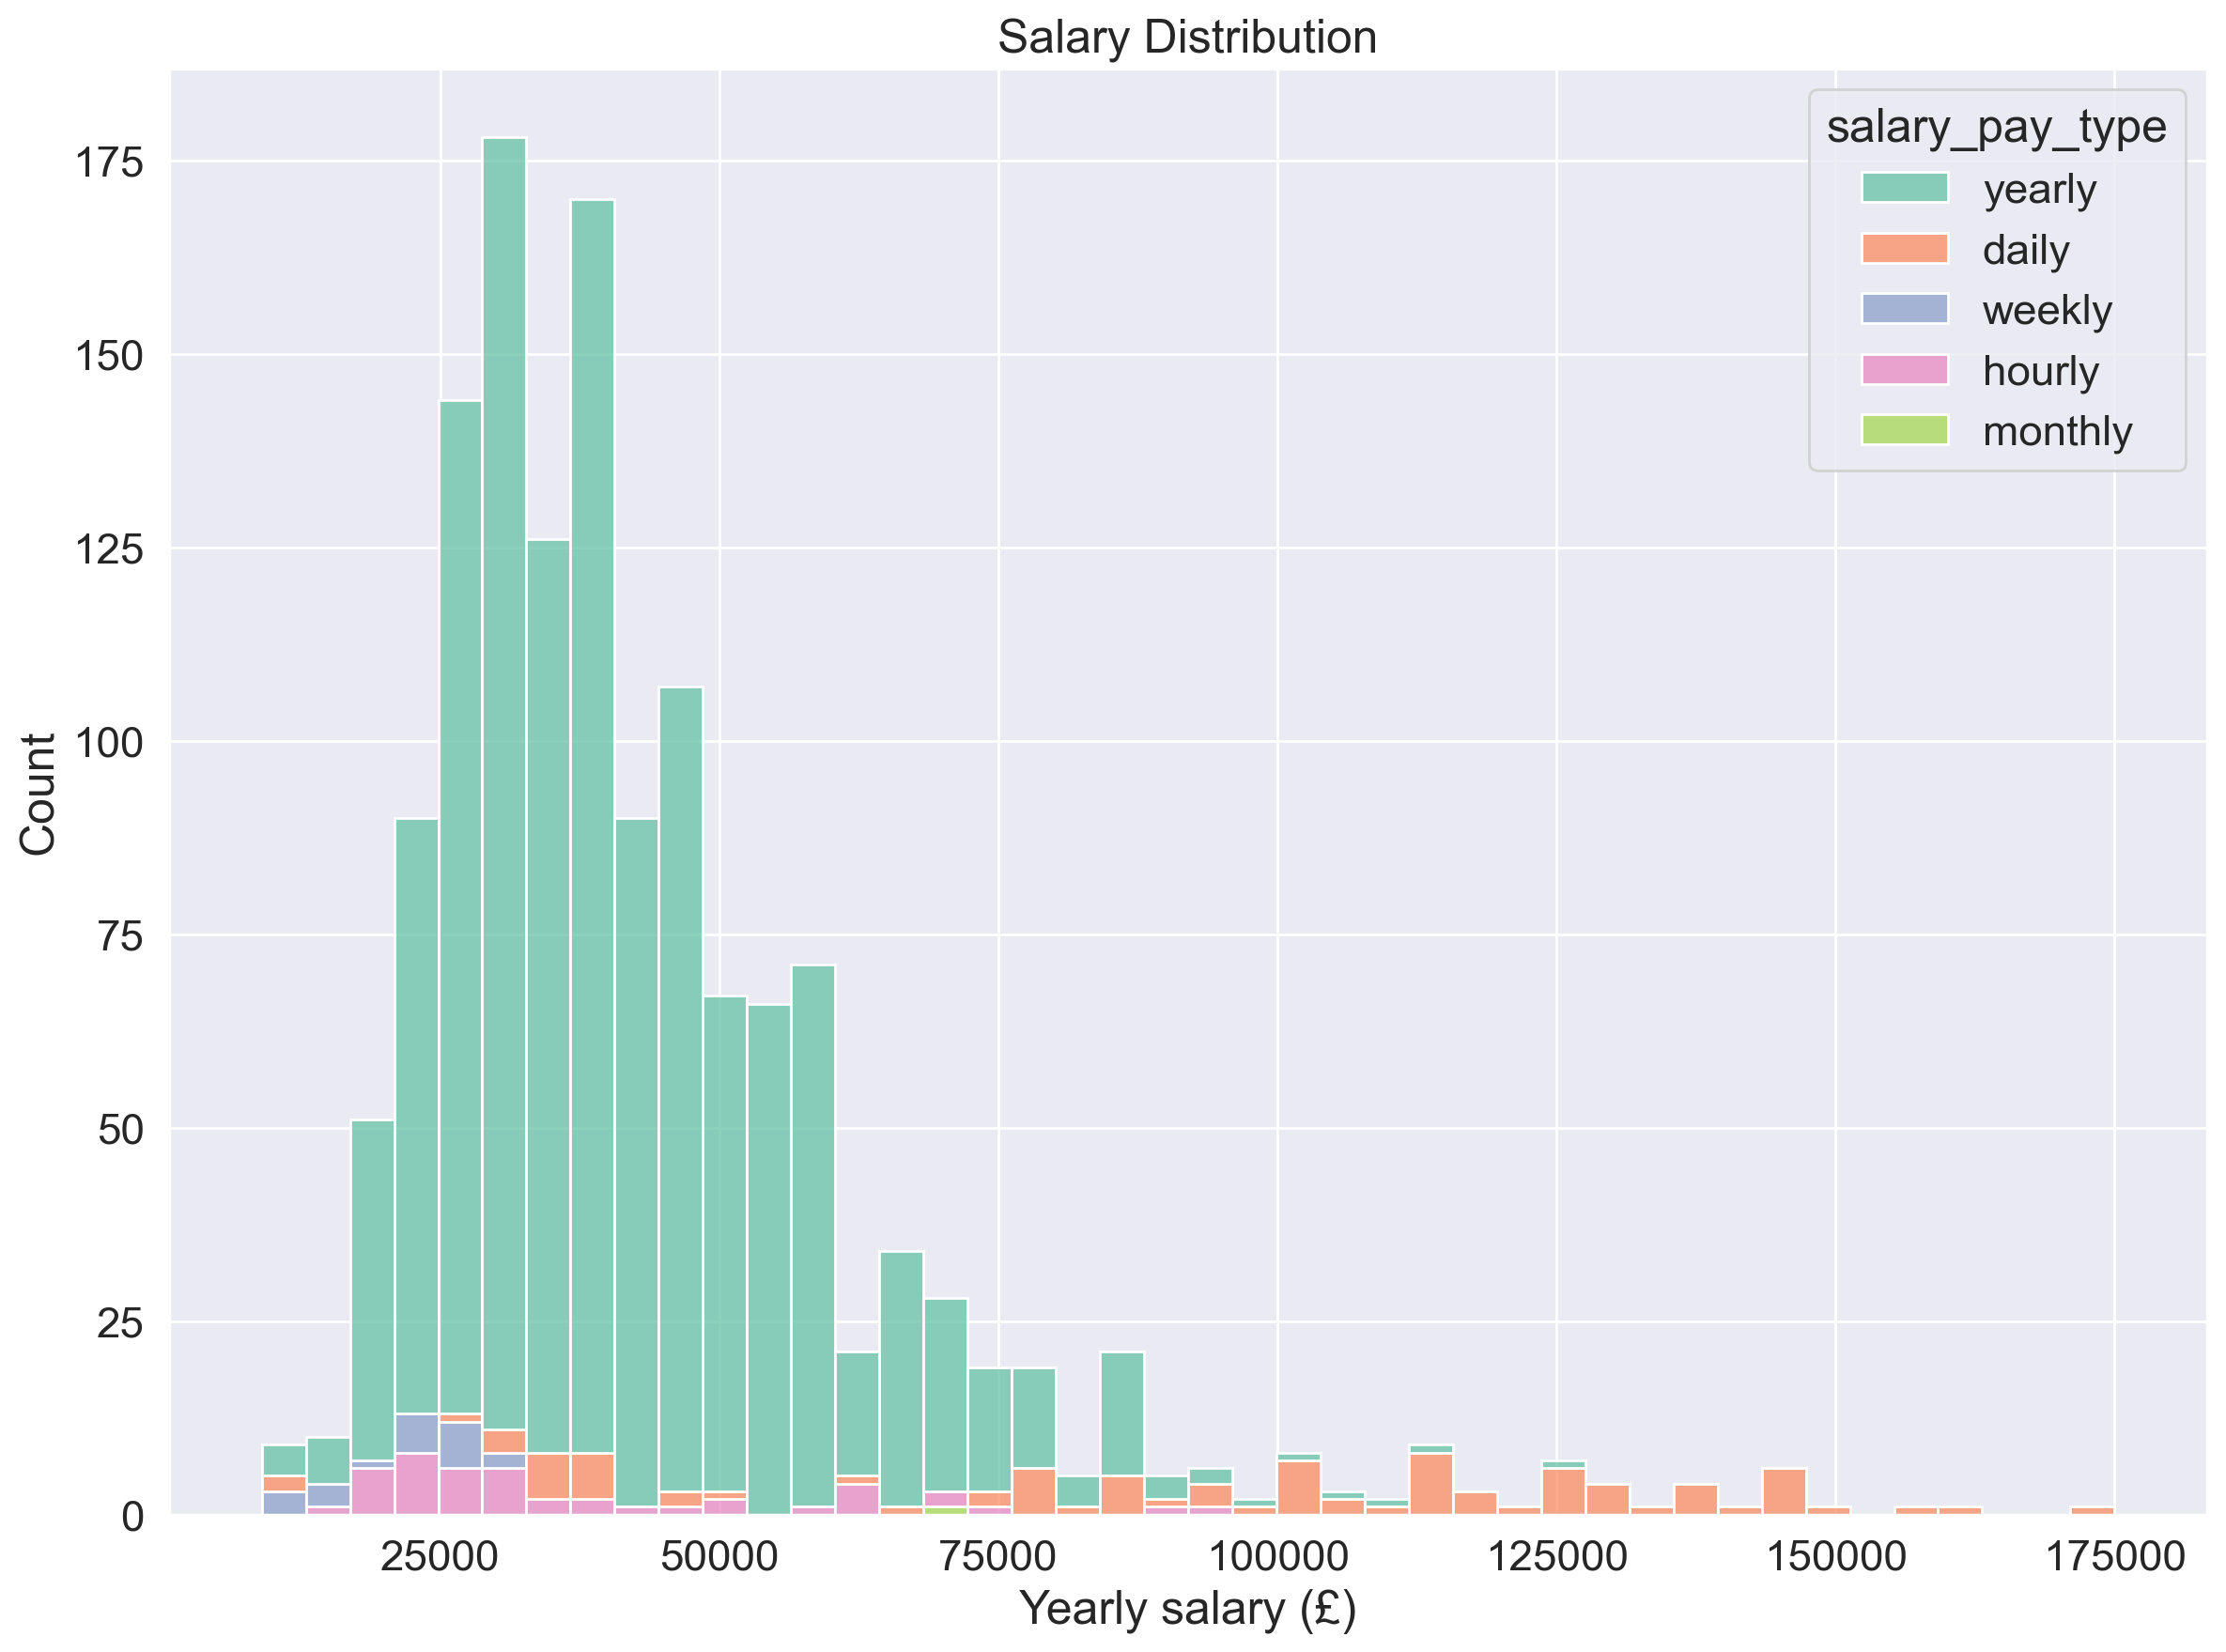

In [5]:
fig1, ax = plt.subplots(figsize=(14, 10))
sns.histplot(df_final, x='salary', ax=ax, hue='salary_pay_type', multiple='stack', 
             hue_order=['yearly','daily','weekly','hourly','monthly'])
ax.set_xlabel('Yearly salary (£)')
ax.set_ylabel('Count')
ax.set_title('Salary Distribution')
plt.show()
#pickle.dump(fig1, open('fig1.png', 'wb'))
fig1.savefig("fig1.png")

Chart shows the distribution of the yearly salary for the different categories of a quoted salary. For example a salary quoted as a daily rate is converted to a yearly salary as with others to be able to compare.

Can see that the distribution is positively skewed showing that most salaries are at the lower end with a long tail of higher yearly salaries.

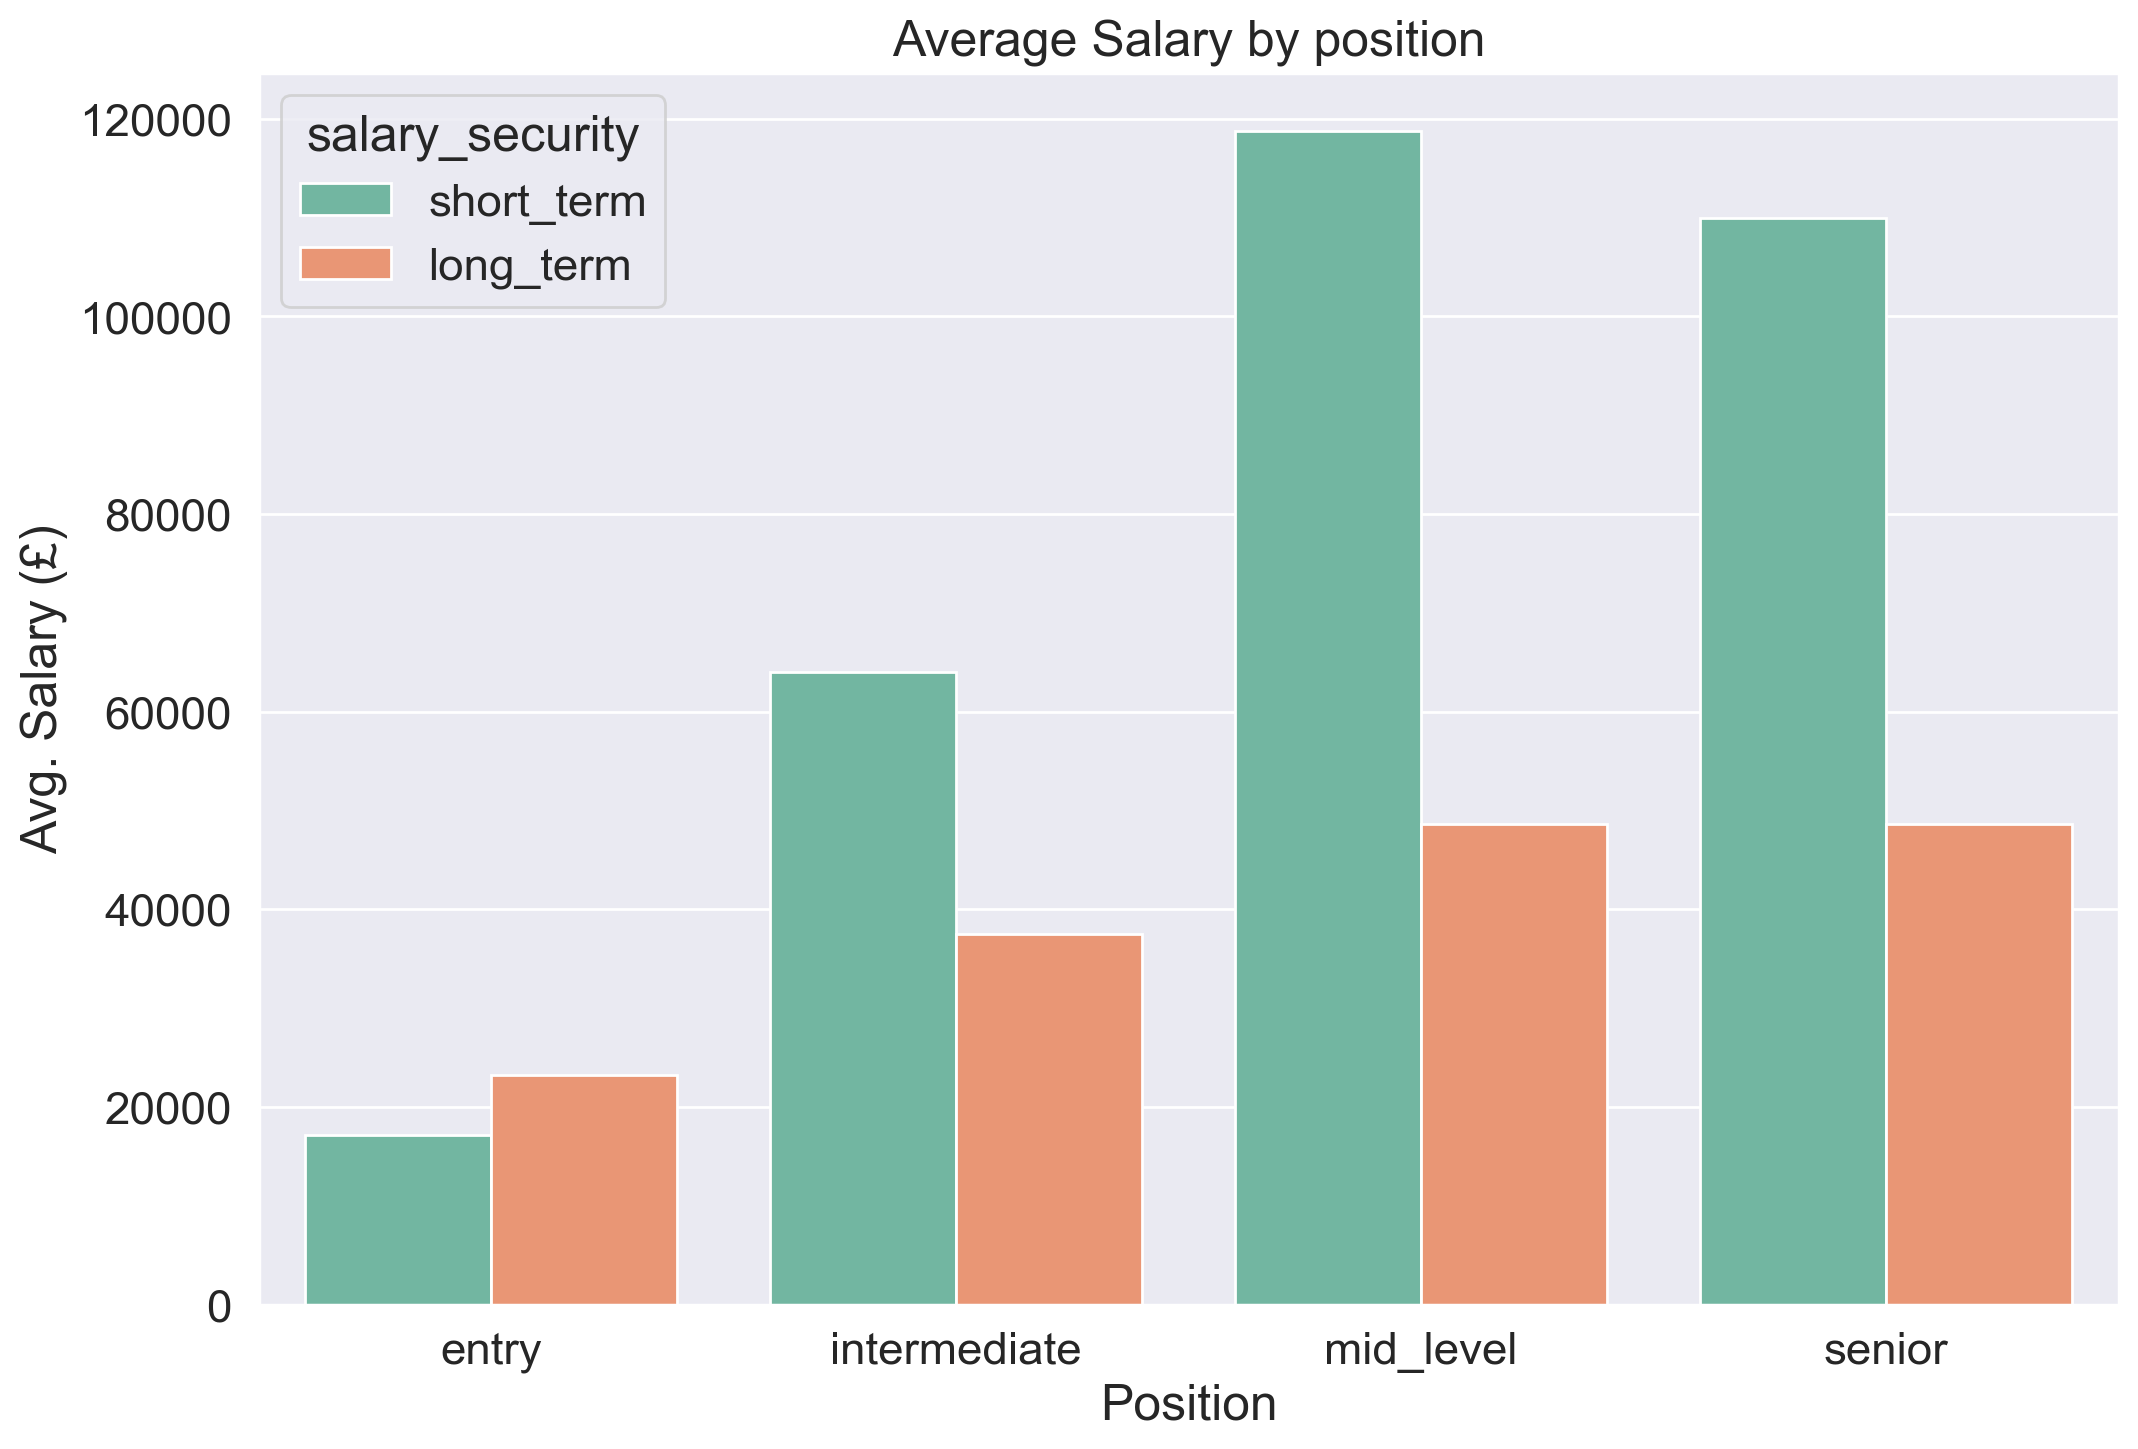

In [6]:
fig4, ax = plt.subplots(figsize=(12, 8))
sns.barplot(df_final,y='salary', x='position_level', estimator='median',hue='salary_security',ax=ax,orient='v',
           order =['entry','intermediate','mid_level','senior'],errorbar=None)
ax.set_xlabel('Position'),
ax.set_ylabel('Avg. Salary (£)')
ax.set_title('Average Salary by position')
plt.show()
#pickle.dump(fig4, open('fig4.png', 'wb'))
fig4.savefig("fig4.png")

Bar plot shows the average yearly salary for different job positions and for salary security type (long term security vs short term). The plot shows that gnerally shorter term security is higher paid vs long term. Annual salary scales as expected with increasing position apart from mid level (could point to inaccurately choosing list of words categorising a mid level position instead of senior position)

## Modelling 

Salary will be the target variable. We will treat this as a classification problem to help remove some of the noise of the extreme salaries. This will be a binary classification problem - High salary (0) or Low salary (1). The split has already been done on the Median to so that have a balanced dataset. Baseline accuracy should be aroumd 50%.

Starting with only using location as a predictor.

In [7]:
from sklearn import datasets, metrics
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, plot_confusion_matrix, plot_roc_curve, plot_precision_recall_curve, roc_auc_score, average_precision_score
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, average_precision_score, plot_roc_curve, plot_precision_recall_curve, auc

In [8]:
# BASELINE ACCURACY
df_final.salary_level.value_counts(normalize=True, sort=True)

low     0.5
high    0.5
Name: salary_level, dtype: float64

**With Pipeline**

- One hot encoder
- standardscaler

In [9]:
df_final.head(2)

jobtitle                  company   salary  \
0  Data Comms Engineer/ Data Cable Engineer  Installation Technology  30000.0   
1                         Big Data Engineer          The App Experts  32500.0   

          location    city salary_pay_type salary_security position_level  \
0  London WC2R 2LS  london           daily      short_term   intermediate   
1           London  london          yearly       long_term   intermediate   

  salary_level  
0          low  
1          low

In [10]:
X = df_final
y = df_final.salary_level

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify = y, random_state=1, shuffle=True)

In [12]:
scaler = StandardScaler()

col_trans = ColumnTransformer(transformers=[('categories', OneHotEncoder(drop ='first', sparse=False), 
                                             ['city'])], remainder='drop',sparse_threshold=0)

pipe1 = Pipeline(steps=[('col_trans', col_trans),('scaler', scaler)])

In [13]:
X1_train = pipe1.fit_transform(X_train)
X1_test = pipe1.transform(X_test)

### Logistic Regression 1

In [19]:
model_logreg = LogisticRegression(max_iter=10000)
model_logreg.fit(X1_train, y_train)

LogisticRegression(max_iter=10000)

In [20]:
cv_score = cross_val_score(model_logreg, X1_train, y_train)
print("CV scores:", cv_score)
print("mean CV Score:",round(cv_score.mean(),4))
print("test score:", round(model_logreg.score(X1_test, y_test),4))

CV scores: [0.54871795 0.57948718 0.57435897 0.55897436 0.55154639]
mean CV Score: 0.5626
test score: 0.5766


In [21]:
#obtaining feature names which have been dummified by OneHotEncoder and their appropriate order
feature_names = pipe1['col_trans'].transformers_[0][1].get_feature_names_out(['city'])
feature_names

array(['city_glasgow', 'city_leeds', 'city_liverpool', 'city_london',
       'city_manchester', 'city_newcastle', 'city_southampton'],
      dtype=object)

In [22]:
mode_logreg2 = LogisticRegression(max_iter=10000)

params = {'penalty': ['l1', 'l2'],
          'solver': ['saga'],
          'fit_intercept': [True, False],
          'C': np.logspace(-5, 1, 50)}

logreg_gs = GridSearchCV(mode_logreg2, params, cv=5, n_jobs=-2, verbose=3)

logreg_gs.fit(X1_train, y_train)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
[CV 1/5] END C=1e-05, fit_intercept=True, penalty=l2, solver=saga;, score=nan total time=   0.0s
[CV 4/5] END C=1.3257113655901082e-05, fit_intercept=False, penalty=l2, solver=saga;, score=nan total time=   0.0s
[CV 4/5] END C=1.757510624854793e-05, fit_intercept=True, penalty=l1, solver=saga;, score=nan total time=   0.0s
[CV 5/5] END C=1.757510624854793e-05, fit_intercept=True, penalty=l2, solver=saga;, score=nan total time=   0.0s
[CV 2/5] END C=1.757510624854793e-05, fit_intercept=False, penalty=l1, solver=saga;, score=nan total time=   0.0s
[CV 4/5] END C=1.757510624854793e-05, fit_intercept=False, penalty=l1, solver=saga;, score=nan total time=   0.0s
[CV 1/5] END C=1.757510624854793e-05, fit_intercept=False, penalty=l2, solver=saga;, score=nan total time=   0.0s
[CV 3/5] END C=1.757510624854793e-05, fit_intercept=False, penalty=l2, solver=saga;, score=nan total time=   0.0s
[CV 3/5] END C=2.3299518105153718e-05, fit

[CV 1/5] END C=5.689866029018293, fit_intercept=True, penalty=l1, solver=saga;, score=nan total time=   0.0s[CV 5/5] END C=1e-05, fit_intercept=True, penalty=l1, solver=saga;, score=nan total time=   0.0s
[CV 5/5] END C=1.757510624854793e-05, fit_intercept=False, penalty=l1, solver=saga;, score=nan total time=   0.0s
[CV 2/5] END C=2.3299518105153718e-05, fit_intercept=True, penalty=l2, solver=saga;, score=nan total time=   0.0s
[CV 1/5] END C=2.3299518105153718e-05, fit_intercept=False, penalty=l2, solver=saga;, score=nan total time=   0.0s
[CV 1/5] END C=0.0006866488450042998, fit_intercept=False, penalty=l1, solver=saga;, score=nan total time=   0.0s
[CV 2/5] END C=0.0006866488450042998, fit_intercept=False, penalty=l1, solver=saga;, score=nan total time=   0.0s
[CV 3/5] END C=0.0006866488450042998, fit_intercept=False, penalty=l1, solver=saga;, score=nan total time=   0.0s
[CV 4/5] END C=0.0006866488450042998, fit_intercept=False, penalty=l1, solver=saga;, score=nan total time=   0

[CV 5/5] END C=1.757510624854793e-05, fit_intercept=True, penalty=l2, solver=saga;, score=0.552 total time=   0.0s[CV 3/5] END C=1e-05, fit_intercept=True, penalty=l2, solver=saga;, score=nan total time=   0.0s
[CV 2/5] END C=1e-05, fit_intercept=False, penalty=l2, solver=saga;, score=nan total time=   0.0s
[CV 3/5] END C=5.4286754393238594e-05, fit_intercept=True, penalty=l1, solver=saga;, score=nan total time=   0.0s
[CV 4/5] END C=5.4286754393238594e-05, fit_intercept=True, penalty=l1, solver=saga;, score=nan total time=   0.0s
[CV 1/5] END C=0.00022229964825261955, fit_intercept=False, penalty=l1, solver=saga;, score=nan total time=   0.0s
[CV 2/5] END C=0.00022229964825261955, fit_intercept=False, penalty=l1, solver=saga;, score=nan total time=   0.0s
[CV 3/5] END C=0.00022229964825261955, fit_intercept=False, penalty=l1, solver=saga;, score=nan total time=   0.0s
[CV 4/5] END C=0.00022229964825261955, fit_intercept=False, penalty=l1, solver=saga;, score=nan total time=   0.0s
[CV

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=10000), n_jobs=-2,
             param_grid={'C': array([1.00000000e-05, 1.32571137e-05, 1.75751062e-05, 2.32995181e-05,
       3.08884360e-05, 4.09491506e-05, 5.42867544e-05, 7.19685673e-05,
       9.54095476e-05, 1.26485522e-04, 1.67683294e-04, 2.22299648e-04,
       2.94705170e-04, 3.90693994e-04, 5.17947468e-04, 6.86648845e-04,
       9.10298178e-04...
       8.28642773e-02, 1.09854114e-01, 1.45634848e-01, 1.93069773e-01,
       2.55954792e-01, 3.39322177e-01, 4.49843267e-01, 5.96362332e-01,
       7.90604321e-01, 1.04811313e+00, 1.38949549e+00, 1.84206997e+00,
       2.44205309e+00, 3.23745754e+00, 4.29193426e+00, 5.68986603e+00,
       7.54312006e+00, 1.00000000e+01]),
                         'fit_intercept': [True, False],
                         'penalty': ['l1', 'l2'], 'solver': ['saga']},
             verbose=3)

In [23]:
logreg_best = logreg_gs.best_estimator_

print('Best parameters:',logreg_gs.best_params_)
print('Best estimator C:',logreg_gs.best_estimator_.C)
print('Best estimator mean cross-validated training score:',logreg_gs.best_score_)
print('Best estimator score on the full training set:',logreg_gs.score(X1_train, y_train))
print('Best estimator score on the test set:',logreg_gs.score(X1_test, y_test))

Best parameters: {'C': 1e-05, 'fit_intercept': False, 'penalty': 'l2', 'solver': 'saga'}
Best estimator C: 1e-05
Best estimator mean cross-validated training score: 0.5708643933386202
Best estimator score on the full training set: 0.5708418891170431
Best estimator score on the test set: 0.5765550239234449


In [24]:
logreg_gs.best_estimator_.coef_

array([[ 2.06024988e-04,  3.49854392e-04,  2.81521986e-04,
        -7.04180325e-04, -1.08647805e-04,  3.68664876e-04,
         8.16498735e-05]])

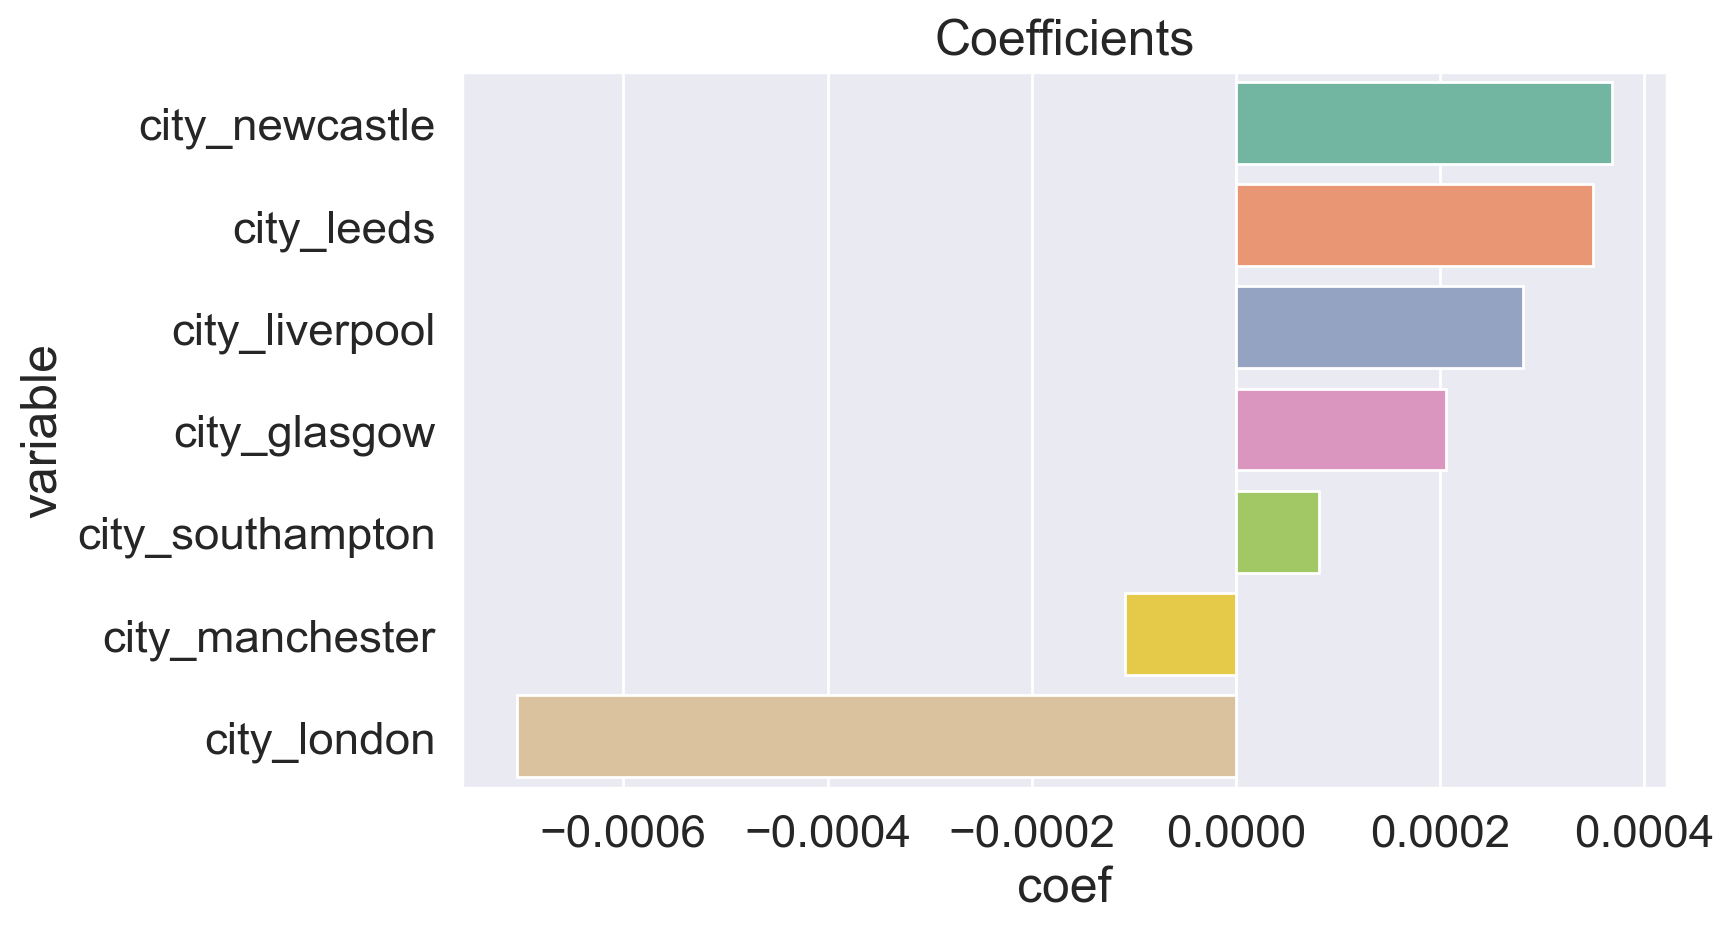

In [25]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=((9,5)))
coefs_vars_logreg = pd.DataFrame({'coef': logreg_gs.best_estimator_.coef_[0],
                                  'variable': feature_names,
                                  'abscoef': np.abs(logreg_gs.best_estimator_.coef_[0])})

coefs_vars_logreg.sort_values('coef', ascending=False, inplace=True)
#coefs_vars_logreg.plot(kind='barh', x='variable', y='coef',color='b', label='LogReg',ax=ax)
sns.barplot(data = coefs_vars_logreg, x = 'coef',y='variable')
ax.set_title('Coefficients')
fig.tight_layout()
plt.show()

In [26]:
print("Coefficients:",logreg_gs.best_estimator_.coef_[0])
print("Class order:",logreg_gs.best_estimator_.classes_)

Coefficients: [ 2.06024988e-04  3.49854392e-04  2.81521986e-04 -7.04180325e-04
 -1.08647805e-04  3.68664876e-04  8.16498735e-05]
Class order: ['high' 'low']


This means negative cofficient is associated with the 0 class, i.e 'high' and positive for class 1 i.e 'low'.

From this coefficient graph we see that London and Newcastle have coefficients that are in the direction of the 'high' class with London being the largest coefficient in this direction. Whereas, the rest of the cities lean towards being in the 'low' class, i.e jobs with 'low' salaries. Newcastle is the city which has the highest odds to land a 'low' salary and London having the highest odds of landing a 'high' salary within data science related jobs.

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


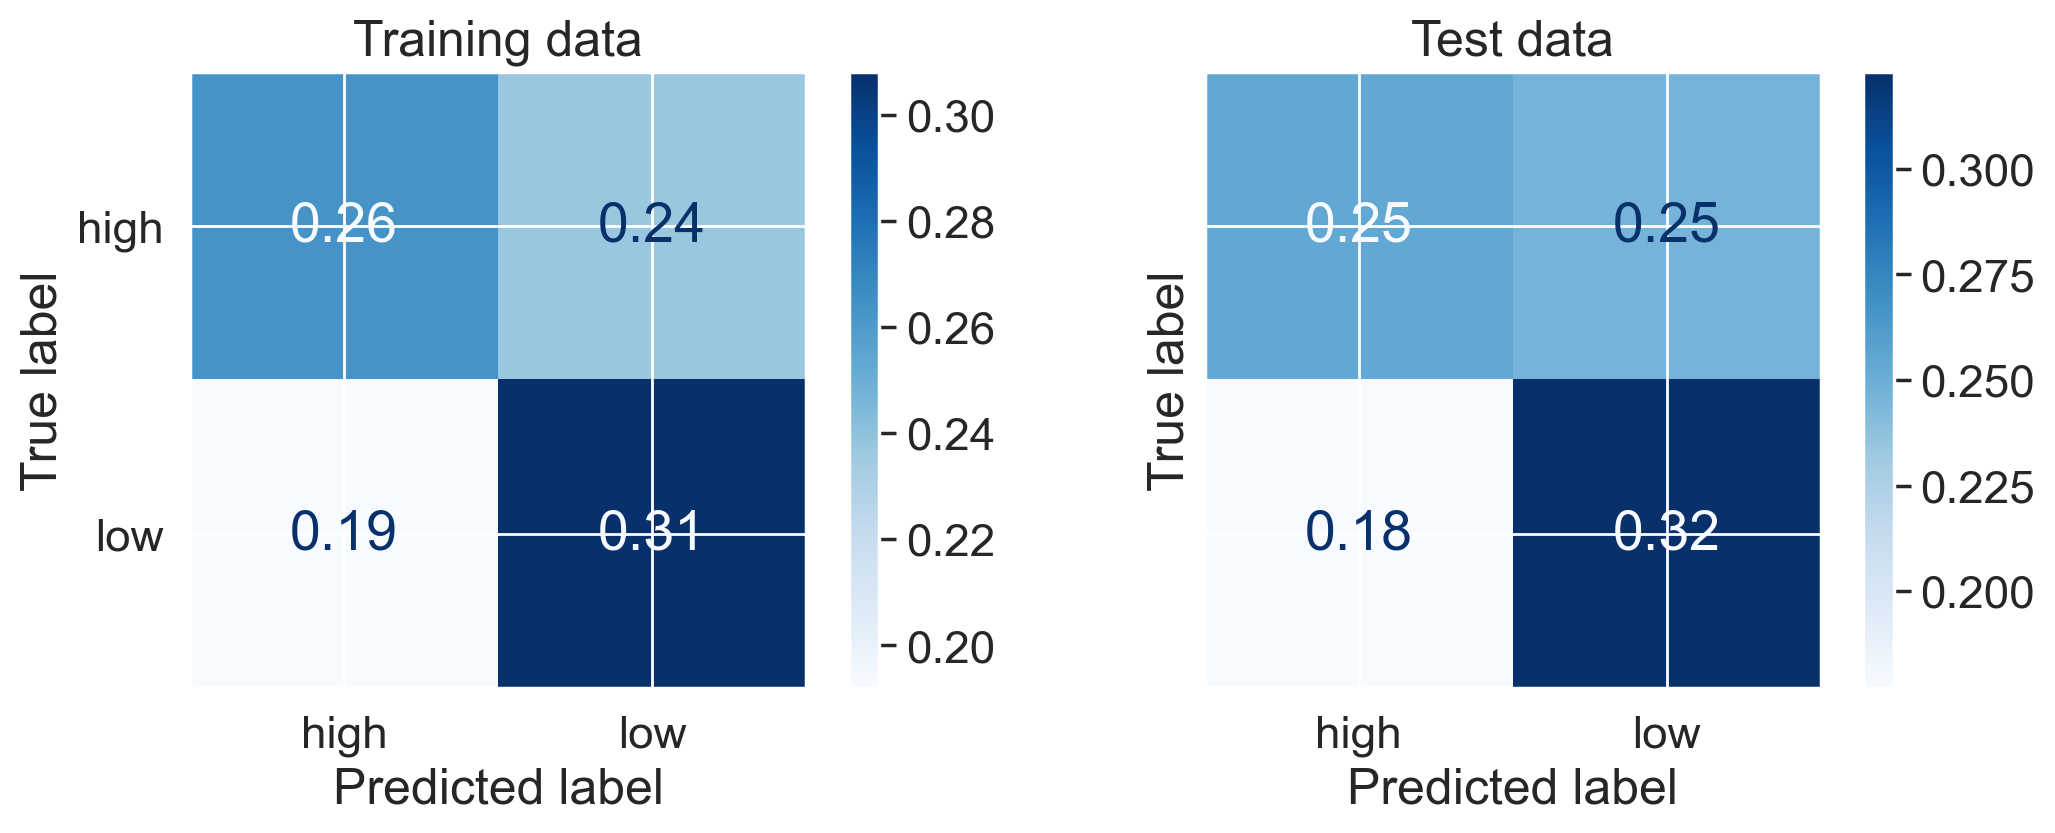

In [27]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 4), sharey=True)
plot_confusion_matrix(logreg_best, X1_train, y_train, cmap='Blues', ax=ax[0], normalize='all')
plot_confusion_matrix(logreg_best, X1_test, y_test, cmap='Blues', ax=ax[1], normalize='all')

ax[0].set_title('Training data')
ax[1].set_title('Test data')

for a in ax:
    texts = a.texts
    for text in texts:
        text.set_size(20)

plt.show()

### Randomforest

In [28]:
model_randFor = RandomForestClassifier(criterion='gini', n_estimators=500, 
                                       min_samples_leaf=1, max_depth= 1.0, random_state=1)
model_randFor.fit(X1_train, y_train)

RandomForestClassifier(max_depth=1.0, n_estimators=500, random_state=1)

In [29]:
cv_score = cross_val_score(model_randFor,X1_train, y_train)
print("CV scores:", cv_score)
print("mean CV Score:",round(cv_score.mean(),4))
print("test score:", round(model_randFor.score(X1_test, y_test),4))

CV scores: [0.52820513 0.54871795 0.57435897 0.54871795 0.59278351]
mean CV Score: 0.5586
test score: 0.5359


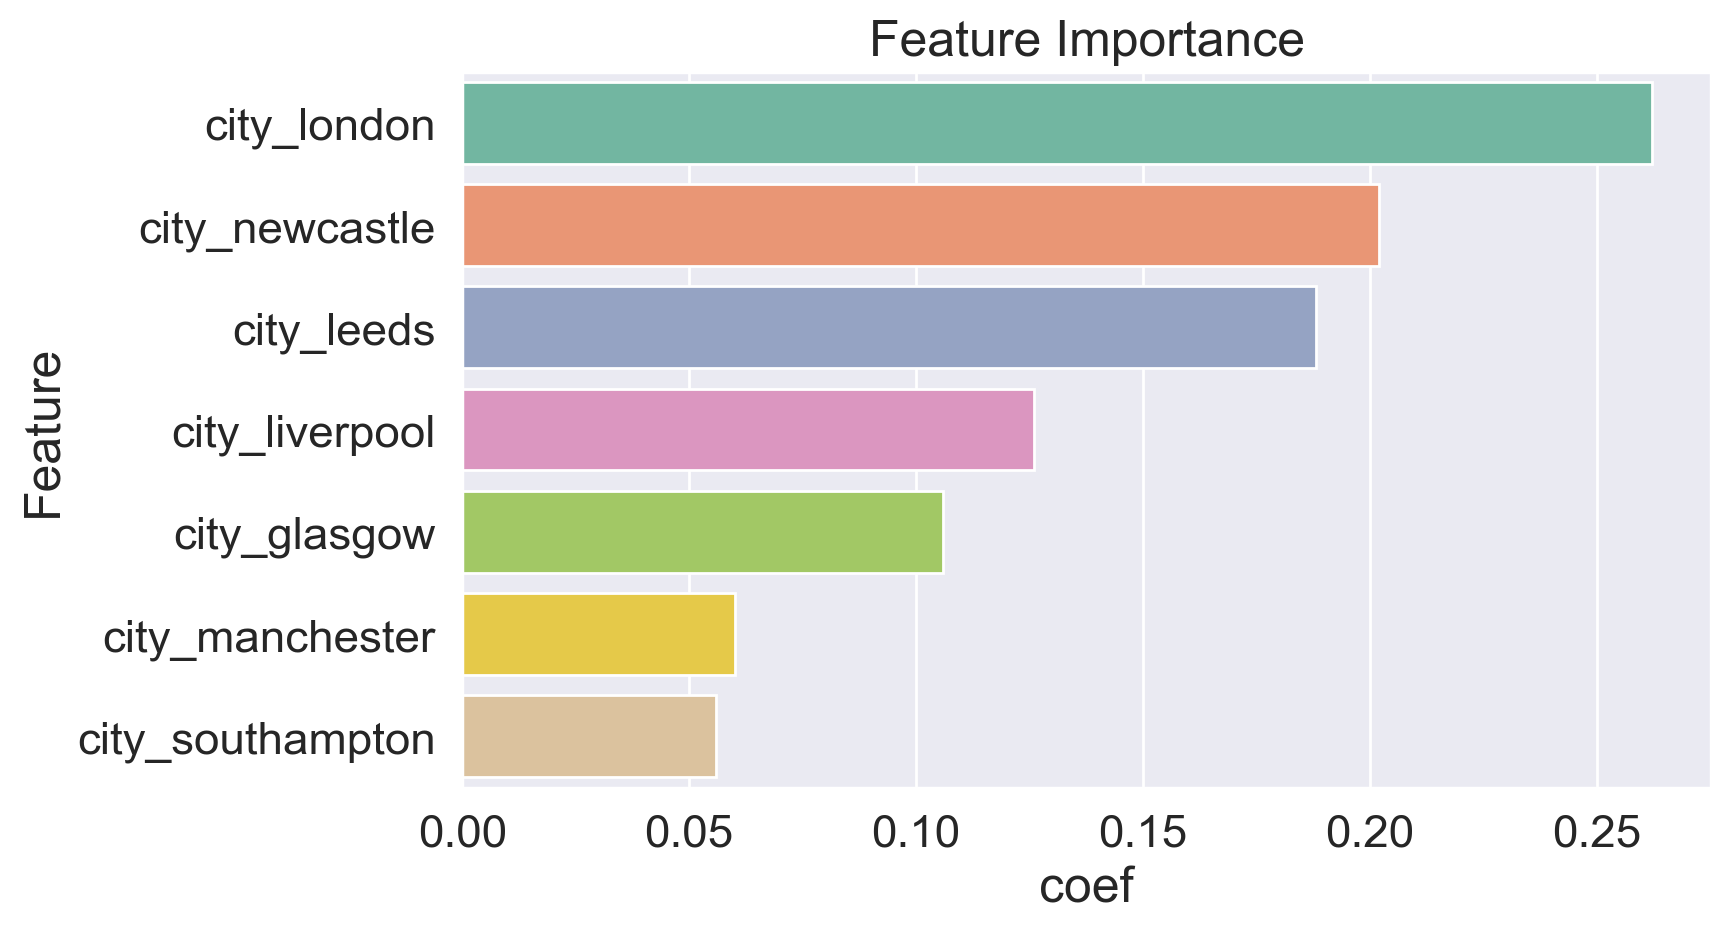

In [30]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(9,5))
df_randfor = pd.DataFrame({'variable': feature_names,'coef':model_randFor.feature_importances_}).sort_values(by='coef', ascending=False)#.plot(kind='barh', x=0, y=1, label='RandomForest', ax=ax)
sns.barplot(data = df_randfor, x='coef',y='variable')
ax.set_title('Feature Importance')
ax.set_ylabel('Feature')
fig.tight_layout()
plt.show()

### Random Forest GS

In [31]:
randFor_params = {'max_depth': [1,2,3,4,None],  #for 7 features above 5 is pointless
                  'max_features': [0.2,0.3,0.5,0.7,0.9,1.0],  #for random forest class you never want 100% of features
                  'max_leaf_nodes': [10,50,100,200, None],          #as each estimator would ask the same question
                  'criterion' : ['entropy'],                   #want to maximise variance and avg out to lower this later
                  'n_estimators' :[100,300,400],  ##never have less than 100 
                  'ccp_alpha':[0.0,0.1,0.2]}

cvSKF=StratifiedKFold(n_splits=5, random_state=1, shuffle=True)
model_randFor = RandomForestClassifier()
randFor_gs = GridSearchCV(model_randFor, randFor_params, cv=cvSKF, verbose=2, n_jobs=-2)

In [32]:
randFor_gs.fit(X1_train, y_train)

Fitting 5 folds for each of 1350 candidates, totalling 6750 fits
[CV 3/5] END C=1e-05, fit_intercept=True, penalty=l1, solver=saga;, score=nan total time=   0.0s
[CV 3/5] END C=1.757510624854793e-05, fit_intercept=False, penalty=l1, solver=saga;, score=nan total time=   0.0s
[CV 1/5] END C=3.0888435964774785e-05, fit_intercept=True, penalty=l2, solver=saga;, score=nan total time=   0.0s
[CV 3/5] END C=3.0888435964774785e-05, fit_intercept=True, penalty=l2, solver=saga;, score=nan total time=   0.0s
[CV 5/5] END C=3.0888435964774785e-05, fit_intercept=True, penalty=l2, solver=saga;, score=nan total time=   0.0s
[CV 3/5] END C=3.0888435964774785e-05, fit_intercept=False, penalty=l1, solver=saga;, score=nan total time=   0.0s
[CV 4/5] END C=3.0888435964774785e-05, fit_intercept=False, penalty=l1, solver=saga;, score=nan total time=   0.0s
[CV 4/5] END C=3.0888435964774785e-05, fit_intercept=False, penalty=l2, solver=saga;, score=nan total time=   0.0s
[CV 5/5] END C=3.0888435964774785e-05

[CV 5/5] END C=0.0009102981779915217, fit_intercept=False, penalty=l1, solver=saga;, score=0.500 total time=   0.0s[CV 2/5] END C=1e-05, fit_intercept=True, penalty=l1, solver=saga;, score=nan total time=   0.0s
[CV 4/5] END C=1e-05, fit_intercept=False, penalty=l2, solver=saga;, score=nan total time=   0.0s
[CV 1/5] END C=1.3257113655901082e-05, fit_intercept=True, penalty=l1, solver=saga;, score=nan total time=   0.0s
[CV 3/5] END C=1.3257113655901082e-05, fit_intercept=True, penalty=l1, solver=saga;, score=nan total time=   0.0s
[CV 5/5] END C=1.3257113655901082e-05, fit_intercept=True, penalty=l1, solver=saga;, score=nan total time=   0.0s
[CV 3/5] END C=1.3257113655901082e-05, fit_intercept=False, penalty=l2, solver=saga;, score=nan total time=   0.0s
[CV 5/5] END C=1.3257113655901082e-05, fit_intercept=False, penalty=l2, solver=saga;, score=nan total time=   0.0s
[CV 5/5] END C=1.757510624854793e-05, fit_intercept=True, penalty=l1, solver=saga;, score=nan total time=   0.0s
[CV 2

[CV 4/5] END C=0.00012648552168552957, fit_intercept=True, penalty=l2, solver=saga;, score=0.579 total time=   0.0s[CV 5/5] END C=1e-05, fit_intercept=False, penalty=l1, solver=saga;, score=nan total time=   0.0s
[CV 5/5] END C=1e-05, fit_intercept=False, penalty=l2, solver=saga;, score=nan total time=   0.0s
[CV 4/5] END C=1.3257113655901082e-05, fit_intercept=True, penalty=l1, solver=saga;, score=nan total time=   0.0s
[CV 1/5] END C=1.3257113655901082e-05, fit_intercept=True, penalty=l2, solver=saga;, score=nan total time=   0.0s
[CV 3/5] END C=1.3257113655901082e-05, fit_intercept=True, penalty=l2, solver=saga;, score=nan total time=   0.0s
[CV 5/5] END C=1.3257113655901082e-05, fit_intercept=True, penalty=l2, solver=saga;, score=nan total time=   0.0s
[CV 2/5] END C=1.3257113655901082e-05, fit_intercept=False, penalty=l1, solver=saga;, score=nan total time=   0.0s
[CV 4/5] END C=1.3257113655901082e-05, fit_intercept=False, penalty=l1, solver=saga;, score=nan total time=   0.0s
[CV

[CV 2/5] END C=0.5963623316594636, fit_intercept=True, penalty=l1, solver=saga;, score=nan total time=   0.0s[CV 5/5] END C=1e-05, fit_intercept=True, penalty=l2, solver=saga;, score=nan total time=   0.0s
[CV 2/5] END C=9.540954763499944e-05, fit_intercept=True, penalty=l2, solver=saga;, score=nan total time=   0.0s
[CV 3/5] END C=9.540954763499944e-05, fit_intercept=True, penalty=l2, solver=saga;, score=nan total time=   0.0s
[CV 4/5] END C=9.540954763499944e-05, fit_intercept=True, penalty=l2, solver=saga;, score=nan total time=   0.0s
[CV 5/5] END C=9.540954763499944e-05, fit_intercept=True, penalty=l2, solver=saga;, score=nan total time=   0.0s
[CV 4/5] END C=0.0012067926406393288, fit_intercept=False, penalty=l2, solver=saga;, score=nan total time=   0.0s
[CV 5/5] END C=0.0012067926406393288, fit_intercept=False, penalty=l2, solver=saga;, score=nan total time=   0.0s
[CV 1/5] END C=0.0015998587196060573, fit_intercept=True, penalty=l1, solver=saga;, score=nan total time=   0.0s
[

[CV 4/5] END C=0.00012648552168552957, fit_intercept=True, penalty=l1, solver=saga;, score=0.497 total time=   0.0s
[CV 2/5] END C=0.2559547922699533, fit_intercept=True, penalty=l2, solver=saga;, score=nan total time=   0.0s
[CV 3/5] END C=0.2559547922699533, fit_intercept=True, penalty=l2, solver=saga;, score=nan total time=   0.0s
[CV 4/5] END C=0.2559547922699533, fit_intercept=True, penalty=l2, solver=saga;, score=nan total time=   0.0s
[CV 5/5] END C=0.2559547922699533, fit_intercept=True, penalty=l2, solver=saga;, score=nan total time=   0.0s
[CV 1/5] END C=0.2559547922699533, fit_intercept=False, penalty=l1, solver=saga;, score=nan total time=   0.0s
[CV 2/5] END C=0.2559547922699533, fit_intercept=False, penalty=l1, solver=saga;, score=nan total time=   0.0s
[CV 3/5] END C=0.2559547922699533, fit_intercept=False, penalty=l1, solver=saga;, score=nan total time=   0.0s
[CV 4/5] END C=0.2559547922699533, fit_intercept=False, penalty=l1, solver=saga;, score=nan total time=   0.0s


[CV 1/5] END C=0.0006866488450042998, fit_intercept=True, penalty=l2, solver=saga;, score=0.549 total time=   0.0s
[CV 2/5] END C=5.689866029018293, fit_intercept=True, penalty=l1, solver=saga;, score=nan total time=   0.0s
[CV 2/5] END C=1e-05, fit_intercept=True, penalty=l1, solver=saga;, score=0.497 total time=   0.0s
[CV 1/5] END C=1e-05, fit_intercept=True, penalty=l2, solver=saga;, score=0.497 total time=   0.0s
[CV 3/5] END C=1e-05, fit_intercept=True, penalty=l2, solver=saga;, score=0.497 total time=   0.0s
[CV 1/5] END C=1e-05, fit_intercept=False, penalty=l1, solver=saga;, score=0.503 total time=   0.0s
[CV 4/5] END C=1e-05, fit_intercept=False, penalty=l1, solver=saga;, score=0.497 total time=   0.0s
[CV 2/5] END C=1e-05, fit_intercept=False, penalty=l2, solver=saga;, score=0.579 total time=   0.0s
[CV 2/5] END C=1.3257113655901082e-05, fit_intercept=True, penalty=l1, solver=saga;, score=0.503 total time=   0.0s
[CV 5/5] END C=1.3257113655901082e-05, fit_intercept=True, pena

[CV 2/5] END C=0.03556480306223129, fit_intercept=True, penalty=l1, solver=saga;, score=0.549 total time=   0.0s[CV 4/5] END C=1e-05, fit_intercept=False, penalty=l1, solver=saga;, score=nan total time=   0.0s
[CV 4/5] END C=1.3257113655901082e-05, fit_intercept=True, penalty=l2, solver=saga;, score=nan total time=   0.0s
[CV 2/5] END C=1.3257113655901082e-05, fit_intercept=False, penalty=l2, solver=saga;, score=nan total time=   0.0s
[CV 5/5] END C=5.4286754393238594e-05, fit_intercept=False, penalty=l1, solver=saga;, score=nan total time=   0.0s
[CV 1/5] END C=5.4286754393238594e-05, fit_intercept=False, penalty=l2, solver=saga;, score=nan total time=   0.0s
[CV 1/5] END C=7.196856730011514e-05, fit_intercept=True, penalty=l1, solver=saga;, score=nan total time=   0.0s
[CV 2/5] END C=7.196856730011514e-05, fit_intercept=True, penalty=l1, solver=saga;, score=nan total time=   0.0s
[CV 2/5] END C=7.196856730011514e-05, fit_intercept=True, penalty=l2, solver=saga;, score=nan total time=

[CV 4/5] END C=3.2374575428176398, fit_intercept=False, penalty=l1, solver=saga;, score=nan total time=   0.0s[CV 3/5] END C=1e-05, fit_intercept=False, penalty=l1, solver=saga;, score=nan total time=   0.0s
[CV 2/5] END C=1.757510624854793e-05, fit_intercept=False, penalty=l2, solver=saga;, score=nan total time=   0.0s
[CV 4/5] END C=1.757510624854793e-05, fit_intercept=False, penalty=l2, solver=saga;, score=nan total time=   0.0s
[CV 1/5] END C=2.3299518105153718e-05, fit_intercept=True, penalty=l1, solver=saga;, score=nan total time=   0.0s
[CV 2/5] END C=5.4286754393238594e-05, fit_intercept=True, penalty=l2, solver=saga;, score=nan total time=   0.0s
[CV 3/5] END C=5.4286754393238594e-05, fit_intercept=True, penalty=l2, solver=saga;, score=nan total time=   0.0s
[CV 3/5] END C=5.4286754393238594e-05, fit_intercept=False, penalty=l1, solver=saga;, score=nan total time=   0.0s
[CV 4/5] END C=5.4286754393238594e-05, fit_intercept=False, penalty=l1, solver=saga;, score=nan total time=

[CV 1/5] END C=1.8420699693267164, fit_intercept=False, penalty=l2, solver=saga;, score=nan total time=   0.0s
[CV 4/5] END C=3.0888435964774785e-05, fit_intercept=True, penalty=l1, solver=saga;, score=0.497 total time=   0.0s
[CV 1/5] END C=3.0888435964774785e-05, fit_intercept=False, penalty=l1, solver=saga;, score=0.503 total time=   0.0s
[CV 2/5] END C=3.0888435964774785e-05, fit_intercept=False, penalty=l1, solver=saga;, score=0.503 total time=   0.0s
[CV 3/5] END C=3.0888435964774785e-05, fit_intercept=False, penalty=l1, solver=saga;, score=0.497 total time=   0.0s
[CV 4/5] END C=3.0888435964774785e-05, fit_intercept=False, penalty=l1, solver=saga;, score=0.497 total time=   0.0s
[CV 1/5] END C=4.094915062380427e-05, fit_intercept=False, penalty=l1, solver=saga;, score=0.503 total time=   0.0s
[CV 2/5] END C=4.094915062380427e-05, fit_intercept=False, penalty=l1, solver=saga;, score=0.503 total time=   0.0s
[CV 3/5] END C=4.094915062380427e-05, fit_intercept=False, penalty=l1, so

[CV 1/5] END C=0.14563484775012445, fit_intercept=True, penalty=l1, solver=saga;, score=0.528 total time=   0.0s
[CV 1/5] END C=5.4286754393238594e-05, fit_intercept=True, penalty=l2, solver=saga;, score=0.528 total time=   0.0s
[CV 1/5] END C=7.196856730011514e-05, fit_intercept=False, penalty=l1, solver=saga;, score=0.503 total time=   0.0s
[CV 2/5] END C=7.196856730011514e-05, fit_intercept=False, penalty=l1, solver=saga;, score=0.503 total time=   0.0s
[CV 3/5] END C=7.196856730011514e-05, fit_intercept=False, penalty=l1, solver=saga;, score=0.497 total time=   0.0s
[CV 4/5] END C=7.196856730011514e-05, fit_intercept=False, penalty=l1, solver=saga;, score=0.497 total time=   0.0s
[CV 1/5] END C=9.540954763499944e-05, fit_intercept=False, penalty=l1, solver=saga;, score=0.503 total time=   0.0s
[CV 2/5] END C=9.540954763499944e-05, fit_intercept=False, penalty=l1, solver=saga;, score=0.503 total time=   0.0s
[CV 3/5] END C=9.540954763499944e-05, fit_intercept=False, penalty=l1, solv

[CV 3/5] END C=0.10985411419875572, fit_intercept=False, penalty=l1, solver=saga;, score=0.574 total time=   0.0s
[CV 5/5] END C=2.3299518105153718e-05, fit_intercept=True, penalty=l1, solver=saga;, score=0.500 total time=   0.0s
[CV 1/5] END C=2.3299518105153718e-05, fit_intercept=True, penalty=l2, solver=saga;, score=0.528 total time=   0.0s
[CV 5/5] END C=2.3299518105153718e-05, fit_intercept=False, penalty=l1, solver=saga;, score=0.500 total time=   0.0s
[CV 1/5] END C=2.3299518105153718e-05, fit_intercept=False, penalty=l2, solver=saga;, score=0.549 total time=   0.0s
[CV 1/5] END C=3.0888435964774785e-05, fit_intercept=True, penalty=l1, solver=saga;, score=0.497 total time=   0.0s
[CV 2/5] END C=3.0888435964774785e-05, fit_intercept=True, penalty=l1, solver=saga;, score=0.497 total time=   0.0s
[CV 4/5] END C=3.0888435964774785e-05, fit_intercept=True, penalty=l2, solver=saga;, score=0.564 total time=   0.0s
[CV 5/5] END C=3.0888435964774785e-05, fit_intercept=True, penalty=l2, s

[CV 5/5] END C=1.0481131341546852, fit_intercept=True, penalty=l2, solver=saga;, score=0.552 total time=   0.0s[CV 1/5] END C=1e-05, fit_intercept=False, penalty=l1, solver=saga;, score=nan total time=   0.0s
[CV 2/5] END C=3.0888435964774785e-05, fit_intercept=True, penalty=l1, solver=saga;, score=nan total time=   0.0s
[CV 4/5] END C=4.094915062380427e-05, fit_intercept=False, penalty=l2, solver=saga;, score=nan total time=   0.0s
[CV 5/5] END C=4.094915062380427e-05, fit_intercept=False, penalty=l2, solver=saga;, score=nan total time=   0.0s
[CV 5/5] END C=5.4286754393238594e-05, fit_intercept=True, penalty=l1, solver=saga;, score=nan total time=   0.0s
[CV 1/5] END C=5.4286754393238594e-05, fit_intercept=True, penalty=l2, solver=saga;, score=nan total time=   0.0s
[CV 5/5] END C=7.196856730011514e-05, fit_intercept=True, penalty=l1, solver=saga;, score=nan total time=   0.0s
[CV 1/5] END C=7.196856730011514e-05, fit_intercept=True, penalty=l2, solver=saga;, score=nan total time=   

[CV 5/5] END C=0.5963623316594636, fit_intercept=False, penalty=l1, solver=saga;, score=0.552 total time=   0.0s[CV 2/5] END C=1e-05, fit_intercept=False, penalty=l1, solver=saga;, score=nan total time=   0.0s
[CV 3/5] END C=1e-05, fit_intercept=False, penalty=l2, solver=saga;, score=nan total time=   0.0s
[CV 2/5] END C=1.3257113655901082e-05, fit_intercept=True, penalty=l2, solver=saga;, score=nan total time=   0.0s
[CV 3/5] END C=1.3257113655901082e-05, fit_intercept=False, penalty=l1, solver=saga;, score=nan total time=   0.0s
[CV 1/5] END C=2.3299518105153718e-05, fit_intercept=False, penalty=l1, solver=saga;, score=nan total time=   0.0s
[CV 4/5] END C=2.3299518105153718e-05, fit_intercept=False, penalty=l1, solver=saga;, score=nan total time=   0.0s
[CV 4/5] END C=7.196856730011514e-05, fit_intercept=False, penalty=l2, solver=saga;, score=nan total time=   0.0s
[CV 5/5] END C=7.196856730011514e-05, fit_intercept=False, penalty=l2, solver=saga;, score=nan total time=   0.0s
[CV 1

[CV 3/5] END C=5.689866029018293, fit_intercept=False, penalty=l2, solver=saga;, score=nan total time=   0.0s
[CV 2/5] END C=0.0003906939937054617, fit_intercept=False, penalty=l1, solver=saga;, score=0.503 total time=   0.0s
[CV 3/5] END C=0.0003906939937054617, fit_intercept=False, penalty=l1, solver=saga;, score=0.497 total time=   0.0s
[CV 4/5] END C=0.0003906939937054617, fit_intercept=False, penalty=l1, solver=saga;, score=0.497 total time=   0.0s
[CV 2/5] END C=0.0006866488450042998, fit_intercept=True, penalty=l2, solver=saga;, score=0.549 total time=   0.0s
[CV 3/5] END C=0.0006866488450042998, fit_intercept=True, penalty=l2, solver=saga;, score=0.574 total time=   0.0s
[CV 4/5] END C=0.0006866488450042998, fit_intercept=True, penalty=l2, solver=saga;, score=0.559 total time=   0.0s
[CV 5/5] END C=0.0006866488450042998, fit_intercept=True, penalty=l2, solver=saga;, score=0.552 total time=   0.0s
[CV 1/5] END C=0.0006866488450042998, fit_intercept=False, penalty=l1, solver=saga

[CV 2/5] END C=10.0, fit_intercept=True, penalty=l2, solver=saga;, score=0.579 total time=   0.0s
[CV 5/5] END C=0.00012648552168552957, fit_intercept=True, penalty=l2, solver=saga;, score=0.552 total time=   0.0s
[CV 1/5] END C=0.0005179474679231213, fit_intercept=False, penalty=l1, solver=saga;, score=0.503 total time=   0.0s
[CV 2/5] END C=0.0005179474679231213, fit_intercept=False, penalty=l1, solver=saga;, score=0.503 total time=   0.0s
[CV 3/5] END C=0.0005179474679231213, fit_intercept=False, penalty=l1, solver=saga;, score=0.497 total time=   0.0s
[CV 4/5] END C=0.0005179474679231213, fit_intercept=False, penalty=l1, solver=saga;, score=0.497 total time=   0.0s
[CV 5/5] END C=0.0005179474679231213, fit_intercept=False, penalty=l1, solver=saga;, score=0.500 total time=   0.0s
[CV 1/5] END C=0.0005179474679231213, fit_intercept=False, penalty=l2, solver=saga;, score=0.549 total time=   0.0s
[CV 2/5] END C=0.0005179474679231213, fit_intercept=False, penalty=l2, solver=saga;, score

[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=1, max_features=0.3, max_leaf_nodes=100, n_estimators=100; total time=   0.2s
[CV 5/5] END C=7.543120063354607, fit_intercept=False, penalty=l1, solver=saga;, score=nan total time=   0.0s
[CV 1/5] END C=7.543120063354607, fit_intercept=False, penalty=l2, solver=saga;, score=nan total time=   0.0s
[CV 2/5] END C=7.543120063354607, fit_intercept=False, penalty=l2, solver=saga;, score=nan total time=   0.0s
[CV 3/5] END C=7.543120063354607, fit_intercept=False, penalty=l2, solver=saga;, score=nan total time=   0.0s
[CV 4/5] END C=7.543120063354607, fit_intercept=False, penalty=l2, solver=saga;, score=nan total time=   0.0s
[CV 5/5] END C=7.543120063354607, fit_intercept=False, penalty=l2, solver=saga;, score=nan total time=   0.0s
[CV 1/5] END C=10.0, fit_intercept=True, penalty=l1, solver=saga;, score=nan total time=   0.0s
[CV 2/5] END C=10.0, fit_intercept=True, penalty=l1, solver=saga;, score=nan total time=   0.0s
[CV 3/5] END C=10

[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=1, max_features=0.3, max_leaf_nodes=None, n_estimators=300; total time=   0.6s
[CV 5/5] END C=0.00012648552168552957, fit_intercept=True, penalty=l1, solver=saga;, score=0.500 total time=   0.0s
[CV 1/5] END C=0.00012648552168552957, fit_intercept=True, penalty=l2, solver=saga;, score=0.528 total time=   0.0s
[CV 5/5] END C=0.00022229964825261955, fit_intercept=False, penalty=l1, solver=saga;, score=0.500 total time=   0.0s
[CV 1/5] END C=0.00022229964825261955, fit_intercept=False, penalty=l2, solver=saga;, score=0.549 total time=   0.0s
[CV 2/5] END C=0.00022229964825261955, fit_intercept=False, penalty=l2, solver=saga;, score=0.579 total time=   0.0s
[CV 3/5] END C=0.00022229964825261955, fit_intercept=False, penalty=l2, solver=saga;, score=0.574 total time=   0.0s
[CV 4/5] END C=0.00022229964825261955, fit_intercept=False, penalty=l2, solver=saga;, score=0.559 total time=   0.0s
[CV 5/5] END C=0.00022229964825261955, fit_intercep

[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=1, max_features=0.5, max_leaf_nodes=50, n_estimators=100; total time=   0.2s
[CV 4/5] END C=0.0015998587196060573, fit_intercept=False, penalty=l2, solver=saga;, score=0.559 total time=   0.0s
[CV 5/5] END C=0.0015998587196060573, fit_intercept=False, penalty=l2, solver=saga;, score=0.552 total time=   0.0s
[CV 1/5] END C=0.0021209508879201904, fit_intercept=True, penalty=l1, solver=saga;, score=0.497 total time=   0.0s
[CV 2/5] END C=0.0021209508879201904, fit_intercept=True, penalty=l1, solver=saga;, score=0.497 total time=   0.0s
[CV 3/5] END C=0.0021209508879201904, fit_intercept=True, penalty=l1, solver=saga;, score=0.497 total time=   0.0s
[CV 4/5] END C=0.0021209508879201904, fit_intercept=True, penalty=l1, solver=saga;, score=0.497 total time=   0.0s
[CV 5/5] END C=0.0021209508879201904, fit_intercept=True, penalty=l1, solver=saga;, score=0.500 total time=   0.0s
[CV 1/5] END C=0.0021209508879201904, fit_intercept=True, penal

[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=1, max_features=0.5, max_leaf_nodes=50, n_estimators=300; total time=   0.6s[CV 2/5] END C=1e-05, fit_intercept=True, penalty=l2, solver=saga;, score=nan total time=   0.0s
[CV 2/5] END C=1.3257113655901082e-05, fit_intercept=True, penalty=l1, solver=saga;, score=nan total time=   0.0s
[CV 5/5] END C=1.3257113655901082e-05, fit_intercept=False, penalty=l1, solver=saga;, score=nan total time=   0.0s
[CV 1/5] END C=1.757510624854793e-05, fit_intercept=True, penalty=l1, solver=saga;, score=nan total time=   0.0s
[CV 3/5] END C=1.757510624854793e-05, fit_intercept=True, penalty=l1, solver=saga;, score=nan total time=   0.0s
[CV 5/5] END C=1.757510624854793e-05, fit_intercept=False, penalty=l2, solver=saga;, score=nan total time=   0.0s
[CV 2/5] END C=2.3299518105153718e-05, fit_intercept=True, penalty=l1, solver=saga;, score=nan total time=   0.0s
[CV 4/5] END C=2.3299518105153718e-05, fit_intercept=True, penalty=l2, solver=saga;, score=

[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=1, max_features=0.7, max_leaf_nodes=None, n_estimators=300; total time=   0.8s
[CV 3/5] END C=0.03556480306223129, fit_intercept=True, penalty=l1, solver=saga;, score=0.605 total time=   0.0s
[CV 4/5] END C=0.03556480306223129, fit_intercept=True, penalty=l1, solver=saga;, score=0.549 total time=   0.0s
[CV 5/5] END C=0.03556480306223129, fit_intercept=True, penalty=l1, solver=saga;, score=0.577 total time=   0.0s
[CV 1/5] END C=0.03556480306223129, fit_intercept=True, penalty=l2, solver=saga;, score=0.549 total time=   0.0s
[CV 2/5] END C=0.03556480306223129, fit_intercept=True, penalty=l2, solver=saga;, score=0.579 total time=   0.0s
[CV 3/5] END C=0.03556480306223129, fit_intercept=True, penalty=l2, solver=saga;, score=0.574 total time=   0.0s
[CV 4/5] END C=0.03556480306223129, fit_intercept=True, penalty=l2, solver=saga;, score=0.559 total time=   0.0s
[CV 5/5] END C=0.03556480306223129, fit_intercept=True, penalty=l2, solver=sa

[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=1, max_features=0.9, max_leaf_nodes=10, n_estimators=400; total time=   1.1s
[CV 5/5] END C=3.2374575428176398, fit_intercept=False, penalty=l1, solver=saga;, score=nan total time=   0.0s
[CV 1/5] END C=3.2374575428176398, fit_intercept=False, penalty=l2, solver=saga;, score=nan total time=   0.0s
[CV 2/5] END C=3.2374575428176398, fit_intercept=False, penalty=l2, solver=saga;, score=nan total time=   0.0s
[CV 3/5] END C=3.2374575428176398, fit_intercept=False, penalty=l2, solver=saga;, score=nan total time=   0.0s
[CV 4/5] END C=3.2374575428176398, fit_intercept=False, penalty=l2, solver=saga;, score=nan total time=   0.0s
[CV 5/5] END C=3.2374575428176398, fit_intercept=False, penalty=l2, solver=saga;, score=nan total time=   0.0s
[CV 1/5] END C=4.291934260128778, fit_intercept=True, penalty=l1, solver=saga;, score=nan total time=   0.0s
[CV 2/5] END C=4.291934260128778, fit_intercept=True, penalty=l1, solver=saga;, score=nan total

[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=2, max_features=0.3, max_leaf_nodes=10, n_estimators=400; total time=   0.9s
[CV 2/5] END C=1.8420699693267164, fit_intercept=False, penalty=l2, solver=saga;, score=nan total time=   0.0s
[CV 3/5] END C=1.8420699693267164, fit_intercept=False, penalty=l2, solver=saga;, score=nan total time=   0.0s
[CV 1/5] END C=10.0, fit_intercept=False, penalty=l2, solver=saga;, score=nan total time=   0.0s
[CV 5/5] END C=1.0481131341546852, fit_intercept=False, penalty=l1, solver=saga;, score=0.552 total time=   0.0s
[CV 1/5] END C=1.0481131341546852, fit_intercept=False, penalty=l2, solver=saga;, score=0.549 total time=   0.0s
[CV 2/5] END C=1.0481131341546852, fit_intercept=False, penalty=l2, solver=saga;, score=0.579 total time=   0.0s
[CV 3/5] END C=1.0481131341546852, fit_intercept=False, penalty=l2, solver=saga;, score=0.574 total time=   0.0s
[CV 4/5] END C=1.0481131341546852, fit_intercept=False, penalty=l2, solver=saga;, score=0.559 total

[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=2, max_features=0.5, max_leaf_nodes=10, n_estimators=100; total time=   0.3s
[CV 2/5] END C=0.14563484775012445, fit_intercept=True, penalty=l1, solver=saga;, score=0.549 total time=   0.0s
[CV 3/5] END C=0.14563484775012445, fit_intercept=True, penalty=l1, solver=saga;, score=0.574 total time=   0.0s
[CV 4/5] END C=0.14563484775012445, fit_intercept=True, penalty=l1, solver=saga;, score=0.559 total time=   0.0s
[CV 5/5] END C=0.14563484775012445, fit_intercept=True, penalty=l1, solver=saga;, score=0.541 total time=   0.0s
[CV 1/5] END C=0.14563484775012445, fit_intercept=True, penalty=l2, solver=saga;, score=0.549 total time=   0.0s
[CV 2/5] END C=0.14563484775012445, fit_intercept=True, penalty=l2, solver=saga;, score=0.579 total time=   0.0s
[CV 3/5] END C=0.14563484775012445, fit_intercept=True, penalty=l2, solver=saga;, score=0.574 total time=   0.0s
[CV 4/5] END C=0.14563484775012445, fit_intercept=True, penalty=l2, solver=saga

[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=2, max_features=0.5, max_leaf_nodes=100, n_estimators=100; total time=   0.3s
[CV 4/5] END C=0.10985411419875572, fit_intercept=False, penalty=l1, solver=saga;, score=0.559 total time=   0.0s
[CV 1/5] END C=1.389495494373136, fit_intercept=False, penalty=l1, solver=saga;, score=0.549 total time=   0.0s
[CV 2/5] END C=1.389495494373136, fit_intercept=False, penalty=l1, solver=saga;, score=0.579 total time=   0.0s
[CV 3/5] END C=1.389495494373136, fit_intercept=False, penalty=l1, solver=saga;, score=0.574 total time=   0.0s
[CV 4/5] END C=1.389495494373136, fit_intercept=False, penalty=l1, solver=saga;, score=0.559 total time=   0.0s
[CV 5/5] END C=1.389495494373136, fit_intercept=False, penalty=l1, solver=saga;, score=0.552 total time=   0.0s
[CV 1/5] END C=1.389495494373136, fit_intercept=False, penalty=l2, solver=saga;, score=0.549 total time=   0.0s
[CV 2/5] END C=1.389495494373136, fit_intercept=False, penalty=l2, solver=saga;, sc

[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=2, max_features=0.7, max_leaf_nodes=200, n_estimators=300; total time=   0.7s
[CV 1/5] END C=1.0481131341546852, fit_intercept=False, penalty=l1, solver=saga;, score=0.549 total time=   0.0s
[CV 2/5] END C=1.0481131341546852, fit_intercept=False, penalty=l1, solver=saga;, score=0.579 total time=   0.0s
[CV 3/5] END C=1.0481131341546852, fit_intercept=False, penalty=l1, solver=saga;, score=0.574 total time=   0.0s
[CV 4/5] END C=1.0481131341546852, fit_intercept=False, penalty=l1, solver=saga;, score=0.559 total time=   0.0s
[CV 5/5] END C=5.689866029018293, fit_intercept=True, penalty=l2, solver=saga;, score=0.552 total time=   0.0s
[CV 4/5] END C=5.689866029018293, fit_intercept=False, penalty=l1, solver=saga;, score=0.559 total time=   0.0s
[CV 4/5] END C=5.689866029018293, fit_intercept=False, penalty=l2, solver=saga;, score=0.559 total time=   0.0s
[CV 3/5] END C=7.543120063354607, fit_intercept=True, penalty=l2, solver=saga;, sc

[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=2, max_features=0.9, max_leaf_nodes=200, n_estimators=400; total time=   1.1s
[CV 1/5] END C=0.5963623316594636, fit_intercept=False, penalty=l2, solver=saga;, score=0.549 total time=   0.0s
[CV 2/5] END C=0.5963623316594636, fit_intercept=False, penalty=l2, solver=saga;, score=0.579 total time=   0.0s
[CV 3/5] END C=0.5963623316594636, fit_intercept=False, penalty=l2, solver=saga;, score=0.574 total time=   0.0s
[CV 4/5] END C=0.5963623316594636, fit_intercept=False, penalty=l2, solver=saga;, score=0.559 total time=   0.0s
[CV 5/5] END C=0.5963623316594636, fit_intercept=False, penalty=l2, solver=saga;, score=0.552 total time=   0.0s
[CV 1/5] END C=0.7906043210907702, fit_intercept=True, penalty=l1, solver=saga;, score=0.549 total time=   0.0s
[CV 2/5] END C=0.7906043210907702, fit_intercept=True, penalty=l1, solver=saga;, score=0.579 total time=   0.0s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=1, max_features=0.2, max_le

[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=2, max_features=1.0, max_leaf_nodes=100, n_estimators=400; total time=   1.0s
[CV 1/5] END C=10.0, fit_intercept=False, penalty=l1, solver=saga;, score=0.549 total time=   0.0s
[CV 5/5] END C=10.0, fit_intercept=False, penalty=l1, solver=saga;, score=0.552 total time=   0.0s
[CV 4/5] END C=10.0, fit_intercept=False, penalty=l2, solver=saga;, score=0.559 total time=   0.0s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=1, max_features=0.2, max_leaf_nodes=10, n_estimators=100; total time=   0.2s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=1, max_features=0.2, max_leaf_nodes=50, n_estimators=100; total time=   0.2s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=1, max_features=0.2, max_leaf_nodes=50, n_estimators=300; total time=   0.7s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=1, max_features=0.2, max_leaf_nodes=100, n_estimators=300; total time=   0.7s
[CV] END ccp_alpha=0.0, criterion=entropy, max_dept

[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=2, max_features=1.0, max_leaf_nodes=None, n_estimators=400; total time=   1.0s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=1, max_features=0.3, max_leaf_nodes=200, n_estimators=100; total time=   0.2s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=1, max_features=0.3, max_leaf_nodes=200, n_estimators=300; total time=   0.6s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=1, max_features=0.3, max_leaf_nodes=None, n_estimators=400; total time=   0.8s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=1, max_features=0.5, max_leaf_nodes=50, n_estimators=100; total time=   0.2s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=1, max_features=0.5, max_leaf_nodes=50, n_estimators=300; total time=   0.6s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=1, max_features=0.5, max_leaf_nodes=100, n_estimators=400; total time=   0.8s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=1, max_features=0.5, max_leaf_

[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=3, max_features=0.3, max_leaf_nodes=None, n_estimators=300; total time=   0.7s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=1, max_features=0.5, max_leaf_nodes=10, n_estimators=400; total time=   0.8s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=1, max_features=0.5, max_leaf_nodes=100, n_estimators=100; total time=   0.2s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=1, max_features=0.5, max_leaf_nodes=100, n_estimators=300; total time=   0.6s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=1, max_features=0.5, max_leaf_nodes=200, n_estimators=400; total time=   0.8s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=1, max_features=0.7, max_leaf_nodes=10, n_estimators=100; total time=   0.2s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=1, max_features=0.7, max_leaf_nodes=10, n_estimators=300; total time=   0.6s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=1, max_features=0.7, max_leaf_no

[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=3, max_features=0.5, max_leaf_nodes=200, n_estimators=400; total time=   1.1s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=1, max_features=0.5, max_leaf_nodes=100, n_estimators=400; total time=   0.8s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=1, max_features=0.5, max_leaf_nodes=None, n_estimators=100; total time=   0.2s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=1, max_features=0.5, max_leaf_nodes=None, n_estimators=300; total time=   0.6s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=1, max_features=0.7, max_leaf_nodes=10, n_estimators=400; total time=   0.8s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=1, max_features=0.7, max_leaf_nodes=100, n_estimators=100; total time=   0.2s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=1, max_features=0.7, max_leaf_nodes=100, n_estimators=300; total time=   0.7s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=1, max_features=0.7, max_leaf

[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=3, max_features=0.5, max_leaf_nodes=None, n_estimators=400; total time=   1.1s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=1, max_features=0.9, max_leaf_nodes=10, n_estimators=400; total time=   1.1s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=1, max_features=0.9, max_leaf_nodes=100, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=1, max_features=0.9, max_leaf_nodes=100, n_estimators=300; total time=   0.8s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=1, max_features=0.9, max_leaf_nodes=200, n_estimators=300; total time=   0.7s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=1, max_features=0.9, max_leaf_nodes=None, n_estimators=400; total time=   0.9s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=1, max_features=1.0, max_leaf_nodes=50, n_estimators=100; total time=   0.2s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=1, max_features=1.0, max_leaf_

[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=3, max_features=0.9, max_leaf_nodes=200, n_estimators=300; total time=   0.7s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=2, max_features=0.3, max_leaf_nodes=100, n_estimators=100; total time=   0.2s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=2, max_features=0.3, max_leaf_nodes=100, n_estimators=300; total time=   0.7s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=2, max_features=0.3, max_leaf_nodes=200, n_estimators=400; total time=   1.0s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=2, max_features=0.5, max_leaf_nodes=10, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=2, max_features=0.5, max_leaf_nodes=10, n_estimators=300; total time=   0.7s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=2, max_features=0.5, max_leaf_nodes=50, n_estimators=400; total time=   1.0s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=2, max_features=0.5, max_leaf_nod

[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=4, max_features=0.3, max_leaf_nodes=200, n_estimators=400; total time=   1.1s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=2, max_features=0.5, max_leaf_nodes=10, n_estimators=300; total time=   0.7s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=2, max_features=0.5, max_leaf_nodes=50, n_estimators=400; total time=   1.0s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=2, max_features=0.5, max_leaf_nodes=200, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=2, max_features=0.5, max_leaf_nodes=200, n_estimators=300; total time=   0.8s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=2, max_features=0.5, max_leaf_nodes=None, n_estimators=400; total time=   0.9s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=2, max_features=0.7, max_leaf_nodes=50, n_estimators=100; total time=   0.2s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=2, max_features=0.7, max_leaf_no

[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=4, max_features=0.5, max_leaf_nodes=100, n_estimators=400; total time=   1.0s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=2, max_features=0.5, max_leaf_nodes=100, n_estimators=300; total time=   0.8s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=2, max_features=0.5, max_leaf_nodes=200, n_estimators=400; total time=   1.0s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=2, max_features=0.7, max_leaf_nodes=10, n_estimators=100; total time=   0.2s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=2, max_features=0.7, max_leaf_nodes=10, n_estimators=300; total time=   0.7s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=2, max_features=0.7, max_leaf_nodes=50, n_estimators=400; total time=   0.9s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=2, max_features=0.7, max_leaf_nodes=200, n_estimators=100; total time=   0.2s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=2, max_features=0.7, max_leaf_nod

[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=4, max_features=0.5, max_leaf_nodes=None, n_estimators=300; total time=   0.7s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=2, max_features=0.7, max_leaf_nodes=None, n_estimators=400; total time=   1.0s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=2, max_features=0.9, max_leaf_nodes=50, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=2, max_features=0.9, max_leaf_nodes=50, n_estimators=300; total time=   0.8s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=2, max_features=0.9, max_leaf_nodes=100, n_estimators=400; total time=   1.0s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=2, max_features=0.9, max_leaf_nodes=None, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=2, max_features=0.9, max_leaf_nodes=None, n_estimators=300; total time=   0.8s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=2, max_features=1.0, max_lea

[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=4, max_features=0.9, max_leaf_nodes=50, n_estimators=400; total time=   1.1s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=2, max_features=1.0, max_leaf_nodes=10, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=2, max_features=1.0, max_leaf_nodes=10, n_estimators=400; total time=   1.1s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=2, max_features=1.0, max_leaf_nodes=100, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=2, max_features=1.0, max_leaf_nodes=100, n_estimators=400; total time=   1.0s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=2, max_features=1.0, max_leaf_nodes=None, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=2, max_features=1.0, max_leaf_nodes=None, n_estimators=300; total time=   0.7s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=3, max_features=0.2, max_leaf_n

[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=4, max_features=1.0, max_leaf_nodes=100, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=2, max_features=1.0, max_leaf_nodes=200, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=2, max_features=1.0, max_leaf_nodes=200, n_estimators=400; total time=   1.0s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=3, max_features=0.2, max_leaf_nodes=10, n_estimators=100; total time=   0.2s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=3, max_features=0.2, max_leaf_nodes=10, n_estimators=300; total time=   0.7s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=3, max_features=0.2, max_leaf_nodes=50, n_estimators=400; total time=   1.1s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=3, max_features=0.2, max_leaf_nodes=200, n_estimators=100; total time=   0.2s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=3, max_features=0.2, max_leaf_nod

[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=4, max_features=1.0, max_leaf_nodes=None, n_estimators=400; total time=   1.2s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=2, max_features=1.0, max_leaf_nodes=None, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=2, max_features=1.0, max_leaf_nodes=None, n_estimators=300; total time=   0.7s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=3, max_features=0.2, max_leaf_nodes=10, n_estimators=400; total time=   1.0s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=3, max_features=0.2, max_leaf_nodes=100, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=3, max_features=0.2, max_leaf_nodes=100, n_estimators=300; total time=   0.8s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=3, max_features=0.2, max_leaf_nodes=200, n_estimators=400; total time=   0.9s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=3, max_features=0.3, max_lea

[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=None, max_features=0.2, max_leaf_nodes=50, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=3, max_features=0.2, max_leaf_nodes=50, n_estimators=100; total time=   0.2s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=3, max_features=0.2, max_leaf_nodes=50, n_estimators=300; total time=   0.8s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=3, max_features=0.2, max_leaf_nodes=100, n_estimators=400; total time=   1.0s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=3, max_features=0.2, max_leaf_nodes=None, n_estimators=100; total time=   0.2s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=3, max_features=0.2, max_leaf_nodes=None, n_estimators=300; total time=   0.7s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=3, max_features=0.3, max_leaf_nodes=10, n_estimators=400; total time=   0.9s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=3, max_features=0.3, max_leaf

[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=None, max_features=0.2, max_leaf_nodes=100, n_estimators=400; total time=   1.0s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=3, max_features=0.5, max_leaf_nodes=10, n_estimators=400; total time=   1.0s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=3, max_features=0.5, max_leaf_nodes=100, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=3, max_features=0.5, max_leaf_nodes=100, n_estimators=300; total time=   0.8s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=3, max_features=0.5, max_leaf_nodes=200, n_estimators=400; total time=   1.0s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=3, max_features=0.7, max_leaf_nodes=10, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=3, max_features=0.7, max_leaf_nodes=10, n_estimators=300; total time=   0.8s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=3, max_features=0.7, max_leaf_

[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=None, max_features=0.5, max_leaf_nodes=100, n_estimators=300; total time=   0.8s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=3, max_features=0.5, max_leaf_nodes=10, n_estimators=300; total time=   0.7s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=3, max_features=0.5, max_leaf_nodes=50, n_estimators=400; total time=   1.0s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=3, max_features=0.5, max_leaf_nodes=200, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=3, max_features=0.5, max_leaf_nodes=200, n_estimators=300; total time=   0.7s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=3, max_features=0.5, max_leaf_nodes=None, n_estimators=300; total time=   0.8s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=3, max_features=0.7, max_leaf_nodes=10, n_estimators=400; total time=   1.1s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=3, max_features=0.7, max_leaf

[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=None, max_features=0.5, max_leaf_nodes=100, n_estimators=300; total time=   0.8s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=3, max_features=0.5, max_leaf_nodes=None, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=3, max_features=0.5, max_leaf_nodes=None, n_estimators=300; total time=   0.8s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=3, max_features=0.7, max_leaf_nodes=10, n_estimators=400; total time=   1.1s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=3, max_features=0.7, max_leaf_nodes=100, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=3, max_features=0.7, max_leaf_nodes=100, n_estimators=300; total time=   0.8s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=3, max_features=0.7, max_leaf_nodes=200, n_estimators=400; total time=   1.1s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=3, max_features=0.9, max_l

[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=None, max_features=0.7, max_leaf_nodes=10, n_estimators=400; total time=   1.2s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=3, max_features=0.7, max_leaf_nodes=10, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=3, max_features=0.7, max_leaf_nodes=10, n_estimators=300; total time=   0.8s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=3, max_features=0.7, max_leaf_nodes=50, n_estimators=400; total time=   1.1s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=3, max_features=0.7, max_leaf_nodes=200, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=3, max_features=0.7, max_leaf_nodes=200, n_estimators=300; total time=   0.8s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=3, max_features=0.7, max_leaf_nodes=None, n_estimators=400; total time=   1.0s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=3, max_features=0.9, max_leaf_

[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=None, max_features=0.7, max_leaf_nodes=50, n_estimators=300; total time=   0.9s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=3, max_features=0.7, max_leaf_nodes=50, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=3, max_features=0.7, max_leaf_nodes=50, n_estimators=300; total time=   0.8s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=3, max_features=0.7, max_leaf_nodes=100, n_estimators=400; total time=   1.1s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=3, max_features=0.7, max_leaf_nodes=None, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=3, max_features=0.7, max_leaf_nodes=None, n_estimators=300; total time=   0.8s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=3, max_features=0.9, max_leaf_nodes=10, n_estimators=400; total time=   1.0s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=3, max_features=0.9, max_leaf

[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=None, max_features=0.7, max_leaf_nodes=100, n_estimators=400; total time=   1.3s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=3, max_features=0.9, max_leaf_nodes=None, n_estimators=100; total time=   0.2s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=3, max_features=0.9, max_leaf_nodes=None, n_estimators=300; total time=   0.7s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=3, max_features=1.0, max_leaf_nodes=10, n_estimators=300; total time=   0.7s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=3, max_features=1.0, max_leaf_nodes=50, n_estimators=400; total time=   1.0s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=3, max_features=1.0, max_leaf_nodes=200, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=3, max_features=1.0, max_leaf_nodes=200, n_estimators=300; total time=   0.7s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=3, max_features=1.0, max_le

[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=None, max_features=1.0, max_leaf_nodes=10, n_estimators=300; total time=   0.8s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=4, max_features=0.5, max_leaf_nodes=10, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=4, max_features=0.5, max_leaf_nodes=10, n_estimators=300; total time=   0.8s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=4, max_features=0.5, max_leaf_nodes=50, n_estimators=400; total time=   1.0s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=4, max_features=0.5, max_leaf_nodes=200, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=4, max_features=0.5, max_leaf_nodes=200, n_estimators=300; total time=   0.8s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=4, max_features=0.5, max_leaf_nodes=None, n_estimators=400; total time=   1.0s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=4, max_features=0.7, max_leaf_

[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=1, max_features=0.5, max_leaf_nodes=50, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=4, max_features=0.5, max_leaf_nodes=None, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=4, max_features=0.5, max_leaf_nodes=None, n_estimators=300; total time=   0.7s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=4, max_features=0.7, max_leaf_nodes=10, n_estimators=400; total time=   0.9s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=4, max_features=0.7, max_leaf_nodes=100, n_estimators=100; total time=   0.2s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=4, max_features=0.7, max_leaf_nodes=100, n_estimators=300; total time=   0.7s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=4, max_features=0.7, max_leaf_nodes=200, n_estimators=400; total time=   0.9s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=4, max_features=0.9, max_leaf_

[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=1, max_features=0.7, max_leaf_nodes=10, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=4, max_features=0.7, max_leaf_nodes=10, n_estimators=400; total time=   1.0s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=4, max_features=0.7, max_leaf_nodes=100, n_estimators=100; total time=   0.2s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=4, max_features=0.7, max_leaf_nodes=100, n_estimators=400; total time=   0.9s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=4, max_features=0.7, max_leaf_nodes=None, n_estimators=100; total time=   0.2s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=4, max_features=0.7, max_leaf_nodes=None, n_estimators=300; total time=   0.7s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=4, max_features=0.9, max_leaf_nodes=10, n_estimators=300; total time=   0.8s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=4, max_features=0.9, max_leaf_n

[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=1, max_features=0.7, max_leaf_nodes=100, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=4, max_features=0.9, max_leaf_nodes=200, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=4, max_features=0.9, max_leaf_nodes=200, n_estimators=300; total time=   0.8s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=4, max_features=0.9, max_leaf_nodes=None, n_estimators=400; total time=   1.0s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=4, max_features=1.0, max_leaf_nodes=50, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=4, max_features=1.0, max_leaf_nodes=50, n_estimators=300; total time=   0.8s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=4, max_features=1.0, max_leaf_nodes=100, n_estimators=300; total time=   0.9s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=4, max_features=1.0, max_leaf_n

[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=1, max_features=0.9, max_leaf_nodes=200, n_estimators=300; total time=   0.7s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=4, max_features=1.0, max_leaf_nodes=100, n_estimators=300; total time=   0.9s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=4, max_features=1.0, max_leaf_nodes=200, n_estimators=400; total time=   1.2s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=None, max_features=0.2, max_leaf_nodes=10, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=None, max_features=0.2, max_leaf_nodes=10, n_estimators=300; total time=   0.9s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=None, max_features=0.2, max_leaf_nodes=50, n_estimators=400; total time=   1.1s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=None, max_features=0.2, max_leaf_nodes=200, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=None, max_features=0.

[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=1, max_features=1.0, max_leaf_nodes=None, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=None, max_features=0.2, max_leaf_nodes=50, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=None, max_features=0.2, max_leaf_nodes=50, n_estimators=300; total time=   0.8s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=None, max_features=0.2, max_leaf_nodes=100, n_estimators=400; total time=   1.0s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=None, max_features=0.2, max_leaf_nodes=None, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=None, max_features=0.2, max_leaf_nodes=None, n_estimators=300; total time=   0.8s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=None, max_features=0.3, max_leaf_nodes=10, n_estimators=400; total time=   1.1s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=None, max_fe

[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=2, max_features=0.2, max_leaf_nodes=100, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=None, max_features=0.2, max_leaf_nodes=50, n_estimators=300; total time=   0.8s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=None, max_features=0.2, max_leaf_nodes=100, n_estimators=400; total time=   1.0s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=None, max_features=0.2, max_leaf_nodes=None, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=None, max_features=0.2, max_leaf_nodes=None, n_estimators=300; total time=   0.8s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=None, max_features=0.3, max_leaf_nodes=10, n_estimators=300; total time=   0.8s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=None, max_features=0.3, max_leaf_nodes=50, n_estimators=400; total time=   1.1s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=None, max_fea

[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=2, max_features=0.2, max_leaf_nodes=200, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=None, max_features=0.2, max_leaf_nodes=None, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=None, max_features=0.2, max_leaf_nodes=None, n_estimators=300; total time=   0.8s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=None, max_features=0.3, max_leaf_nodes=10, n_estimators=400; total time=   1.1s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=None, max_features=0.3, max_leaf_nodes=100, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=None, max_features=0.3, max_leaf_nodes=100, n_estimators=300; total time=   0.8s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=None, max_features=0.3, max_leaf_nodes=200, n_estimators=400; total time=   1.1s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=None, max_f


[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=None, max_features=0.5, max_leaf_nodes=200, n_estimators=400; total time=   1.0s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=None, max_features=0.7, max_leaf_nodes=10, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=None, max_features=0.7, max_leaf_nodes=10, n_estimators=300; total time=   0.9s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=None, max_features=0.7, max_leaf_nodes=50, n_estimators=400; total time=   1.1s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=None, max_features=0.7, max_leaf_nodes=200, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=None, max_features=0.7, max_leaf_nodes=200, n_estimators=300; total time=   0.8s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=None, max_features=0.7, max_leaf_nodes=None, n_estimators=400; total time=   1.1s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=None, max_

[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=2, max_features=0.7, max_leaf_nodes=10, n_estimators=400; total time=   1.0s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=None, max_features=0.7, max_leaf_nodes=100, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=None, max_features=0.7, max_leaf_nodes=100, n_estimators=300; total time=   0.9s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=None, max_features=0.7, max_leaf_nodes=200, n_estimators=400; total time=   1.1s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=None, max_features=0.9, max_leaf_nodes=10, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=None, max_features=0.9, max_leaf_nodes=10, n_estimators=300; total time=   0.9s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=None, max_features=0.9, max_leaf_nodes=50, n_estimators=400; total time=   1.1s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=None, max_featur

[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=2, max_features=0.7, max_leaf_nodes=200, n_estimators=300; total time=   0.7s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=None, max_features=0.7, max_leaf_nodes=100, n_estimators=400; total time=   1.2s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=None, max_features=0.7, max_leaf_nodes=None, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=None, max_features=0.7, max_leaf_nodes=None, n_estimators=300; total time=   0.8s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=None, max_features=0.9, max_leaf_nodes=10, n_estimators=400; total time=   1.1s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=None, max_features=0.9, max_leaf_nodes=100, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=None, max_features=0.9, max_leaf_nodes=100, n_estimators=300; total time=   0.8s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=None, max_f

[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=2, max_features=0.7, max_leaf_nodes=None, n_estimators=400; total time=   0.9s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=None, max_features=0.7, max_leaf_nodes=None, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=None, max_features=0.7, max_leaf_nodes=None, n_estimators=400; total time=   1.1s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=None, max_features=0.9, max_leaf_nodes=50, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=None, max_features=0.9, max_leaf_nodes=50, n_estimators=300; total time=   0.8s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=None, max_features=0.9, max_leaf_nodes=100, n_estimators=300; total time=   0.8s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=None, max_features=0.9, max_leaf_nodes=200, n_estimators=400; total time=   1.1s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=None, max_f

[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=2, max_features=0.9, max_leaf_nodes=50, n_estimators=100; total time=   0.2s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=None, max_features=1.0, max_leaf_nodes=50, n_estimators=300; total time=   0.8s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=None, max_features=1.0, max_leaf_nodes=100, n_estimators=400; total time=   1.1s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=None, max_features=1.0, max_leaf_nodes=None, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=None, max_features=1.0, max_leaf_nodes=None, n_estimators=300; total time=   0.8s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=1, max_features=0.2, max_leaf_nodes=10, n_estimators=400; total time=   1.1s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=1, max_features=0.2, max_leaf_nodes=100, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=1, max_features=0.2

[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=2, max_features=1.0, max_leaf_nodes=200, n_estimators=300; total time=   0.7s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=1, max_features=0.5, max_leaf_nodes=50, n_estimators=300; total time=   0.8s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=1, max_features=0.5, max_leaf_nodes=100, n_estimators=400; total time=   1.0s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=1, max_features=0.5, max_leaf_nodes=None, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=1, max_features=0.5, max_leaf_nodes=None, n_estimators=400; total time=   1.1s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=1, max_features=0.7, max_leaf_nodes=50, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=1, max_features=0.7, max_leaf_nodes=50, n_estimators=300; total time=   0.8s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=1, max_features=0.7, max_leaf_n

[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=3, max_features=0.5, max_leaf_nodes=200, n_estimators=300; total time=   0.7s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=1, max_features=0.7, max_leaf_nodes=10, n_estimators=300; total time=   0.8s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=1, max_features=0.7, max_leaf_nodes=50, n_estimators=400; total time=   1.1s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=1, max_features=0.7, max_leaf_nodes=200, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=1, max_features=0.7, max_leaf_nodes=200, n_estimators=300; total time=   0.9s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=1, max_features=0.7, max_leaf_nodes=None, n_estimators=400; total time=   1.1s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=1, max_features=0.9, max_leaf_nodes=50, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=1, max_features=0.9, max_leaf_no

[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=3, max_features=0.7, max_leaf_nodes=200, n_estimators=100; total time=   0.2s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=1, max_features=0.7, max_leaf_nodes=100, n_estimators=300; total time=   0.8s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=1, max_features=0.7, max_leaf_nodes=200, n_estimators=400; total time=   1.1s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=1, max_features=0.9, max_leaf_nodes=10, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=1, max_features=0.9, max_leaf_nodes=10, n_estimators=300; total time=   0.8s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=1, max_features=0.9, max_leaf_nodes=50, n_estimators=400; total time=   1.1s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=1, max_features=0.9, max_leaf_nodes=200, n_estimators=100; total time=   0.2s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=1, max_features=0.9, max_leaf_nod

[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=3, max_features=0.9, max_leaf_nodes=10, n_estimators=100; total time=   0.2s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=1, max_features=0.9, max_leaf_nodes=None, n_estimators=400; total time=   1.0s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=1, max_features=1.0, max_leaf_nodes=50, n_estimators=100; total time=   0.2s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=1, max_features=1.0, max_leaf_nodes=50, n_estimators=300; total time=   0.8s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=1, max_features=1.0, max_leaf_nodes=100, n_estimators=400; total time=   1.1s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=1, max_features=1.0, max_leaf_nodes=None, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=1, max_features=1.0, max_leaf_nodes=None, n_estimators=300; total time=   0.9s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=2, max_features=0.2, max_leaf_

[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=3, max_features=1.0, max_leaf_nodes=100, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=1, max_features=1.0, max_leaf_nodes=None, n_estimators=300; total time=   0.8s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=2, max_features=0.2, max_leaf_nodes=10, n_estimators=300; total time=   0.9s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=2, max_features=0.2, max_leaf_nodes=50, n_estimators=400; total time=   1.1s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=2, max_features=0.2, max_leaf_nodes=200, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=2, max_features=0.2, max_leaf_nodes=200, n_estimators=400; total time=   1.0s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=2, max_features=0.3, max_leaf_nodes=10, n_estimators=100; total time=   0.2s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=2, max_features=0.3, max_leaf_no

[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=4, max_features=0.2, max_leaf_nodes=100, n_estimators=100; total time=   0.2s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=2, max_features=0.2, max_leaf_nodes=100, n_estimators=300; total time=   0.8s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=2, max_features=0.2, max_leaf_nodes=200, n_estimators=400; total time=   1.0s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=2, max_features=0.3, max_leaf_nodes=10, n_estimators=100; total time=   0.2s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=2, max_features=0.3, max_leaf_nodes=10, n_estimators=400; total time=   0.9s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=2, max_features=0.3, max_leaf_nodes=100, n_estimators=100; total time=   0.2s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=2, max_features=0.3, max_leaf_nodes=100, n_estimators=300; total time=   0.8s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=2, max_features=0.3, max_leaf_no

[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=4, max_features=0.3, max_leaf_nodes=10, n_estimators=100; total time=   0.2s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=2, max_features=0.2, max_leaf_nodes=200, n_estimators=300; total time=   0.8s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=2, max_features=0.2, max_leaf_nodes=None, n_estimators=400; total time=   0.9s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=2, max_features=0.3, max_leaf_nodes=50, n_estimators=100; total time=   0.2s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=2, max_features=0.3, max_leaf_nodes=50, n_estimators=300; total time=   0.7s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=2, max_features=0.3, max_leaf_nodes=100, n_estimators=400; total time=   1.1s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=2, max_features=0.3, max_leaf_nodes=None, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=2, max_features=0.3, max_leaf_n

[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=4, max_features=0.3, max_leaf_nodes=50, n_estimators=100; total time=   0.2s[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=2, max_features=0.3, max_leaf_nodes=50, n_estimators=100; total time=   0.2s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=2, max_features=0.3, max_leaf_nodes=50, n_estimators=300; total time=   0.7s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=2, max_features=0.3, max_leaf_nodes=100, n_estimators=400; total time=   1.1s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=2, max_features=0.3, max_leaf_nodes=None, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=2, max_features=0.3, max_leaf_nodes=None, n_estimators=300; total time=   0.8s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=2, max_features=0.5, max_leaf_nodes=10, n_estimators=400; total time=   1.1s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=2, max_features=0.5, max_leaf_nod

[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=4, max_features=0.3, max_leaf_nodes=100, n_estimators=400; total time=   0.9s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=2, max_features=0.7, max_leaf_nodes=100, n_estimators=100; total time=   0.2s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=2, max_features=0.7, max_leaf_nodes=100, n_estimators=300; total time=   0.7s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=2, max_features=0.7, max_leaf_nodes=200, n_estimators=400; total time=   0.9s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=2, max_features=0.9, max_leaf_nodes=10, n_estimators=100; total time=   0.2s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=2, max_features=0.9, max_leaf_nodes=10, n_estimators=300; total time=   0.7s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=2, max_features=0.9, max_leaf_nodes=50, n_estimators=400; total time=   1.0s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=2, max_features=0.9, max_leaf_nod

[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=4, max_features=0.7, max_leaf_nodes=None, n_estimators=100; total time=   0.2s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=2, max_features=0.7, max_leaf_nodes=None, n_estimators=400; total time=   0.9s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=2, max_features=0.9, max_leaf_nodes=50, n_estimators=100; total time=   0.2s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=2, max_features=0.9, max_leaf_nodes=50, n_estimators=300; total time=   0.7s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=2, max_features=0.9, max_leaf_nodes=100, n_estimators=400; total time=   1.0s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=2, max_features=0.9, max_leaf_nodes=None, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=2, max_features=0.9, max_leaf_nodes=None, n_estimators=400; total time=   1.0s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=2, max_features=1.0, max_lea

[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=4, max_features=0.9, max_leaf_nodes=50, n_estimators=400; total time=   1.1s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=2, max_features=0.9, max_leaf_nodes=50, n_estimators=100; total time=   0.2s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=2, max_features=0.9, max_leaf_nodes=50, n_estimators=300; total time=   0.7s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=2, max_features=0.9, max_leaf_nodes=100, n_estimators=400; total time=   1.0s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=2, max_features=0.9, max_leaf_nodes=None, n_estimators=100; total time=   0.2s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=2, max_features=0.9, max_leaf_nodes=None, n_estimators=300; total time=   0.7s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=2, max_features=1.0, max_leaf_nodes=10, n_estimators=400; total time=   1.0s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=2, max_features=1.0, max_leaf_no

[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=4, max_features=0.9, max_leaf_nodes=100, n_estimators=400; total time=   1.0s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=2, max_features=0.9, max_leaf_nodes=50, n_estimators=300; total time=   0.7s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=2, max_features=0.9, max_leaf_nodes=100, n_estimators=400; total time=   1.0s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=2, max_features=0.9, max_leaf_nodes=None, n_estimators=100; total time=   0.2s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=2, max_features=0.9, max_leaf_nodes=None, n_estimators=300; total time=   0.7s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=2, max_features=1.0, max_leaf_nodes=10, n_estimators=400; total time=   1.0s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=2, max_features=1.0, max_leaf_nodes=100, n_estimators=100; total time=   0.2s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=2, max_features=1.0, max_leaf_

[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=4, max_features=0.9, max_leaf_nodes=200, n_estimators=300; total time=   0.8s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=2, max_features=1.0, max_leaf_nodes=None, n_estimators=400; total time=   1.0s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=3, max_features=0.2, max_leaf_nodes=50, n_estimators=100; total time=   0.2s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=3, max_features=0.2, max_leaf_nodes=50, n_estimators=300; total time=   0.7s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=3, max_features=0.2, max_leaf_nodes=100, n_estimators=300; total time=   0.7s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=3, max_features=0.2, max_leaf_nodes=200, n_estimators=400; total time=   0.9s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=3, max_features=0.3, max_leaf_nodes=10, n_estimators=100; total time=   0.2s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=3, max_features=0.3, max_leaf_no

[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=None, max_features=0.2, max_leaf_nodes=100, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=2, max_features=1.0, max_leaf_nodes=None, n_estimators=300; total time=   0.7s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=3, max_features=0.2, max_leaf_nodes=10, n_estimators=400; total time=   0.9s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=3, max_features=0.2, max_leaf_nodes=100, n_estimators=100; total time=   0.2s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=3, max_features=0.2, max_leaf_nodes=100, n_estimators=400; total time=   0.9s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=3, max_features=0.2, max_leaf_nodes=None, n_estimators=100; total time=   0.2s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=3, max_features=0.2, max_leaf_nodes=None, n_estimators=300; total time=   0.7s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=3, max_features=0.3, max_

[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=None, max_features=0.2, max_leaf_nodes=100, n_estimators=100; total time=   0.2s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=3, max_features=0.5, max_leaf_nodes=None, n_estimators=400; total time=   1.0s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=3, max_features=0.7, max_leaf_nodes=50, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=3, max_features=0.7, max_leaf_nodes=50, n_estimators=300; total time=   0.7s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=3, max_features=0.7, max_leaf_nodes=100, n_estimators=400; total time=   1.0s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=3, max_features=0.7, max_leaf_nodes=None, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=3, max_features=0.7, max_leaf_nodes=None, n_estimators=300; total time=   0.8s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=3, max_features=0.9, max_l

[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=None, max_features=0.7, max_leaf_nodes=50, n_estimators=400; total time=   1.0s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=3, max_features=0.7, max_leaf_nodes=200, n_estimators=300; total time=   0.8s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=3, max_features=0.7, max_leaf_nodes=None, n_estimators=400; total time=   1.0s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=3, max_features=0.9, max_leaf_nodes=50, n_estimators=100; total time=   0.2s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=3, max_features=0.9, max_leaf_nodes=50, n_estimators=400; total time=   1.0s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=3, max_features=0.9, max_leaf_nodes=200, n_estimators=100; total time=   0.2s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=3, max_features=0.9, max_leaf_nodes=200, n_estimators=300; total time=   0.8s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=3, max_features=0.9, max_leaf

[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=None, max_features=0.9, max_leaf_nodes=50, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=3, max_features=0.9, max_leaf_nodes=10, n_estimators=300; total time=   0.7s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=3, max_features=0.9, max_leaf_nodes=50, n_estimators=300; total time=   0.7s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=3, max_features=0.9, max_leaf_nodes=100, n_estimators=400; total time=   1.0s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=3, max_features=0.9, max_leaf_nodes=None, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=3, max_features=0.9, max_leaf_nodes=None, n_estimators=300; total time=   0.8s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=3, max_features=1.0, max_leaf_nodes=10, n_estimators=400; total time=   1.0s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=3, max_features=1.0, max_leaf

[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=None, max_features=0.9, max_leaf_nodes=100, n_estimators=300; total time=   0.8s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=3, max_features=1.0, max_leaf_nodes=100, n_estimators=300; total time=   0.8s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=3, max_features=1.0, max_leaf_nodes=200, n_estimators=400; total time=   1.0s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=4, max_features=0.2, max_leaf_nodes=10, n_estimators=100; total time=   0.2s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=4, max_features=0.2, max_leaf_nodes=10, n_estimators=300; total time=   0.7s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=4, max_features=0.2, max_leaf_nodes=50, n_estimators=400; total time=   1.0s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=4, max_features=0.2, max_leaf_nodes=200, n_estimators=100; total time=   0.2s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=4, max_features=0.2, max_leaf_

[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=None, max_features=1.0, max_leaf_nodes=None, n_estimators=300; total time=   0.8s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=4, max_features=0.2, max_leaf_nodes=100, n_estimators=300; total time=   0.7s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=4, max_features=0.2, max_leaf_nodes=200, n_estimators=400; total time=   1.0s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=4, max_features=0.3, max_leaf_nodes=10, n_estimators=100; total time=   0.2s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=4, max_features=0.3, max_leaf_nodes=10, n_estimators=400; total time=   1.0s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=4, max_features=0.3, max_leaf_nodes=100, n_estimators=100; total time=   0.2s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=4, max_features=0.3, max_leaf_nodes=100, n_estimators=300; total time=   0.7s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=4, max_features=0.3, max_lea

[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=1, max_features=0.2, max_leaf_nodes=200, n_estimators=300; total time=   0.7s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=4, max_features=0.3, max_leaf_nodes=10, n_estimators=300; total time=   0.7s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=4, max_features=0.3, max_leaf_nodes=50, n_estimators=400; total time=   1.0s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=4, max_features=0.3, max_leaf_nodes=200, n_estimators=100; total time=   0.2s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=4, max_features=0.3, max_leaf_nodes=200, n_estimators=300; total time=   0.7s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=4, max_features=0.3, max_leaf_nodes=None, n_estimators=400; total time=   1.0s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=4, max_features=0.5, max_leaf_nodes=50, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=4, max_features=0.5, max_leaf_no

[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=1, max_features=0.3, max_leaf_nodes=100, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=4, max_features=0.3, max_leaf_nodes=50, n_estimators=300; total time=   0.7s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=4, max_features=0.3, max_leaf_nodes=100, n_estimators=400; total time=   0.9s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=4, max_features=0.3, max_leaf_nodes=None, n_estimators=100; total time=   0.2s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=4, max_features=0.3, max_leaf_nodes=None, n_estimators=300; total time=   0.7s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=4, max_features=0.5, max_leaf_nodes=10, n_estimators=300; total time=   0.7s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=4, max_features=0.5, max_leaf_nodes=50, n_estimators=400; total time=   1.0s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=4, max_features=0.5, max_leaf_n

[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=1, max_features=0.3, max_leaf_nodes=100, n_estimators=400; total time=   1.0s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=4, max_features=0.3, max_leaf_nodes=None, n_estimators=100; total time=   0.2s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=4, max_features=0.3, max_leaf_nodes=None, n_estimators=300; total time=   0.7s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=4, max_features=0.5, max_leaf_nodes=10, n_estimators=400; total time=   1.0s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=4, max_features=0.5, max_leaf_nodes=100, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=4, max_features=0.5, max_leaf_nodes=100, n_estimators=300; total time=   0.7s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=4, max_features=0.5, max_leaf_nodes=200, n_estimators=400; total time=   1.0s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=4, max_features=0.7, max_leaf

[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=1, max_features=0.3, max_leaf_nodes=None, n_estimators=400; total time=   1.0s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=4, max_features=0.7, max_leaf_nodes=None, n_estimators=300; total time=   0.8s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=4, max_features=0.9, max_leaf_nodes=10, n_estimators=400; total time=   1.0s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=4, max_features=0.9, max_leaf_nodes=100, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=4, max_features=0.9, max_leaf_nodes=100, n_estimators=300; total time=   0.8s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=4, max_features=0.9, max_leaf_nodes=200, n_estimators=400; total time=   1.1s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=4, max_features=1.0, max_leaf_nodes=10, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=4, max_features=1.0, max_leaf_

[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=1, max_features=0.9, max_leaf_nodes=50, n_estimators=100; total time=   0.2s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=4, max_features=0.9, max_leaf_nodes=200, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=4, max_features=0.9, max_leaf_nodes=200, n_estimators=300; total time=   0.8s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=4, max_features=0.9, max_leaf_nodes=None, n_estimators=400; total time=   1.0s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=4, max_features=1.0, max_leaf_nodes=50, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=4, max_features=1.0, max_leaf_nodes=50, n_estimators=300; total time=   0.8s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=4, max_features=1.0, max_leaf_nodes=100, n_estimators=400; total time=   1.0s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=4, max_features=1.0, max_leaf_no

[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=1, max_features=0.9, max_leaf_nodes=None, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=4, max_features=0.9, max_leaf_nodes=None, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=4, max_features=0.9, max_leaf_nodes=None, n_estimators=300; total time=   0.8s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=4, max_features=1.0, max_leaf_nodes=10, n_estimators=400; total time=   1.0s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=4, max_features=1.0, max_leaf_nodes=100, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=4, max_features=1.0, max_leaf_nodes=100, n_estimators=300; total time=   0.8s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=4, max_features=1.0, max_leaf_nodes=200, n_estimators=400; total time=   1.0s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=None, max_features=0.2, max_

[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=1, max_features=1.0, max_leaf_nodes=10, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=4, max_features=0.9, max_leaf_nodes=None, n_estimators=400; total time=   1.0s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=4, max_features=1.0, max_leaf_nodes=50, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=4, max_features=1.0, max_leaf_nodes=50, n_estimators=400; total time=   1.1s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=4, max_features=1.0, max_leaf_nodes=200, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=4, max_features=1.0, max_leaf_nodes=200, n_estimators=300; total time=   0.8s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=4, max_features=1.0, max_leaf_nodes=None, n_estimators=300; total time=   0.8s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=None, max_features=0.2, max_lea

[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=1, max_features=1.0, max_leaf_nodes=50, n_estimators=100; total time=   0.2s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=None, max_features=0.2, max_leaf_nodes=100, n_estimators=300; total time=   0.9s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=None, max_features=0.2, max_leaf_nodes=200, n_estimators=400; total time=   1.1s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=None, max_features=0.3, max_leaf_nodes=10, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=None, max_features=0.3, max_leaf_nodes=10, n_estimators=400; total time=   1.1s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=None, max_features=0.3, max_leaf_nodes=100, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=None, max_features=0.3, max_leaf_nodes=100, n_estimators=300; total time=   0.8s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=None, max_featu

[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=2, max_features=0.2, max_leaf_nodes=200, n_estimators=300; total time=   0.7s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=None, max_features=0.2, max_leaf_nodes=100, n_estimators=300; total time=   0.8s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=None, max_features=0.2, max_leaf_nodes=200, n_estimators=400; total time=   1.1s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=None, max_features=0.3, max_leaf_nodes=10, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=None, max_features=0.3, max_leaf_nodes=10, n_estimators=300; total time=   0.8s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=None, max_features=0.3, max_leaf_nodes=50, n_estimators=400; total time=   1.1s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=None, max_features=0.3, max_leaf_nodes=200, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=None, max_featu

[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=2, max_features=0.3, max_leaf_nodes=10, n_estimators=100; total time=   0.2s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=None, max_features=0.7, max_leaf_nodes=200, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=None, max_features=0.7, max_leaf_nodes=200, n_estimators=300; total time=   0.8s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=None, max_features=0.7, max_leaf_nodes=None, n_estimators=400; total time=   1.0s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=None, max_features=0.9, max_leaf_nodes=50, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=None, max_features=0.9, max_leaf_nodes=50, n_estimators=300; total time=   0.8s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=None, max_features=0.9, max_leaf_nodes=100, n_estimators=400; total time=   1.0s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=None, max_feat

[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=2, max_features=0.9, max_leaf_nodes=10, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=None, max_features=0.9, max_leaf_nodes=50, n_estimators=300; total time=   0.8s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=None, max_features=0.9, max_leaf_nodes=100, n_estimators=300; total time=   0.8s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=None, max_features=0.9, max_leaf_nodes=200, n_estimators=400; total time=   1.1s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=None, max_features=1.0, max_leaf_nodes=10, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=None, max_features=1.0, max_leaf_nodes=10, n_estimators=300; total time=   0.8s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=None, max_features=1.0, max_leaf_nodes=50, n_estimators=400; total time=   1.0s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=None, max_feature

[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=2, max_features=0.9, max_leaf_nodes=None, n_estimators=100; total time=   0.2s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=None, max_features=0.9, max_leaf_nodes=200, n_estimators=400; total time=   1.0s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=None, max_features=1.0, max_leaf_nodes=10, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=None, max_features=1.0, max_leaf_nodes=10, n_estimators=300; total time=   0.8s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=None, max_features=1.0, max_leaf_nodes=50, n_estimators=400; total time=   1.1s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=None, max_features=1.0, max_leaf_nodes=200, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=None, max_features=1.0, max_leaf_nodes=200, n_estimators=300; total time=   0.8s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=None, max_feat

[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=2, max_features=1.0, max_leaf_nodes=10, n_estimators=300; total time=   0.7s
[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=1, max_features=0.2, max_leaf_nodes=10, n_estimators=400; total time=   1.0s
[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=1, max_features=0.2, max_leaf_nodes=100, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=1, max_features=0.2, max_leaf_nodes=100, n_estimators=300; total time=   0.7s
[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=1, max_features=0.2, max_leaf_nodes=200, n_estimators=400; total time=   1.0s
[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=1, max_features=0.3, max_leaf_nodes=10, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=1, max_features=0.3, max_leaf_nodes=10, n_estimators=300; total time=   0.7s
[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=1, max_features=0.3, max_leaf_node

[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=3, max_features=0.2, max_leaf_nodes=200, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=1, max_features=0.2, max_leaf_nodes=None, n_estimators=400; total time=   1.0s
[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=1, max_features=0.3, max_leaf_nodes=50, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=1, max_features=0.3, max_leaf_nodes=50, n_estimators=400; total time=   1.0s
[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=1, max_features=0.3, max_leaf_nodes=200, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=1, max_features=0.3, max_leaf_nodes=200, n_estimators=300; total time=   0.7s
[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=1, max_features=0.3, max_leaf_nodes=None, n_estimators=400; total time=   1.0s
[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=1, max_features=0.5, max_leaf_

[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=3, max_features=0.3, max_leaf_nodes=100, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=1, max_features=0.3, max_leaf_nodes=100, n_estimators=300; total time=   0.7s
[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=1, max_features=0.3, max_leaf_nodes=200, n_estimators=400; total time=   1.0s
[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=1, max_features=0.5, max_leaf_nodes=10, n_estimators=100; total time=   0.2s
[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=1, max_features=0.5, max_leaf_nodes=10, n_estimators=300; total time=   0.8s
[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=1, max_features=0.5, max_leaf_nodes=50, n_estimators=300; total time=   0.8s
[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=1, max_features=0.5, max_leaf_nodes=100, n_estimators=400; total time=   1.0s
[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=1, max_features=0.5, max_leaf_nod

[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=3, max_features=0.3, max_leaf_nodes=None, n_estimators=400; total time=   0.9s
[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=1, max_features=0.3, max_leaf_nodes=None, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=1, max_features=0.3, max_leaf_nodes=None, n_estimators=300; total time=   0.7s
[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=1, max_features=0.5, max_leaf_nodes=10, n_estimators=400; total time=   1.1s
[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=1, max_features=0.5, max_leaf_nodes=100, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=1, max_features=0.5, max_leaf_nodes=100, n_estimators=300; total time=   0.8s
[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=1, max_features=0.5, max_leaf_nodes=200, n_estimators=400; total time=   1.0s
[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=1, max_features=0.7, max_lea

[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=3, max_features=0.5, max_leaf_nodes=50, n_estimators=100; total time=   0.2s
[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=1, max_features=0.5, max_leaf_nodes=50, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=1, max_features=0.5, max_leaf_nodes=50, n_estimators=300; total time=   0.8s
[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=1, max_features=0.5, max_leaf_nodes=100, n_estimators=400; total time=   1.0s
[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=1, max_features=0.5, max_leaf_nodes=None, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=1, max_features=0.5, max_leaf_nodes=None, n_estimators=300; total time=   0.8s
[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=1, max_features=0.7, max_leaf_nodes=10, n_estimators=400; total time=   1.0s
[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=1, max_features=0.7, max_leaf_no

[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=3, max_features=0.5, max_leaf_nodes=200, n_estimators=100; total time=   0.2s
[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=1, max_features=0.9, max_leaf_nodes=100, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=1, max_features=0.9, max_leaf_nodes=100, n_estimators=300; total time=   0.8s
[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=1, max_features=0.9, max_leaf_nodes=200, n_estimators=400; total time=   1.0s
[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=1, max_features=1.0, max_leaf_nodes=10, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=1, max_features=1.0, max_leaf_nodes=10, n_estimators=300; total time=   0.7s
[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=1, max_features=1.0, max_leaf_nodes=50, n_estimators=400; total time=   1.0s
[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=1, max_features=1.0, max_leaf_nod

[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=3, max_features=0.9, max_leaf_nodes=200, n_estimators=400; total time=   1.0s
[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=1, max_features=0.9, max_leaf_nodes=None, n_estimators=300; total time=   0.8s
[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=1, max_features=1.0, max_leaf_nodes=10, n_estimators=300; total time=   0.7s
[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=1, max_features=1.0, max_leaf_nodes=50, n_estimators=400; total time=   1.0s
[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=1, max_features=1.0, max_leaf_nodes=200, n_estimators=100; total time=   0.2s
[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=1, max_features=1.0, max_leaf_nodes=200, n_estimators=300; total time=   0.7s
[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=1, max_features=1.0, max_leaf_nodes=None, n_estimators=400; total time=   0.9s
[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=2, max_features=0.2, max_leaf_

[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=3, max_features=1.0, max_leaf_nodes=50, n_estimators=300; total time=   0.7s
[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=1, max_features=1.0, max_leaf_nodes=10, n_estimators=300; total time=   0.7s
[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=1, max_features=1.0, max_leaf_nodes=50, n_estimators=400; total time=   1.0s
[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=1, max_features=1.0, max_leaf_nodes=200, n_estimators=100; total time=   0.2s
[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=1, max_features=1.0, max_leaf_nodes=200, n_estimators=300; total time=   0.7s
[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=1, max_features=1.0, max_leaf_nodes=None, n_estimators=400; total time=   0.9s
[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=2, max_features=0.2, max_leaf_nodes=50, n_estimators=100; total time=   0.2s
[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=2, max_features=0.2, max_leaf_nod

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=-2,
             param_grid={'ccp_alpha': [0.0, 0.1, 0.2], 'criterion': ['entropy'],
                         'max_depth': [1, 2, 3, 4, None],
                         'max_features': [0.2, 0.3, 0.5, 0.7, 0.9, 1.0],
                         'max_leaf_nodes': [10, 50, 100, 200, None],
                         'n_estimators': [100, 300, 400]},
             verbose=2)

In [33]:
randFor_best = randFor_gs.best_estimator_
pred = randFor_best.predict(X1_test)
cv_score = cross_val_score(randFor_best, X1_train, y_train, cv= cvSKF)

In [68]:
print("best params:", randFor_best)
print("___________________________")
print("")
print("Accuracy / Train score:", randFor_best.score(X1_train, y_train))
print("Accuracy / Test score:", randFor_gs.score(X1_test, y_test)) #prints out the test/Acc score from the best estimator
print("best mean CV score:", randFor_gs.best_score_) #best mean cross-validated accuracy from the gridsearch
#print("mean CV score:",cv_score.mean()) 

best params: RandomForestClassifier(criterion='entropy', max_features=0.2, n_estimators=300)
___________________________



NameError: name 'randFor' is not defined

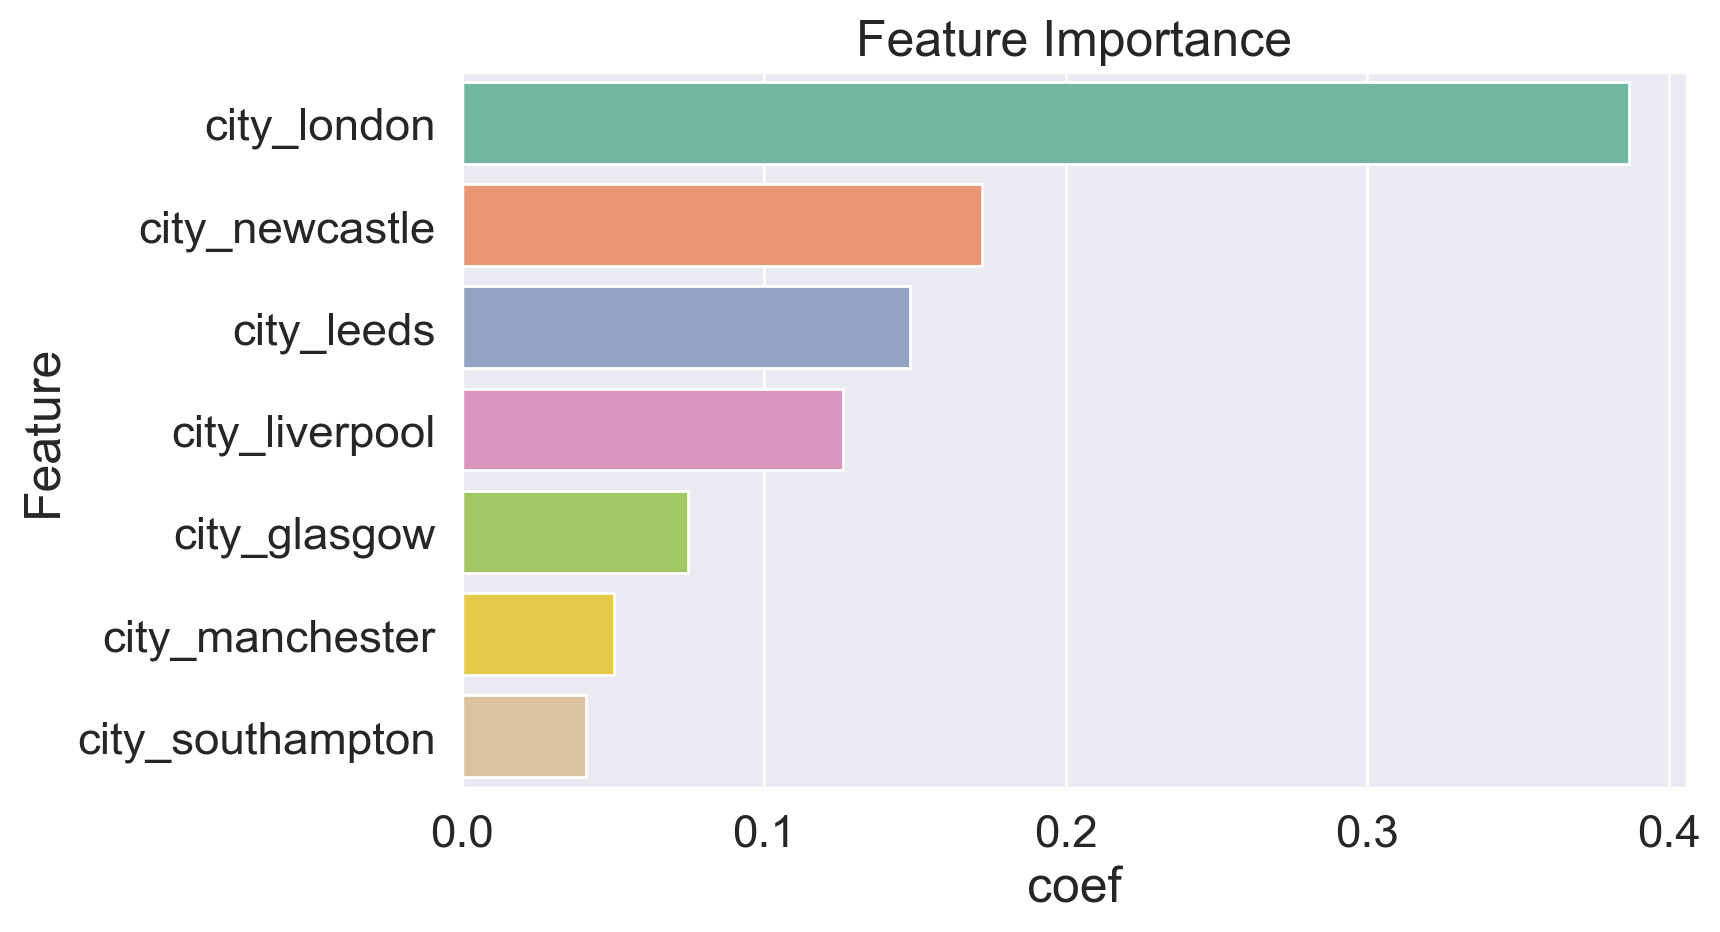

In [35]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(9,5))

df_randfor_gs = pd.DataFrame({'variable': feature_names,'coef':randFor_best.feature_importances_}).sort_values(by='coef', ascending=False)#.plot(kind='barh', x=0, y=1, label='RandomForest', ax=ax)
sns.barplot(data = df_randfor_gs, x='coef', y='variable')
ax.set_title('Feature Importance')
ax.set_ylabel('Feature')
fig.tight_layout()
plt.show()

Tuning hyperparamesters does not add much value to model performance. 

Feature importance again follows similar expectation with London and Newcastle feature importance being the top 2, as stated above.

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


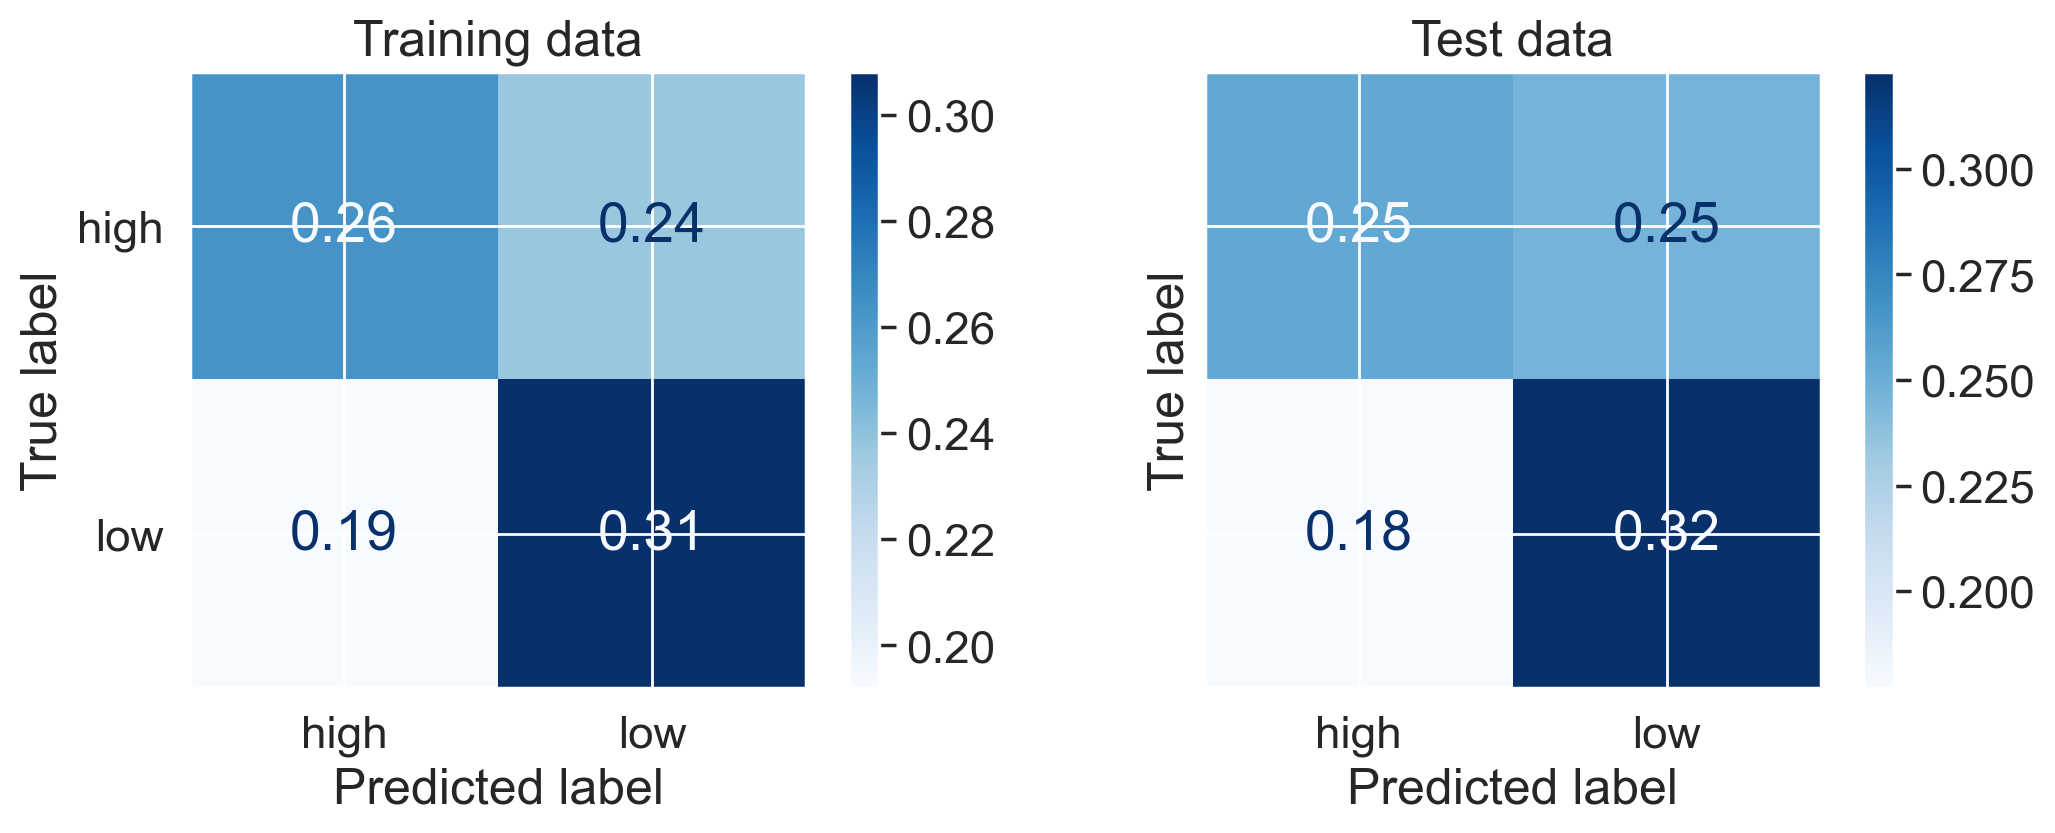

In [36]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 4), sharey=True)
plot_confusion_matrix(randFor_best, X1_train, y_train, cmap='Blues', ax=ax[0], normalize='all')
plot_confusion_matrix(randFor_best, X1_test, y_test, cmap='Blues', ax=ax[1], normalize='all')

ax[0].set_title('Training data')
ax[1].set_title('Test data')

for a in ax:
    texts = a.texts
    for text in texts:
        text.set_size(20)

plt.show()

### Conclusion Part 1.
A logistic regression model and a random forest model was run using just location as a predictor. Both models perform very similarly and give a mean cross-validated accuracy score of 0.57. This is above baseline but not particularly high. Location is a good predictor but we will need to add other features to improve the score.

Both models seem to predict low salaries better than higher salaries.

The bar charts showing the feature importances, which largely agree between the two models. London is the most important in both cases. The coefficients for the logistic regression model indicate the direction of the impact of the features (positive or negative) as well - London and Manchester both point towards a high salary and the remaining regions point towards a low salary.

Lets add more features to model on.

## Add more features
Try to improve model scores by including more features. Check scores after adding the following : 
- city
- type of salary pay
- salary security 
- position level 
- jobtitle key words (have to feature engineer with NLP)

### NLP on JobTitle for more features
- converting JobTitle to text and applying NLP with TfidfVectorizer

In [37]:
from sklearn.feature_extraction.text import TfidfVectorizer

Create pipeline

In [38]:
# create pipepline with additional features
one_hot_1 = OneHotEncoder(sparse=False, drop='first')

tvec_title = TfidfVectorizer(stop_words='english',token_pattern='\w+')
                             #,ngram_range=(1,1), max_features=None, min_df=1)

col_trans_2 = ColumnTransformer([('job_title', tvec_title, 'jobtitle'),
                                 ('categories', one_hot_1, 
                                  ['city','salary_pay_type','salary_security','position_level'])],
                                remainder='drop',sparse_threshold=0.6) 

pipe2 = Pipeline(steps=[('col_trans', col_trans_2),
                        ('scaler', StandardScaler(with_mean=False))])

In [39]:
X2_train = pipe2.fit_transform(X_train)
X2_test = pipe2.transform(X_test)
X2_train

<974x761 sparse matrix of type '<class 'numpy.float64'>'
	with 6193 stored elements in Compressed Sparse Row format>

### Logistic Regression

In [40]:
model_logreg = LogisticRegression(max_iter = 100000, random_state=1)
model_logreg.fit(X2_train, y_train)

cvSKF = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)

In [41]:
predictions = model_logreg.predict(X2_test)
cv_score = cross_val_score(model_logreg, X2_train, y_train, cv=cvSKF)

In [42]:
print("Accuracy / Train score:",model_logreg.score(X2_train, y_train))
print("Accuracy / Test score:",model_logreg.score(X2_test, y_test))
print("mean CV score:",cv_score.mean())

Accuracy / Train score: 0.9229979466119097
Accuracy / Test score: 0.7344497607655502
mean CV score: 0.7197779540047581


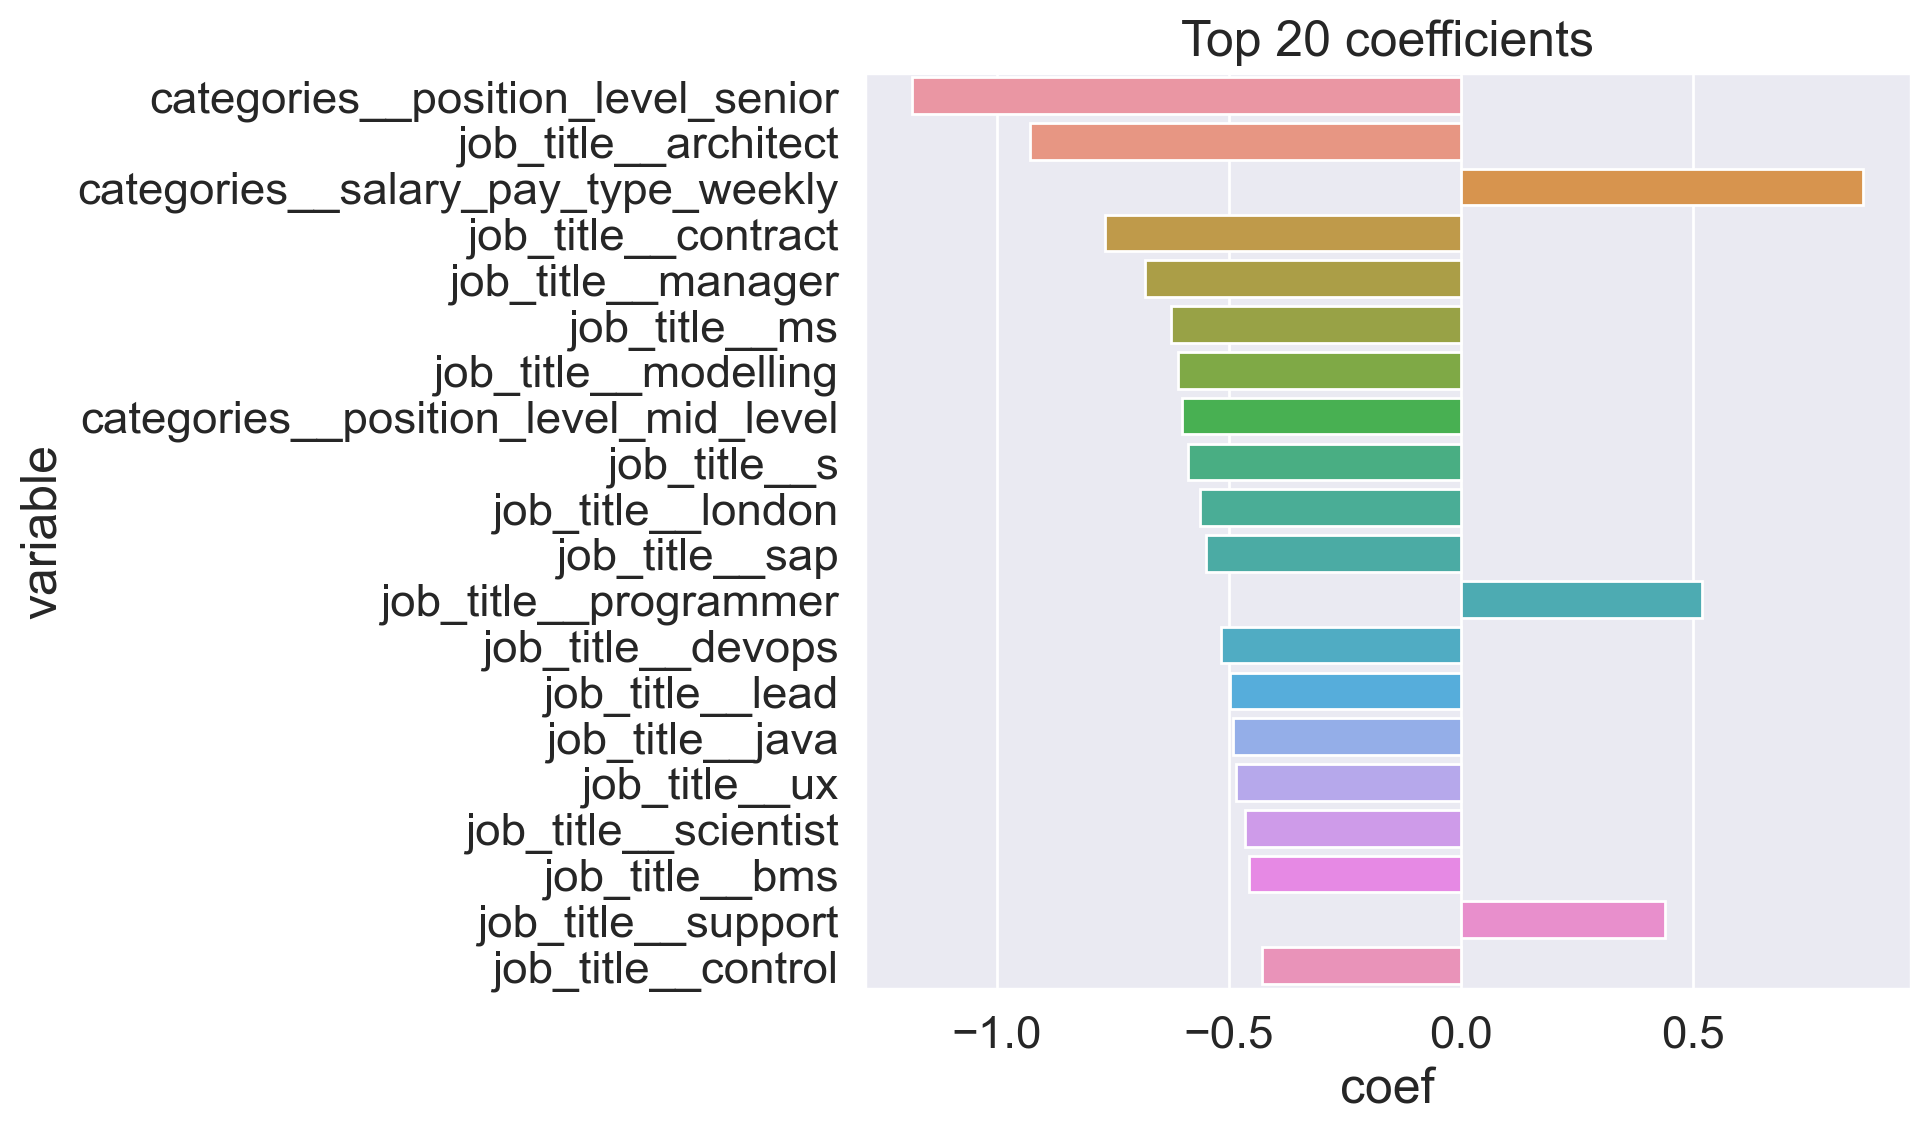

In [43]:
coefs_vars_logreg = pd.DataFrame({'variable': pipe2[:-1].get_feature_names_out(), 
                                  'coef': model_logreg.coef_[0],
                                  'abscoef': np.abs(model_logreg.coef_[0])}).sort_values(by='abscoef', ascending=False)
coefs_top20 = coefs_vars_logreg.head(20)

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=((10,6)))
sns.barplot(x = coefs_top20.coef, y = coefs_top20.variable, orient='h', ax=ax)
ax.set_title('Top 20 coefficients')
fig.tight_layout()
plt.show()

Can see improvement in CV scores and test score when including more features. Makes sense as including more features would explain more of the variance in the target variable, in turn increase accuracy and overall model performance.

- **Job title**

The bar chart above shows the model coefficients from the logistic regression model. Many words from the job title feature in the largest 20 coefficients e.g. 'manager', 'architect', 'devops', 'lead', which point to high salaries and 'support', 'programmer' which point to low salaries.

- **Salary pay type**

Adding in salary type (how the salary is quoted) made a small improvement to the accuracy score. The bar chart above shows that salaries quoted weekly feature as one of the largest model coefficients (pointing to low salaries).

- **Position Level**

We see that both the categorised 'senior' and 'mid-level' position levels are strong indictators for high salaries.

## Tuning model parameters
So far only tested 2 classifiers - Random Forest + Logistic regression. Can tune these classifiers and try some others to achieve the best accuracy score. Add scores and best model parameters to a dataframe for easy comparison.

In [92]:
scores_dict = {'model_name': [],'mean_cv_score': [],'training_score': [], 'test_score': [],'precision_high': [],
               'recall_high': [],'precision_low': [],'recall_low': [],'roc_auc_score': [],'model_params': []}

In [93]:
def add_gs_model(model_name, model):
    scores_dict['model_name'].append(model_name)
    scores_dict['mean_cv_score'].append(model.best_score_)
    scores_dict['training_score'].append(model.score(X2_train, y_train))
    scores_dict['test_score'].append(model.score(X2_test, y_test))
    scores_dict['precision_high'].append(precision_score(y_test, model.predict(X2_test), pos_label='high'))
    scores_dict['recall_high'].append(recall_score(y_test, model.predict(X2_test), pos_label='high'))                                       
    scores_dict['precision_low'].append(precision_score(y_test, model.predict(X2_test), pos_label='low'))
    scores_dict['recall_low'].append(recall_score(y_test, model.predict(X2_test), pos_label='low'))                               
    scores_dict['roc_auc_score'].append(roc_auc_score(y_test, model.predict_proba(X2_test)[:, 1]))
    scores_dict['model_params'].append(model.best_params_)

### Logistic Regression GS

with Logisitic Regression model to fine tune hyperparameters and find best estimator.

In [46]:
params = {'C': np.logspace(-5, 5, 15),
          'penalty': ['l1', 'l2', 'elasticnet'],
          'fit_intercept': [True, False],
          'solver': ['saga','liblinear','lbfgs']}

logReg_gs = GridSearchCV(estimator = model_logreg, param_grid= params, 
                         cv = cvSKF,scoring='accuracy',n_jobs=-2, verbose=2)
logReg_gs.fit(X2_train, y_train)

Fitting 5 folds for each of 270 candidates, totalling 1350 fits
[CV] END C=1e-05, fit_intercept=True, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END C=0.0002682695795279727, fit_intercept=False, penalty=l2, solver=saga; total time=   0.0s
[CV] END C=0.0002682695795279727, fit_intercept=False, penalty=l2, solver=saga; total time=   0.0s
[CV] END C=0.0002682695795279727, fit_intercept=False, penalty=l2, solver=saga; total time=   0.0s
[CV] END C=0.0002682695795279727, fit_intercept=False, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=0.0002682695795279727, fit_intercept=False, penalty=elasticnet, solver=lbfgs; total time=   0.0s
[CV] END C=0.0002682695795279727, fit_intercept=False, penalty=elasticnet, solver=lbfgs; total time=   0.0s
[CV] END C=0.0002682695795279727, fit_intercept=False, penalty=elasticnet, solver=lbfgs; total time=   0.0s
[CV] END C=0.0002682695795279727, fit_intercept=False, penalty=elasticnet, solver=lbfgs; total time=   0.0s
[CV] END C=0.0013894

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
600 fits failed out of a total of 1350.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
150 fits failed with the following error:
Traceback (most recent call last):
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 449, in 

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
             estimator=LogisticRegression(max_iter=100000, random_state=1),
             n_jobs=-2,
             param_grid={'C': array([1.00000000e-05, 5.17947468e-05, 2.68269580e-04, 1.38949549e-03,
       7.19685673e-03, 3.72759372e-02, 1.93069773e-01, 1.00000000e+00,
       5.17947468e+00, 2.68269580e+01, 1.38949549e+02, 7.19685673e+02,
       3.72759372e+03, 1.93069773e+04, 1.00000000e+05]),
                         'fit_intercept': [True, False],
                         'penalty': ['l1', 'l2', 'elasticnet'],
                         'solver': ['saga', 'liblinear', 'lbfgs']},
             scoring='accuracy', verbose=2)

In [47]:
logReg_best = logReg_gs.best_estimator_
cv_score = cross_val_score(logReg_best, X2_train, y_train, cv = cvSKF)

In [48]:
print("Optimal Regularizaiton penalty:",logReg_best.penalty)

Optimal Regularizaiton penalty: l2


In [69]:
print('Best parameters:', logReg_gs.best_params_)
print('Best estimator C:', logReg_gs.best_estimator_.C)
print('Best estimator score on the full training set:', logReg_best.score(X2_train, y_train))
print('Best estimator score on the test set:', logReg_best.score(X2_test, y_test))
print('Best estimator mean cross-validated training score:', logReg_gs.best_score_)

Best parameters: {'C': 0.0013894954943731374, 'fit_intercept': True, 'penalty': 'l2', 'solver': 'lbfgs'}
Best estimator C: 0.0013894954943731374
Best estimator score on the full training set: 0.8901437371663244
Best estimator score on the test set: 0.7344497607655502
Best estimator mean cross-validated training score: 0.7474861221252974


In [94]:
add_gs_model('Logistic regression', logReg_gs)

### Random Forest GS

In [51]:
randFor_params = {'max_depth': [1,2,3,4,None],  #for 7 features above 5 is pointless
                  'max_features': [0.1, 0.2,0.3,0.5,0.7,0.9,1.0],  #for random forest class you never want 100% of features
                  'max_leaf_nodes': [10,50,100,200, None],          #as each estimator would ask the same question
                  'criterion' : ['entropy'],                   #want to maximise variance and avg out to lower this later
                  'n_estimators' :[100,300,400],  ##never have less than 100 
                  'ccp_alpha':[0.0,0.1,0.2]}

cvSKF=StratifiedKFold(n_splits=5, random_state=1, shuffle=True)

model_randFor = RandomForestClassifier()

randFor_gs = GridSearchCV(model_randFor, randFor_params, cv = cvSKF, verbose=2, n_jobs=-2)


In [52]:
randFor_gs.fit(X2_train,y_train)

Fitting 5 folds for each of 1575 candidates, totalling 7875 fits
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=1, max_features=0.1, max_leaf_nodes=10, n_estimators=100; total time=   0.2s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=1, max_features=0.1, max_leaf_nodes=50, n_estimators=100; total time=   0.2s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=1, max_features=0.1, max_leaf_nodes=50, n_estimators=300; total time=   0.7s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=1, max_features=0.1, max_leaf_nodes=100, n_estimators=400; total time=   0.8s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=1, max_features=0.1, max_leaf_nodes=None, n_estimators=100; total time=   0.2s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=1, max_features=0.1, max_leaf_nodes=None, n_estimators=300; total time=   0.7s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=1, max_features=0.2, max_leaf_nodes=10, n_estimators=300; total time=   0.7s
[CV] END ccp_alpha=0

[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=2, max_features=0.9, max_leaf_nodes=50, n_estimators=400; total time=   1.7s[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=1, max_features=0.1, max_leaf_nodes=10, n_estimators=300; total time=   0.7s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=1, max_features=0.1, max_leaf_nodes=50, n_estimators=400; total time=   0.9s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=1, max_features=0.1, max_leaf_nodes=200, n_estimators=100; total time=   0.2s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=1, max_features=0.1, max_leaf_nodes=200, n_estimators=400; total time=   0.9s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=1, max_features=0.2, max_leaf_nodes=10, n_estimators=100; total time=   0.2s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=1, max_features=0.2, max_leaf_nodes=10, n_estimators=300; total time=   0.7s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=1, max_features=0.2, max_leaf_nodes=

[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=2, max_features=0.9, max_leaf_nodes=50, n_estimators=300; total time=   1.3s[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=1, max_features=0.1, max_leaf_nodes=10, n_estimators=100; total time=   0.2s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=1, max_features=0.1, max_leaf_nodes=50, n_estimators=100; total time=   0.2s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=1, max_features=0.1, max_leaf_nodes=50, n_estimators=300; total time=   0.7s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=1, max_features=0.1, max_leaf_nodes=100, n_estimators=400; total time=   0.9s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=1, max_features=0.1, max_leaf_nodes=None, n_estimators=100; total time=   0.2s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=1, max_features=0.1, max_leaf_nodes=None, n_estimators=300; total time=   0.7s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=1, max_features=0.2, max_leaf_nod

[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=2, max_features=0.9, max_leaf_nodes=50, n_estimators=400; total time=   1.7s[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=1, max_features=0.1, max_leaf_nodes=10, n_estimators=400; total time=   0.9s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=1, max_features=0.1, max_leaf_nodes=100, n_estimators=100; total time=   0.2s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=1, max_features=0.1, max_leaf_nodes=100, n_estimators=300; total time=   0.7s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=1, max_features=0.1, max_leaf_nodes=200, n_estimators=300; total time=   0.7s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=1, max_features=0.1, max_leaf_nodes=None, n_estimators=400; total time=   0.9s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=1, max_features=0.2, max_leaf_nodes=50, n_estimators=100; total time=   0.2s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=1, max_features=0.2, max_leaf_nod

[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=2, max_features=0.9, max_leaf_nodes=100, n_estimators=400; total time=   1.6s[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=1, max_features=0.1, max_leaf_nodes=10, n_estimators=300; total time=   0.7s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=1, max_features=0.1, max_leaf_nodes=50, n_estimators=400; total time=   0.9s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=1, max_features=0.1, max_leaf_nodes=200, n_estimators=100; total time=   0.2s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=1, max_features=0.1, max_leaf_nodes=200, n_estimators=400; total time=   0.9s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=1, max_features=0.2, max_leaf_nodes=10, n_estimators=100; total time=   0.2s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=1, max_features=0.2, max_leaf_nodes=10, n_estimators=400; total time=   0.9s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=1, max_features=0.2, max_leaf_nodes

[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=2, max_features=0.9, max_leaf_nodes=100, n_estimators=300; total time=   1.2s[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=1, max_features=0.1, max_leaf_nodes=10, n_estimators=300; total time=   0.7s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=1, max_features=0.1, max_leaf_nodes=50, n_estimators=400; total time=   0.9s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=1, max_features=0.1, max_leaf_nodes=200, n_estimators=100; total time=   0.2s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=1, max_features=0.1, max_leaf_nodes=200, n_estimators=300; total time=   0.7s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=1, max_features=0.1, max_leaf_nodes=None, n_estimators=400; total time=   0.9s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=1, max_features=0.2, max_leaf_nodes=50, n_estimators=100; total time=   0.2s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=1, max_features=0.2, max_leaf_nod

[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=2, max_features=0.9, max_leaf_nodes=200, n_estimators=100; total time=   0.4s[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=1, max_features=0.1, max_leaf_nodes=10, n_estimators=300; total time=   0.7s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=1, max_features=0.1, max_leaf_nodes=50, n_estimators=400; total time=   0.9s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=1, max_features=0.1, max_leaf_nodes=200, n_estimators=100; total time=   0.2s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=1, max_features=0.1, max_leaf_nodes=200, n_estimators=300; total time=   0.7s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=1, max_features=0.1, max_leaf_nodes=None, n_estimators=400; total time=   0.9s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=1, max_features=0.2, max_leaf_nodes=50, n_estimators=100; total time=   0.2s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=1, max_features=0.2, max_leaf_nod

[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=2, max_features=0.9, max_leaf_nodes=100, n_estimators=300; total time=   1.2s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=2, max_features=0.9, max_leaf_nodes=200, n_estimators=400; total time=   1.7s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=2, max_features=1.0, max_leaf_nodes=10, n_estimators=100; total time=   0.4s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=2, max_features=1.0, max_leaf_nodes=10, n_estimators=300; total time=   1.3s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=2, max_features=1.0, max_leaf_nodes=50, n_estimators=400; total time=   1.8s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=2, max_features=1.0, max_leaf_nodes=200, n_estimators=100; total time=   0.5s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=2, max_features=1.0, max_leaf_nodes=200, n_estimators=400; total time=   1.7s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=3, max_features=0.1, max_leaf_nod

[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=4, max_features=0.7, max_leaf_nodes=10, n_estimators=300; total time=   1.6s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=2, max_features=0.9, max_leaf_nodes=100, n_estimators=300; total time=   1.2s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=2, max_features=0.9, max_leaf_nodes=200, n_estimators=400; total time=   1.7s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=2, max_features=1.0, max_leaf_nodes=10, n_estimators=100; total time=   0.5s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=2, max_features=1.0, max_leaf_nodes=10, n_estimators=400; total time=   1.8s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=2, max_features=1.0, max_leaf_nodes=100, n_estimators=100; total time=   0.4s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=2, max_features=1.0, max_leaf_nodes=100, n_estimators=300; total time=   1.3s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=2, max_features=1.0, max_leaf_nod

[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=4, max_features=0.7, max_leaf_nodes=50, n_estimators=100; total time=   0.5s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=2, max_features=0.9, max_leaf_nodes=200, n_estimators=300; total time=   1.2s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=2, max_features=0.9, max_leaf_nodes=None, n_estimators=400; total time=   1.6s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=2, max_features=1.0, max_leaf_nodes=50, n_estimators=100; total time=   0.4s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=2, max_features=1.0, max_leaf_nodes=50, n_estimators=300; total time=   1.3s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=2, max_features=1.0, max_leaf_nodes=100, n_estimators=400; total time=   1.8s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=2, max_features=1.0, max_leaf_nodes=None, n_estimators=100; total time=   0.4s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=2, max_features=1.0, max_leaf_n

[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=4, max_features=0.7, max_leaf_nodes=50, n_estimators=100; total time=   0.5s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=2, max_features=0.9, max_leaf_nodes=200, n_estimators=300; total time=   1.3s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=2, max_features=0.9, max_leaf_nodes=None, n_estimators=400; total time=   1.6s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=2, max_features=1.0, max_leaf_nodes=50, n_estimators=100; total time=   0.4s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=2, max_features=1.0, max_leaf_nodes=50, n_estimators=300; total time=   1.3s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=2, max_features=1.0, max_leaf_nodes=100, n_estimators=400; total time=   1.8s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=2, max_features=1.0, max_leaf_nodes=None, n_estimators=100; total time=   0.4s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=2, max_features=1.0, max_leaf_n

[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=4, max_features=0.7, max_leaf_nodes=10, n_estimators=400; total time=   2.1s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=2, max_features=0.9, max_leaf_nodes=200, n_estimators=100; total time=   0.4s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=2, max_features=0.9, max_leaf_nodes=200, n_estimators=400; total time=   1.7s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=2, max_features=1.0, max_leaf_nodes=10, n_estimators=100; total time=   0.5s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=2, max_features=1.0, max_leaf_nodes=10, n_estimators=300; total time=   1.3s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=2, max_features=1.0, max_leaf_nodes=50, n_estimators=400; total time=   1.7s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=2, max_features=1.0, max_leaf_nodes=200, n_estimators=100; total time=   0.5s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=2, max_features=1.0, max_leaf_node

[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=4, max_features=0.7, max_leaf_nodes=10, n_estimators=100; total time=   0.5s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=2, max_features=0.9, max_leaf_nodes=200, n_estimators=300; total time=   1.2s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=2, max_features=0.9, max_leaf_nodes=None, n_estimators=400; total time=   1.6s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=2, max_features=1.0, max_leaf_nodes=50, n_estimators=100; total time=   0.4s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=2, max_features=1.0, max_leaf_nodes=50, n_estimators=300; total time=   1.3s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=2, max_features=1.0, max_leaf_nodes=100, n_estimators=400; total time=   1.8s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=2, max_features=1.0, max_leaf_nodes=None, n_estimators=100; total time=   0.4s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=2, max_features=1.0, max_leaf_n

[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=4, max_features=0.5, max_leaf_nodes=200, n_estimators=300; total time=   1.3s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=2, max_features=0.9, max_leaf_nodes=100, n_estimators=400; total time=   1.6s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=2, max_features=0.9, max_leaf_nodes=None, n_estimators=100; total time=   0.4s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=2, max_features=0.9, max_leaf_nodes=None, n_estimators=300; total time=   1.2s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=2, max_features=1.0, max_leaf_nodes=10, n_estimators=400; total time=   1.7s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=2, max_features=1.0, max_leaf_nodes=100, n_estimators=100; total time=   0.4s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=2, max_features=1.0, max_leaf_nodes=100, n_estimators=300; total time=   1.3s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=2, max_features=1.0, max_leaf

[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=4, max_features=0.5, max_leaf_nodes=None, n_estimators=300; total time=   1.2s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=2, max_features=0.9, max_leaf_nodes=None, n_estimators=100; total time=   0.4s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=2, max_features=0.9, max_leaf_nodes=None, n_estimators=300; total time=   1.2s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=2, max_features=1.0, max_leaf_nodes=10, n_estimators=400; total time=   1.7s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=2, max_features=1.0, max_leaf_nodes=100, n_estimators=100; total time=   0.4s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=2, max_features=1.0, max_leaf_nodes=100, n_estimators=300; total time=   1.3s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=2, max_features=1.0, max_leaf_nodes=200, n_estimators=400; total time=   1.7s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=3, max_features=0.1, max_lea

[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=4, max_features=0.7, max_leaf_nodes=50, n_estimators=300; total time=   1.6s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=2, max_features=0.9, max_leaf_nodes=200, n_estimators=300; total time=   1.2s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=2, max_features=0.9, max_leaf_nodes=None, n_estimators=400; total time=   1.6s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=2, max_features=1.0, max_leaf_nodes=50, n_estimators=100; total time=   0.4s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=2, max_features=1.0, max_leaf_nodes=50, n_estimators=300; total time=   1.3s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=2, max_features=1.0, max_leaf_nodes=100, n_estimators=300; total time=   1.4s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=2, max_features=1.0, max_leaf_nodes=200, n_estimators=400; total time=   1.7s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=3, max_features=0.1, max_leaf_no

[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=4, max_features=0.7, max_leaf_nodes=10, n_estimators=300; total time=   1.6s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=4, max_features=0.7, max_leaf_nodes=50, n_estimators=400; total time=   2.1s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=4, max_features=0.7, max_leaf_nodes=200, n_estimators=100; total time=   0.5s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=4, max_features=0.7, max_leaf_nodes=200, n_estimators=400; total time=   2.1s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=4, max_features=0.9, max_leaf_nodes=10, n_estimators=100; total time=   0.6s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=4, max_features=0.9, max_leaf_nodes=10, n_estimators=400; total time=   2.5s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=4, max_features=0.9, max_leaf_nodes=100, n_estimators=100; total time=   0.6s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=4, max_features=0.9, max_leaf_node

[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=1, max_features=0.2, max_leaf_nodes=50, n_estimators=400; total time=   1.1s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=4, max_features=0.7, max_leaf_nodes=50, n_estimators=300; total time=   1.6s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=4, max_features=0.7, max_leaf_nodes=100, n_estimators=400; total time=   2.1s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=4, max_features=0.7, max_leaf_nodes=None, n_estimators=100; total time=   0.5s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=4, max_features=0.7, max_leaf_nodes=None, n_estimators=300; total time=   1.4s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=4, max_features=0.9, max_leaf_nodes=10, n_estimators=300; total time=   1.9s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=4, max_features=0.9, max_leaf_nodes=50, n_estimators=400; total time=   2.5s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=4, max_features=0.9, max_leaf_no

[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=1, max_features=0.2, max_leaf_nodes=None, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=4, max_features=0.7, max_leaf_nodes=10, n_estimators=300; total time=   1.6s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=4, max_features=0.7, max_leaf_nodes=50, n_estimators=400; total time=   2.0s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=4, max_features=0.7, max_leaf_nodes=200, n_estimators=100; total time=   0.5s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=4, max_features=0.7, max_leaf_nodes=200, n_estimators=300; total time=   1.5s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=4, max_features=0.7, max_leaf_nodes=None, n_estimators=400; total time=   1.9s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=4, max_features=0.9, max_leaf_nodes=50, n_estimators=100; total time=   0.6s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=4, max_features=0.9, max_leaf_n

[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=1, max_features=0.2, max_leaf_nodes=200, n_estimators=400; total time=   1.1s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=4, max_features=0.7, max_leaf_nodes=100, n_estimators=100; total time=   0.5s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=4, max_features=0.7, max_leaf_nodes=100, n_estimators=300; total time=   1.6s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=4, max_features=0.7, max_leaf_nodes=200, n_estimators=400; total time=   2.1s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=4, max_features=0.9, max_leaf_nodes=10, n_estimators=100; total time=   0.6s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=4, max_features=0.9, max_leaf_nodes=10, n_estimators=400; total time=   2.6s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=4, max_features=0.9, max_leaf_nodes=100, n_estimators=100; total time=   0.6s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=4, max_features=0.9, max_leaf_no

[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=1, max_features=0.2, max_leaf_nodes=None, n_estimators=300; total time=   0.8s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=4, max_features=0.7, max_leaf_nodes=50, n_estimators=300; total time=   1.6s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=4, max_features=0.7, max_leaf_nodes=100, n_estimators=400; total time=   2.1s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=4, max_features=0.7, max_leaf_nodes=None, n_estimators=100; total time=   0.5s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=4, max_features=0.7, max_leaf_nodes=None, n_estimators=300; total time=   1.4s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=4, max_features=0.9, max_leaf_nodes=10, n_estimators=300; total time=   1.9s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=4, max_features=0.9, max_leaf_nodes=50, n_estimators=400; total time=   2.5s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=4, max_features=0.9, max_leaf_

[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=1, max_features=0.3, max_leaf_nodes=10, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=4, max_features=0.7, max_leaf_nodes=10, n_estimators=400; total time=   2.1s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=4, max_features=0.7, max_leaf_nodes=100, n_estimators=100; total time=   0.5s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=4, max_features=0.7, max_leaf_nodes=100, n_estimators=400; total time=   2.1s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=4, max_features=0.7, max_leaf_nodes=None, n_estimators=100; total time=   0.5s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=4, max_features=0.7, max_leaf_nodes=None, n_estimators=300; total time=   1.4s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=4, max_features=0.9, max_leaf_nodes=10, n_estimators=300; total time=   1.9s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=4, max_features=0.9, max_leaf_n

[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=1, max_features=0.3, max_leaf_nodes=50, n_estimators=400; total time=   1.1s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=4, max_features=0.7, max_leaf_nodes=10, n_estimators=300; total time=   1.6s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=4, max_features=0.7, max_leaf_nodes=50, n_estimators=400; total time=   2.1s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=4, max_features=0.7, max_leaf_nodes=200, n_estimators=100; total time=   0.5s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=4, max_features=0.7, max_leaf_nodes=200, n_estimators=300; total time=   1.6s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=4, max_features=0.7, max_leaf_nodes=None, n_estimators=400; total time=   1.9s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=4, max_features=0.9, max_leaf_nodes=50, n_estimators=100; total time=   0.6s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=4, max_features=0.9, max_leaf_nod

[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=1, max_features=0.3, max_leaf_nodes=200, n_estimators=300; total time=   0.9s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=4, max_features=0.5, max_leaf_nodes=None, n_estimators=400; total time=   1.7s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=4, max_features=0.7, max_leaf_nodes=50, n_estimators=100; total time=   0.5s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=4, max_features=0.7, max_leaf_nodes=50, n_estimators=300; total time=   1.6s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=4, max_features=0.7, max_leaf_nodes=100, n_estimators=400; total time=   2.1s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=4, max_features=0.7, max_leaf_nodes=None, n_estimators=100; total time=   0.5s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=4, max_features=0.7, max_leaf_nodes=None, n_estimators=300; total time=   1.4s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=4, max_features=0.9, max_leaf

[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=1, max_features=0.3, max_leaf_nodes=None, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=4, max_features=0.7, max_leaf_nodes=100, n_estimators=100; total time=   0.5s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=4, max_features=0.7, max_leaf_nodes=100, n_estimators=300; total time=   1.6s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=4, max_features=0.7, max_leaf_nodes=200, n_estimators=300; total time=   1.6s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=4, max_features=0.7, max_leaf_nodes=None, n_estimators=400; total time=   1.9s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=4, max_features=0.9, max_leaf_nodes=50, n_estimators=100; total time=   0.6s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=4, max_features=0.9, max_leaf_nodes=50, n_estimators=300; total time=   1.9s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=4, max_features=0.9, max_leaf_

[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=1, max_features=0.3, max_leaf_nodes=None, n_estimators=300; total time=   0.9s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=4, max_features=0.7, max_leaf_nodes=100, n_estimators=100; total time=   0.5s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=4, max_features=0.7, max_leaf_nodes=100, n_estimators=300; total time=   1.6s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=4, max_features=0.7, max_leaf_nodes=200, n_estimators=400; total time=   2.1s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=4, max_features=0.9, max_leaf_nodes=10, n_estimators=100; total time=   0.6s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=4, max_features=0.9, max_leaf_nodes=10, n_estimators=400; total time=   2.6s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=4, max_features=0.9, max_leaf_nodes=100, n_estimators=100; total time=   0.6s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=4, max_features=0.9, max_leaf_n

[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=1, max_features=0.5, max_leaf_nodes=10, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=4, max_features=0.7, max_leaf_nodes=50, n_estimators=400; total time=   2.1s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=4, max_features=0.7, max_leaf_nodes=200, n_estimators=100; total time=   0.5s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=4, max_features=0.7, max_leaf_nodes=200, n_estimators=300; total time=   1.6s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=4, max_features=0.7, max_leaf_nodes=None, n_estimators=400; total time=   1.9s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=4, max_features=0.9, max_leaf_nodes=50, n_estimators=100; total time=   0.6s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=4, max_features=0.9, max_leaf_nodes=50, n_estimators=300; total time=   1.9s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=4, max_features=0.9, max_leaf_nod

[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=1, max_features=0.5, max_leaf_nodes=10, n_estimators=300; total time=   0.9s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=4, max_features=0.7, max_leaf_nodes=50, n_estimators=300; total time=   1.6s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=4, max_features=0.7, max_leaf_nodes=100, n_estimators=300; total time=   1.6s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=4, max_features=0.7, max_leaf_nodes=200, n_estimators=400; total time=   2.1s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=4, max_features=0.9, max_leaf_nodes=10, n_estimators=100; total time=   0.6s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=4, max_features=0.9, max_leaf_nodes=10, n_estimators=400; total time=   2.6s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=4, max_features=0.9, max_leaf_nodes=100, n_estimators=100; total time=   0.6s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=4, max_features=0.9, max_leaf_node

[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=1, max_features=0.5, max_leaf_nodes=50, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=1, max_features=0.2, max_leaf_nodes=200, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=1, max_features=0.2, max_leaf_nodes=200, n_estimators=300; total time=   0.8s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=1, max_features=0.2, max_leaf_nodes=None, n_estimators=400; total time=   1.0s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=1, max_features=0.3, max_leaf_nodes=50, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=1, max_features=0.3, max_leaf_nodes=50, n_estimators=300; total time=   0.8s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=1, max_features=0.3, max_leaf_nodes=100, n_estimators=300; total time=   0.9s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=1, max_features=0.3, max_leaf_no

[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=2, max_features=1.0, max_leaf_nodes=None, n_estimators=300; total time=   1.1s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=1, max_features=0.3, max_leaf_nodes=10, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=1, max_features=0.3, max_leaf_nodes=10, n_estimators=300; total time=   0.8s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=1, max_features=0.3, max_leaf_nodes=50, n_estimators=400; total time=   1.1s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=1, max_features=0.3, max_leaf_nodes=200, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=1, max_features=0.3, max_leaf_nodes=200, n_estimators=300; total time=   0.9s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=1, max_features=0.3, max_leaf_nodes=None, n_estimators=400; total time=   1.2s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=1, max_features=0.5, max_leaf_n

[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=3, max_features=0.1, max_leaf_nodes=50, n_estimators=400; total time=   1.1s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=1, max_features=0.3, max_leaf_nodes=10, n_estimators=300; total time=   0.8s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=1, max_features=0.3, max_leaf_nodes=50, n_estimators=400; total time=   1.1s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=1, max_features=0.3, max_leaf_nodes=200, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=1, max_features=0.3, max_leaf_nodes=200, n_estimators=400; total time=   1.2s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=1, max_features=0.5, max_leaf_nodes=10, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=1, max_features=0.5, max_leaf_nodes=10, n_estimators=300; total time=   0.9s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=1, max_features=0.5, max_leaf_nodes

[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=3, max_features=0.1, max_leaf_nodes=200, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=1, max_features=0.3, max_leaf_nodes=10, n_estimators=300; total time=   0.8s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=1, max_features=0.3, max_leaf_nodes=50, n_estimators=300; total time=   0.8s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=1, max_features=0.3, max_leaf_nodes=100, n_estimators=400; total time=   1.1s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=1, max_features=0.3, max_leaf_nodes=None, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=1, max_features=0.3, max_leaf_nodes=None, n_estimators=300; total time=   0.9s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=1, max_features=0.5, max_leaf_nodes=10, n_estimators=400; total time=   1.2s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=1, max_features=0.5, max_leaf_n

[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=3, max_features=0.1, max_leaf_nodes=100, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=1, max_features=0.3, max_leaf_nodes=200, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=1, max_features=0.3, max_leaf_nodes=200, n_estimators=300; total time=   0.9s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=1, max_features=0.3, max_leaf_nodes=None, n_estimators=400; total time=   1.1s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=1, max_features=0.5, max_leaf_nodes=50, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=1, max_features=0.5, max_leaf_nodes=50, n_estimators=300; total time=   0.9s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=1, max_features=0.5, max_leaf_nodes=100, n_estimators=400; total time=   1.2s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=1, max_features=0.5, max_leaf_n

[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=3, max_features=0.1, max_leaf_nodes=None, n_estimators=300; total time=   0.9s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=1, max_features=0.5, max_leaf_nodes=10, n_estimators=300; total time=   0.9s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=1, max_features=0.5, max_leaf_nodes=50, n_estimators=400; total time=   1.2s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=1, max_features=0.5, max_leaf_nodes=200, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=1, max_features=0.5, max_leaf_nodes=200, n_estimators=300; total time=   1.0s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=1, max_features=0.5, max_leaf_nodes=None, n_estimators=300; total time=   0.9s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=1, max_features=0.7, max_leaf_nodes=10, n_estimators=400; total time=   1.3s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=1, max_features=0.7, max_leaf_n

[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=3, max_features=0.2, max_leaf_nodes=200, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=1, max_features=0.3, max_leaf_nodes=None, n_estimators=400; total time=   1.1s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=1, max_features=0.5, max_leaf_nodes=50, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=1, max_features=0.5, max_leaf_nodes=50, n_estimators=300; total time=   0.9s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=1, max_features=0.5, max_leaf_nodes=100, n_estimators=300; total time=   0.9s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=1, max_features=0.5, max_leaf_nodes=200, n_estimators=300; total time=   1.0s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=1, max_features=0.5, max_leaf_nodes=None, n_estimators=400; total time=   1.2s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=1, max_features=0.7, max_leaf_

[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=3, max_features=0.2, max_leaf_nodes=50, n_estimators=300; total time=   0.9s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=1, max_features=0.5, max_leaf_nodes=10, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=1, max_features=0.5, max_leaf_nodes=10, n_estimators=300; total time=   0.9s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=1, max_features=0.5, max_leaf_nodes=50, n_estimators=400; total time=   1.2s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=1, max_features=0.5, max_leaf_nodes=200, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=1, max_features=0.5, max_leaf_nodes=200, n_estimators=300; total time=   1.0s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=1, max_features=0.5, max_leaf_nodes=None, n_estimators=400; total time=   1.2s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=1, max_features=0.7, max_leaf_nod

[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=3, max_features=0.2, max_leaf_nodes=50, n_estimators=400; total time=   1.3s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=1, max_features=0.5, max_leaf_nodes=50, n_estimators=300; total time=   0.9s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=1, max_features=0.5, max_leaf_nodes=100, n_estimators=400; total time=   1.2s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=1, max_features=0.5, max_leaf_nodes=None, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=1, max_features=0.5, max_leaf_nodes=None, n_estimators=300; total time=   0.9s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=1, max_features=0.7, max_leaf_nodes=10, n_estimators=400; total time=   1.3s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=1, max_features=0.7, max_leaf_nodes=100, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=1, max_features=0.7, max_leaf_n

[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=3, max_features=0.2, max_leaf_nodes=200, n_estimators=400; total time=   1.3s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=1, max_features=0.5, max_leaf_nodes=10, n_estimators=400; total time=   1.2s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=1, max_features=0.5, max_leaf_nodes=100, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=1, max_features=0.5, max_leaf_nodes=100, n_estimators=300; total time=   0.9s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=1, max_features=0.5, max_leaf_nodes=200, n_estimators=400; total time=   1.3s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=1, max_features=0.7, max_leaf_nodes=10, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=1, max_features=0.7, max_leaf_nodes=10, n_estimators=400; total time=   1.3s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=1, max_features=0.7, max_leaf_nod

[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=3, max_features=0.2, max_leaf_nodes=200, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=1, max_features=0.5, max_leaf_nodes=50, n_estimators=400; total time=   1.2s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=1, max_features=0.5, max_leaf_nodes=200, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=1, max_features=0.5, max_leaf_nodes=200, n_estimators=400; total time=   1.2s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=1, max_features=0.7, max_leaf_nodes=10, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=1, max_features=0.7, max_leaf_nodes=10, n_estimators=300; total time=   1.0s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=1, max_features=0.7, max_leaf_nodes=50, n_estimators=400; total time=   1.3s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=1, max_features=0.7, max_leaf_node

[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=3, max_features=0.2, max_leaf_nodes=None, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=3, max_features=0.1, max_leaf_nodes=200, n_estimators=400; total time=   1.1s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=3, max_features=0.2, max_leaf_nodes=10, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=3, max_features=0.2, max_leaf_nodes=10, n_estimators=400; total time=   1.2s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=3, max_features=0.2, max_leaf_nodes=100, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=3, max_features=0.2, max_leaf_nodes=100, n_estimators=300; total time=   1.0s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=3, max_features=0.2, max_leaf_nodes=200, n_estimators=400; total time=   1.3s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=3, max_features=0.3, max_leaf_n

[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=4, max_features=0.9, max_leaf_nodes=None, n_estimators=400; total time=   2.1s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=3, max_features=0.1, max_leaf_nodes=100, n_estimators=300; total time=   0.9s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=3, max_features=0.1, max_leaf_nodes=200, n_estimators=300; total time=   0.9s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=3, max_features=0.1, max_leaf_nodes=None, n_estimators=400; total time=   1.1s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=3, max_features=0.2, max_leaf_nodes=50, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=3, max_features=0.2, max_leaf_nodes=50, n_estimators=300; total time=   0.9s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=3, max_features=0.2, max_leaf_nodes=100, n_estimators=400; total time=   1.2s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=3, max_features=0.2, max_leaf_

[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=4, max_features=1.0, max_leaf_nodes=50, n_estimators=100; total time=   0.7s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=3, max_features=0.2, max_leaf_nodes=10, n_estimators=400; total time=   1.2s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=3, max_features=0.2, max_leaf_nodes=100, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=3, max_features=0.2, max_leaf_nodes=100, n_estimators=300; total time=   0.9s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=3, max_features=0.2, max_leaf_nodes=200, n_estimators=400; total time=   1.3s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=3, max_features=0.3, max_leaf_nodes=10, n_estimators=100; total time=   0.4s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=3, max_features=0.3, max_leaf_nodes=10, n_estimators=300; total time=   1.1s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=3, max_features=0.3, max_leaf_node

[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=4, max_features=1.0, max_leaf_nodes=200, n_estimators=100; total time=   0.7s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=3, max_features=0.1, max_leaf_nodes=10, n_estimators=300; total time=   0.8s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=3, max_features=0.1, max_leaf_nodes=50, n_estimators=300; total time=   0.9s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=3, max_features=0.1, max_leaf_nodes=100, n_estimators=400; total time=   1.1s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=3, max_features=0.1, max_leaf_nodes=None, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=3, max_features=0.1, max_leaf_nodes=None, n_estimators=300; total time=   0.8s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=3, max_features=0.2, max_leaf_nodes=10, n_estimators=400; total time=   1.2s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=3, max_features=0.2, max_leaf_n

[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=4, max_features=0.9, max_leaf_nodes=None, n_estimators=100; total time=   0.5s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=3, max_features=0.1, max_leaf_nodes=None, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=3, max_features=0.1, max_leaf_nodes=None, n_estimators=300; total time=   0.7s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=3, max_features=0.2, max_leaf_nodes=10, n_estimators=300; total time=   0.9s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=3, max_features=0.2, max_leaf_nodes=50, n_estimators=400; total time=   1.2s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=3, max_features=0.2, max_leaf_nodes=200, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=3, max_features=0.2, max_leaf_nodes=200, n_estimators=300; total time=   1.0s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=3, max_features=0.2, max_leaf

[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=4, max_features=1.0, max_leaf_nodes=50, n_estimators=100; total time=   0.7s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=3, max_features=0.2, max_leaf_nodes=200, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=3, max_features=0.2, max_leaf_nodes=200, n_estimators=300; total time=   1.0s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=3, max_features=0.2, max_leaf_nodes=None, n_estimators=400; total time=   1.3s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=3, max_features=0.3, max_leaf_nodes=50, n_estimators=100; total time=   0.4s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=3, max_features=0.3, max_leaf_nodes=50, n_estimators=300; total time=   1.0s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=3, max_features=0.3, max_leaf_nodes=100, n_estimators=400; total time=   1.4s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=3, max_features=0.3, max_leaf_no

[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=4, max_features=1.0, max_leaf_nodes=None, n_estimators=300; total time=   1.4s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=3, max_features=0.2, max_leaf_nodes=None, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=3, max_features=0.2, max_leaf_nodes=None, n_estimators=300; total time=   1.0s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=3, max_features=0.3, max_leaf_nodes=10, n_estimators=400; total time=   1.4s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=3, max_features=0.3, max_leaf_nodes=100, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=3, max_features=0.3, max_leaf_nodes=100, n_estimators=300; total time=   1.0s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=3, max_features=0.3, max_leaf_nodes=200, n_estimators=400; total time=   1.3s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=3, max_features=0.5, max_lea

[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=4, max_features=1.0, max_leaf_nodes=None, n_estimators=300; total time=   1.5s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=3, max_features=0.1, max_leaf_nodes=200, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=3, max_features=0.1, max_leaf_nodes=200, n_estimators=400; total time=   1.1s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=3, max_features=0.2, max_leaf_nodes=10, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=3, max_features=0.2, max_leaf_nodes=10, n_estimators=400; total time=   1.2s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=3, max_features=0.2, max_leaf_nodes=100, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=3, max_features=0.2, max_leaf_nodes=100, n_estimators=300; total time=   1.0s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=3, max_features=0.2, max_leaf_n

[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=4, max_features=0.9, max_leaf_nodes=None, n_estimators=300; total time=   1.6s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=3, max_features=0.2, max_leaf_nodes=200, n_estimators=300; total time=   1.0s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=3, max_features=0.2, max_leaf_nodes=None, n_estimators=400; total time=   1.3s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=3, max_features=0.3, max_leaf_nodes=50, n_estimators=100; total time=   0.4s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=3, max_features=0.3, max_leaf_nodes=50, n_estimators=300; total time=   1.0s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=3, max_features=0.3, max_leaf_nodes=100, n_estimators=400; total time=   1.3s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=3, max_features=0.3, max_leaf_nodes=None, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=3, max_features=0.3, max_leaf

[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=4, max_features=1.0, max_leaf_nodes=200, n_estimators=300; total time=   2.0s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=3, max_features=0.2, max_leaf_nodes=200, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=3, max_features=0.2, max_leaf_nodes=200, n_estimators=400; total time=   1.3s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=3, max_features=0.3, max_leaf_nodes=10, n_estimators=100; total time=   0.4s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=3, max_features=0.3, max_leaf_nodes=10, n_estimators=400; total time=   1.4s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=3, max_features=0.3, max_leaf_nodes=100, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=3, max_features=0.3, max_leaf_nodes=100, n_estimators=300; total time=   1.0s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=3, max_features=0.3, max_leaf_no

[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=4, max_features=1.0, max_leaf_nodes=None, n_estimators=300; total time=   1.5s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=3, max_features=0.2, max_leaf_nodes=100, n_estimators=400; total time=   1.3s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=3, max_features=0.2, max_leaf_nodes=None, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=3, max_features=0.2, max_leaf_nodes=None, n_estimators=300; total time=   1.0s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=3, max_features=0.3, max_leaf_nodes=10, n_estimators=300; total time=   1.1s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=3, max_features=0.3, max_leaf_nodes=50, n_estimators=400; total time=   1.4s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=3, max_features=0.3, max_leaf_nodes=200, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=3, max_features=0.3, max_leaf

[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=4, max_features=1.0, max_leaf_nodes=None, n_estimators=300; total time=   1.4s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=3, max_features=0.3, max_leaf_nodes=10, n_estimators=100; total time=   0.4s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=3, max_features=0.3, max_leaf_nodes=10, n_estimators=400; total time=   1.4s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=3, max_features=0.3, max_leaf_nodes=100, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=3, max_features=0.3, max_leaf_nodes=100, n_estimators=300; total time=   1.0s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=3, max_features=0.3, max_leaf_nodes=200, n_estimators=400; total time=   1.4s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=3, max_features=0.5, max_leaf_nodes=10, n_estimators=100; total time=   0.4s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=3, max_features=0.5, max_leaf_no

[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=None, max_features=0.1, max_leaf_nodes=100, n_estimators=100; total time=   0.7s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=4, max_features=1.0, max_leaf_nodes=50, n_estimators=100; total time=   0.7s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=4, max_features=1.0, max_leaf_nodes=50, n_estimators=300; total time=   2.0s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=4, max_features=1.0, max_leaf_nodes=100, n_estimators=300; total time=   2.0s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=4, max_features=1.0, max_leaf_nodes=200, n_estimators=300; total time=   2.0s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=4, max_features=1.0, max_leaf_nodes=None, n_estimators=400; total time=   1.9s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=None, max_features=0.1, max_leaf_nodes=50, n_estimators=100; total time=   0.5s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=None, max_features=0.1, ma

[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=1, max_features=0.5, max_leaf_nodes=200, n_estimators=300; total time=   0.9s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=4, max_features=1.0, max_leaf_nodes=50, n_estimators=300; total time=   2.0s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=4, max_features=1.0, max_leaf_nodes=100, n_estimators=300; total time=   2.0s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=4, max_features=1.0, max_leaf_nodes=200, n_estimators=400; total time=   2.7s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=None, max_features=0.1, max_leaf_nodes=10, n_estimators=300; total time=   1.0s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=None, max_features=0.1, max_leaf_nodes=50, n_estimators=300; total time=   1.6s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=None, max_features=0.1, max_leaf_nodes=100, n_estimators=400; total time=   2.6s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=None, max_features=0.1, 

[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=1, max_features=0.5, max_leaf_nodes=200, n_estimators=400; total time=   1.2s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=4, max_features=0.9, max_leaf_nodes=None, n_estimators=300; total time=   1.5s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=4, max_features=1.0, max_leaf_nodes=10, n_estimators=300; total time=   2.1s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=4, max_features=1.0, max_leaf_nodes=50, n_estimators=400; total time=   2.7s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=4, max_features=1.0, max_leaf_nodes=200, n_estimators=100; total time=   0.7s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=4, max_features=1.0, max_leaf_nodes=200, n_estimators=300; total time=   2.0s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=4, max_features=1.0, max_leaf_nodes=None, n_estimators=400; total time=   1.9s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=None, max_features=0.1, max_le

[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=1, max_features=0.5, max_leaf_nodes=None, n_estimators=300; total time=   0.9s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=None, max_features=0.1, max_leaf_nodes=10, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=None, max_features=0.1, max_leaf_nodes=10, n_estimators=400; total time=   1.4s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=None, max_features=0.1, max_leaf_nodes=100, n_estimators=100; total time=   0.6s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=None, max_features=0.1, max_leaf_nodes=100, n_estimators=300; total time=   1.9s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=None, max_features=0.1, max_leaf_nodes=200, n_estimators=300; total time=   2.5s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=None, max_features=0.1, max_leaf_nodes=None, n_estimators=400; total time=   2.5s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=None, max_fe

[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=1, max_features=0.7, max_leaf_nodes=100, n_estimators=400; total time=   1.4s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=4, max_features=1.0, max_leaf_nodes=50, n_estimators=300; total time=   2.0s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=4, max_features=1.0, max_leaf_nodes=100, n_estimators=300; total time=   2.0s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=4, max_features=1.0, max_leaf_nodes=200, n_estimators=400; total time=   2.6s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=None, max_features=0.1, max_leaf_nodes=10, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=None, max_features=0.1, max_leaf_nodes=10, n_estimators=300; total time=   1.0s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=None, max_features=0.1, max_leaf_nodes=50, n_estimators=300; total time=   1.6s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=None, max_features=0.1, m

[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=1, max_features=0.7, max_leaf_nodes=200, n_estimators=100; total time=   0.4s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=None, max_features=0.1, max_leaf_nodes=10, n_estimators=300; total time=   1.0s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=None, max_features=0.1, max_leaf_nodes=50, n_estimators=300; total time=   1.6s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=None, max_features=0.1, max_leaf_nodes=100, n_estimators=400; total time=   2.6s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=None, max_features=0.1, max_leaf_nodes=None, n_estimators=100; total time=   0.6s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=None, max_features=0.1, max_leaf_nodes=None, n_estimators=300; total time=   1.9s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=None, max_features=0.2, max_leaf_nodes=10, n_estimators=400; total time=   1.6s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=None, max_fea

[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=1, max_features=0.7, max_leaf_nodes=200, n_estimators=400; total time=   1.3s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=None, max_features=0.1, max_leaf_nodes=10, n_estimators=300; total time=   1.0s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=None, max_features=0.1, max_leaf_nodes=50, n_estimators=300; total time=   1.6s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=None, max_features=0.1, max_leaf_nodes=100, n_estimators=400; total time=   2.6s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=None, max_features=0.1, max_leaf_nodes=None, n_estimators=100; total time=   0.6s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=None, max_features=0.1, max_leaf_nodes=None, n_estimators=300; total time=   1.9s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=None, max_features=0.2, max_leaf_nodes=10, n_estimators=300; total time=   1.2s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=None, max_fea

[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=1, max_features=0.9, max_leaf_nodes=10, n_estimators=100; total time=   0.4s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=4, max_features=1.0, max_leaf_nodes=None, n_estimators=400; total time=   1.9s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=None, max_features=0.1, max_leaf_nodes=50, n_estimators=100; total time=   0.5s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=None, max_features=0.1, max_leaf_nodes=50, n_estimators=400; total time=   2.1s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=None, max_features=0.1, max_leaf_nodes=200, n_estimators=100; total time=   0.8s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=None, max_features=0.1, max_leaf_nodes=200, n_estimators=400; total time=   3.2s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=None, max_features=0.2, max_leaf_nodes=10, n_estimators=100; total time=   0.4s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=None, max_features

[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=1, max_features=0.9, max_leaf_nodes=50, n_estimators=300; total time=   1.0s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=None, max_features=0.1, max_leaf_nodes=10, n_estimators=400; total time=   1.4s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=None, max_features=0.1, max_leaf_nodes=100, n_estimators=100; total time=   0.7s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=None, max_features=0.1, max_leaf_nodes=100, n_estimators=300; total time=   1.9s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=None, max_features=0.1, max_leaf_nodes=200, n_estimators=300; total time=   2.5s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=None, max_features=0.1, max_leaf_nodes=None, n_estimators=400; total time=   2.5s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=None, max_features=0.2, max_leaf_nodes=50, n_estimators=300; total time=   2.0s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=None, max_feat

[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=1, max_features=0.9, max_leaf_nodes=100, n_estimators=400; total time=   1.3s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=None, max_features=0.1, max_leaf_nodes=10, n_estimators=300; total time=   1.0s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=None, max_features=0.1, max_leaf_nodes=50, n_estimators=300; total time=   1.6s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=None, max_features=0.1, max_leaf_nodes=100, n_estimators=400; total time=   2.6s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=None, max_features=0.1, max_leaf_nodes=None, n_estimators=100; total time=   0.6s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=None, max_features=0.1, max_leaf_nodes=None, n_estimators=300; total time=   1.9s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=None, max_features=0.2, max_leaf_nodes=10, n_estimators=300; total time=   1.2s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=None, max_fea

[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=1, max_features=0.9, max_leaf_nodes=200, n_estimators=300; total time=   1.0s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=None, max_features=0.1, max_leaf_nodes=100, n_estimators=100; total time=   0.7s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=None, max_features=0.1, max_leaf_nodes=100, n_estimators=300; total time=   2.0s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=None, max_features=0.1, max_leaf_nodes=200, n_estimators=300; total time=   2.5s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=None, max_features=0.1, max_leaf_nodes=None, n_estimators=400; total time=   2.5s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=None, max_features=0.2, max_leaf_nodes=50, n_estimators=300; total time=   2.0s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=None, max_features=0.2, max_leaf_nodes=100, n_estimators=400; total time=   3.4s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=None, max_fe

[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=1, max_features=1.0, max_leaf_nodes=200, n_estimators=400; total time=   1.5s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=None, max_features=0.1, max_leaf_nodes=None, n_estimators=400; total time=   2.5s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=None, max_features=0.2, max_leaf_nodes=50, n_estimators=300; total time=   2.0s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=None, max_features=0.2, max_leaf_nodes=100, n_estimators=400; total time=   3.4s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=None, max_features=0.2, max_leaf_nodes=None, n_estimators=100; total time=   0.7s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=None, max_features=0.2, max_leaf_nodes=None, n_estimators=300; total time=   2.2s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=None, max_features=0.3, max_leaf_nodes=10, n_estimators=100; total time=   0.5s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=None, max_f

[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=1, max_features=1.0, max_leaf_nodes=None, n_estimators=300; total time=   1.1s
[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=1, max_features=0.5, max_leaf_nodes=None, n_estimators=400; total time=   1.2s
[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=1, max_features=0.7, max_leaf_nodes=50, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=1, max_features=0.7, max_leaf_nodes=50, n_estimators=300; total time=   1.0s
[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=1, max_features=0.7, max_leaf_nodes=100, n_estimators=400; total time=   1.4s
[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=1, max_features=0.7, max_leaf_nodes=None, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=1, max_features=0.7, max_leaf_nodes=None, n_estimators=400; total time=   1.3s
[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=1, max_features=0.9, max_lea

[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=3, max_features=0.3, max_leaf_nodes=10, n_estimators=400; total time=   1.4s
[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=1, max_features=0.7, max_leaf_nodes=10, n_estimators=400; total time=   1.2s
[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=1, max_features=0.7, max_leaf_nodes=100, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=1, max_features=0.7, max_leaf_nodes=100, n_estimators=400; total time=   1.4s
[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=1, max_features=0.7, max_leaf_nodes=None, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=1, max_features=0.7, max_leaf_nodes=None, n_estimators=300; total time=   1.0s
[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=1, max_features=0.9, max_leaf_nodes=10, n_estimators=400; total time=   1.4s
[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=1, max_features=0.9, max_leaf_n

[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=3, max_features=0.3, max_leaf_nodes=100, n_estimators=300; total time=   1.1s
[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=1, max_features=0.7, max_leaf_nodes=10, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=1, max_features=0.7, max_leaf_nodes=10, n_estimators=300; total time=   0.8s
[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=1, max_features=0.7, max_leaf_nodes=50, n_estimators=300; total time=   0.9s
[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=1, max_features=0.7, max_leaf_nodes=100, n_estimators=400; total time=   1.4s
[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=1, max_features=0.7, max_leaf_nodes=None, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=1, max_features=0.7, max_leaf_nodes=None, n_estimators=300; total time=   1.0s
[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=1, max_features=0.9, max_leaf_n

[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=3, max_features=0.3, max_leaf_nodes=100, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=1, max_features=0.7, max_leaf_nodes=50, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=1, max_features=0.7, max_leaf_nodes=50, n_estimators=400; total time=   1.3s
[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=1, max_features=0.7, max_leaf_nodes=200, n_estimators=100; total time=   0.4s
[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=1, max_features=0.7, max_leaf_nodes=200, n_estimators=300; total time=   1.0s
[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=1, max_features=0.7, max_leaf_nodes=None, n_estimators=300; total time=   1.0s
[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=1, max_features=0.9, max_leaf_nodes=10, n_estimators=400; total time=   1.3s
[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=1, max_features=0.9, max_leaf_no

[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=3, max_features=0.3, max_leaf_nodes=200, n_estimators=100; total time=   0.4s
[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=1, max_features=0.7, max_leaf_nodes=None, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=1, max_features=0.7, max_leaf_nodes=None, n_estimators=300; total time=   1.0s
[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=1, max_features=0.9, max_leaf_nodes=10, n_estimators=400; total time=   1.4s
[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=1, max_features=0.9, max_leaf_nodes=100, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=1, max_features=0.9, max_leaf_nodes=100, n_estimators=400; total time=   1.3s
[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=1, max_features=0.9, max_leaf_nodes=None, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=1, max_features=0.9, max_lea

[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=3, max_features=0.5, max_leaf_nodes=50, n_estimators=100; total time=   0.4s
[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=1, max_features=0.7, max_leaf_nodes=200, n_estimators=300; total time=   1.0s
[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=1, max_features=0.7, max_leaf_nodes=None, n_estimators=400; total time=   1.3s
[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=1, max_features=0.9, max_leaf_nodes=50, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=1, max_features=0.9, max_leaf_nodes=50, n_estimators=300; total time=   1.0s
[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=1, max_features=0.9, max_leaf_nodes=100, n_estimators=300; total time=   1.0s
[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=1, max_features=0.9, max_leaf_nodes=200, n_estimators=400; total time=   1.3s
[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=1, max_features=1.0, max_leaf_no

[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=3, max_features=0.5, max_leaf_nodes=10, n_estimators=300; total time=   1.3s
[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=1, max_features=0.9, max_leaf_nodes=10, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=1, max_features=0.9, max_leaf_nodes=10, n_estimators=300; total time=   1.0s
[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=1, max_features=0.9, max_leaf_nodes=50, n_estimators=400; total time=   1.3s
[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=1, max_features=0.9, max_leaf_nodes=200, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=1, max_features=0.9, max_leaf_nodes=200, n_estimators=300; total time=   1.0s
[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=1, max_features=0.9, max_leaf_nodes=None, n_estimators=400; total time=   1.3s
[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=1, max_features=1.0, max_leaf_nod

[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=3, max_features=0.5, max_leaf_nodes=50, n_estimators=400; total time=   1.7s
[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=1, max_features=0.9, max_leaf_nodes=10, n_estimators=300; total time=   1.0s
[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=1, max_features=0.9, max_leaf_nodes=50, n_estimators=400; total time=   1.3s
[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=1, max_features=0.9, max_leaf_nodes=200, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=1, max_features=0.9, max_leaf_nodes=200, n_estimators=300; total time=   1.0s
[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=1, max_features=0.9, max_leaf_nodes=None, n_estimators=400; total time=   1.2s
[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=1, max_features=1.0, max_leaf_nodes=50, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=1, max_features=1.0, max_leaf_nod

[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=3, max_features=0.5, max_leaf_nodes=100, n_estimators=400; total time=   1.7s
[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=1, max_features=0.9, max_leaf_nodes=10, n_estimators=100; total time=   0.4s
[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=1, max_features=0.9, max_leaf_nodes=10, n_estimators=400; total time=   1.3s
[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=1, max_features=0.9, max_leaf_nodes=100, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=1, max_features=0.9, max_leaf_nodes=100, n_estimators=300; total time=   1.0s
[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=1, max_features=0.9, max_leaf_nodes=200, n_estimators=400; total time=   1.3s
[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=1, max_features=1.0, max_leaf_nodes=10, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=1, max_features=1.0, max_leaf_nod

[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=3, max_features=0.5, max_leaf_nodes=100, n_estimators=400; total time=   1.7s
[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=1, max_features=0.9, max_leaf_nodes=100, n_estimators=400; total time=   1.3s
[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=1, max_features=0.9, max_leaf_nodes=None, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=1, max_features=0.9, max_leaf_nodes=None, n_estimators=300; total time=   1.0s
[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=1, max_features=1.0, max_leaf_nodes=10, n_estimators=400; total time=   1.3s
[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=1, max_features=1.0, max_leaf_nodes=100, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=1, max_features=1.0, max_leaf_nodes=100, n_estimators=300; total time=   1.0s
[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=1, max_features=1.0, max_leaf

[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=3, max_features=0.5, max_leaf_nodes=None, n_estimators=300; total time=   1.2s
[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=1, max_features=0.9, max_leaf_nodes=None, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=1, max_features=0.9, max_leaf_nodes=None, n_estimators=300; total time=   1.0s
[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=1, max_features=1.0, max_leaf_nodes=10, n_estimators=400; total time=   1.3s
[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=1, max_features=1.0, max_leaf_nodes=100, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=1, max_features=1.0, max_leaf_nodes=100, n_estimators=300; total time=   1.0s
[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=1, max_features=1.0, max_leaf_nodes=200, n_estimators=400; total time=   1.5s
[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=2, max_features=0.1, max_lea

[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=3, max_features=0.7, max_leaf_nodes=50, n_estimators=400; total time=   1.9s
[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=2, max_features=0.1, max_leaf_nodes=10, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=2, max_features=0.1, max_leaf_nodes=10, n_estimators=300; total time=   0.9s
[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=2, max_features=0.1, max_leaf_nodes=50, n_estimators=300; total time=   0.9s
[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=2, max_features=0.1, max_leaf_nodes=100, n_estimators=400; total time=   1.1s
[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=2, max_features=0.1, max_leaf_nodes=None, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=2, max_features=0.1, max_leaf_nodes=None, n_estimators=300; total time=   0.8s
[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=2, max_features=0.2, max_leaf_no

[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=3, max_features=0.9, max_leaf_nodes=100, n_estimators=100; total time=   0.5s
[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=2, max_features=0.1, max_leaf_nodes=10, n_estimators=400; total time=   1.2s
[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=2, max_features=0.1, max_leaf_nodes=100, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=2, max_features=0.1, max_leaf_nodes=100, n_estimators=300; total time=   0.8s
[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=2, max_features=0.1, max_leaf_nodes=200, n_estimators=400; total time=   1.1s
[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=2, max_features=0.2, max_leaf_nodes=10, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=2, max_features=0.2, max_leaf_nodes=10, n_estimators=300; total time=   0.9s
[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=2, max_features=0.2, max_leaf_nod

[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=3, max_features=0.9, max_leaf_nodes=200, n_estimators=100; total time=   0.5s
[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=2, max_features=0.1, max_leaf_nodes=10, n_estimators=300; total time=   0.9s
[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=2, max_features=0.1, max_leaf_nodes=50, n_estimators=400; total time=   1.1s
[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=2, max_features=0.1, max_leaf_nodes=200, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=2, max_features=0.1, max_leaf_nodes=200, n_estimators=300; total time=   0.8s
[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=2, max_features=0.1, max_leaf_nodes=None, n_estimators=400; total time=   1.1s
[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=2, max_features=0.2, max_leaf_nodes=50, n_estimators=100; total time=   0.3s
[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=2, max_features=0.2, max_leaf_no

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=-2,
             param_grid={'ccp_alpha': [0.0, 0.1, 0.2], 'criterion': ['entropy'],
                         'max_depth': [1, 2, 3, 4, None],
                         'max_features': [0.1, 0.2, 0.3, 0.5, 0.7, 0.9, 1.0],
                         'max_leaf_nodes': [10, 50, 100, 200, None],
                         'n_estimators': [100, 300, 400]},
             verbose=2)

In [53]:
randFor_best = randFor_gs.best_estimator_
pred = randFor_best.predict(X2_test)
cv_score = cross_val_score(randFor_best, X2_train, y_train, cv = cvSKF)

In [54]:
print('Best parameters:', randFor_gs.best_params_)
#print('Best estimator C:', randFor_gs.best_estimator_.C)
print('Best estimator score on the full training set:', randFor_gs.score(X2_train, y_train))
print('Best estimator score on the test set:', randFor_gs.score(X2_test, y_test))
print('Best estimator mean cross-validated training score:', randFor_gs.best_score_)

Best parameters: {'ccp_alpha': 0.0, 'criterion': 'entropy', 'max_depth': None, 'max_features': 0.2, 'max_leaf_nodes': None, 'n_estimators': 300}
Best estimator score on the full training set: 0.9784394250513347
Best estimator score on the test set: 0.7081339712918661
Best estimator mean cross-validated training score: 0.7536452550885541


In [95]:
add_gs_model('Random Forest', randFor_gs)

Compared to using city as the only predictor we can see overall improvement in many aspects : 
- far better test accuracy score
- improved mean CV score
- lower amount of False positives and False negatives. 

Can see with Gridsearch there is an improvement from tuning hyper parameters and see that the best regularization penalty of 'l2' was chosen which corresponds to lasso. Adding lasso regularization would contrain the coefficient estimates such that a more flexible model is discouraged, therefore reducing the risk of overfitting and improving CV score.

### Decision Tree

In [60]:
decision_tree = DecisionTreeClassifier(random_state = 1)

params = {'max_depth': [None] + list(range(1, 101, 5)),
          'max_features': range(int(0.5*(X2_train.shape[1])), X2_train.shape[1]+1, 50),
          'min_samples_split': [2, 3, 4, 5, 10],
          'ccp_alpha': [0, 0.0001, 0.001, 0.005, 0.01]}

decision_tree_gs = GridSearchCV(decision_tree,
                                params,
                                n_jobs=-2, 
                                cv=5, 
                                verbose=3)

decision_tree_gs.fit(X2_train, y_train)

Fitting 5 folds for each of 4200 candidates, totalling 21000 fits

[CV 4/5] END ccp_alpha=0.01, max_depth=51, max_features=680, min_samples_split=4;, score=0.662 total time=   0.0s
[CV 5/5] END ccp_alpha=0.01, max_depth=51, max_features=680, min_samples_split=4;, score=0.608 total time=   0.0s
[CV 1/5] END ccp_alpha=0.01, max_depth=51, max_features=680, min_samples_split=5;, score=0.662 total time=   0.0s
[CV 2/5] END ccp_alpha=0.01, max_depth=51, max_features=680, min_samples_split=5;, score=0.626 total time=   0.0s
[CV 3/5] END ccp_alpha=0.01, max_depth=51, max_features=680, min_samples_split=5;, score=0.569 total time=   0.0s
[CV 4/5] END ccp_alpha=0.01, max_depth=51, max_features=680, min_samples_split=5;, score=0.662 total time=   0.0s
[CV 5/5] END ccp_alpha=0.01, max_depth=51, max_features=680, min_samples_split=5;, score=0.608 total time=   0.0s
[CV 5/5] END ccp_alpha=0.01, max_depth=56, max_features=730, min_samples_split=5;, score=0.624 total time=   0.0s
[CV 1/5] END ccp_alph

[CV 4/5] END ccp_alpha=0.01, max_depth=71, max_features=680, min_samples_split=2;, score=0.662 total time=   0.0s
[CV 4/5] END ccp_alpha=0.01, max_depth=76, max_features=730, min_samples_split=2;, score=0.662 total time=   0.0s
[CV 5/5] END ccp_alpha=0.01, max_depth=76, max_features=730, min_samples_split=2;, score=0.624 total time=   0.0s
[CV 1/5] END ccp_alpha=0.01, max_depth=76, max_features=730, min_samples_split=3;, score=0.626 total time=   0.0s
[CV 2/5] END ccp_alpha=0.01, max_depth=76, max_features=730, min_samples_split=3;, score=0.615 total time=   0.0s
[CV 3/5] END ccp_alpha=0.01, max_depth=76, max_features=730, min_samples_split=3;, score=0.574 total time=   0.0s
[CV 4/5] END ccp_alpha=0.01, max_depth=76, max_features=730, min_samples_split=3;, score=0.662 total time=   0.0s
[CV 5/5] END ccp_alpha=0.01, max_depth=76, max_features=730, min_samples_split=3;, score=0.624 total time=   0.0s
[CV 1/5] END ccp_alpha=0.01, max_depth=76, max_features=730, min_samples_split=4;, score

[CV 2/5] END ccp_alpha=0.01, max_depth=66, max_features=630, min_samples_split=4;, score=0.615 total time=   0.0s
[CV 3/5] END ccp_alpha=0.01, max_depth=66, max_features=630, min_samples_split=4;, score=0.574 total time=   0.0s
[CV 4/5] END ccp_alpha=0.01, max_depth=66, max_features=630, min_samples_split=4;, score=0.662 total time=   0.0s
[CV 5/5] END ccp_alpha=0.01, max_depth=66, max_features=630, min_samples_split=4;, score=0.619 total time=   0.0s
[CV 1/5] END ccp_alpha=0.01, max_depth=66, max_features=630, min_samples_split=5;, score=0.667 total time=   0.0s
[CV 2/5] END ccp_alpha=0.01, max_depth=66, max_features=630, min_samples_split=5;, score=0.615 total time=   0.0s
[CV 3/5] END ccp_alpha=0.01, max_depth=66, max_features=630, min_samples_split=5;, score=0.574 total time=   0.0s
[CV 4/5] END ccp_alpha=0.01, max_depth=66, max_features=630, min_samples_split=5;, score=0.662 total time=   0.0s
[CV 5/5] END ccp_alpha=0.01, max_depth=66, max_features=630, min_samples_split=5;, score

[CV 2/5] END ccp_alpha=0.01, max_depth=81, max_features=430, min_samples_split=10;, score=0.646 total time=   0.0s
[CV 3/5] END ccp_alpha=0.01, max_depth=81, max_features=430, min_samples_split=10;, score=0.574 total time=   0.0s
[CV 4/5] END ccp_alpha=0.01, max_depth=81, max_features=430, min_samples_split=10;, score=0.656 total time=   0.0s
[CV 5/5] END ccp_alpha=0.01, max_depth=81, max_features=430, min_samples_split=10;, score=0.608 total time=   0.0s
[CV 1/5] END ccp_alpha=0.01, max_depth=81, max_features=480, min_samples_split=2;, score=0.672 total time=   0.0s
[CV 2/5] END ccp_alpha=0.01, max_depth=81, max_features=480, min_samples_split=2;, score=0.615 total time=   0.0s
[CV 3/5] END ccp_alpha=0.01, max_depth=81, max_features=480, min_samples_split=2;, score=0.646 total time=   0.0s
[CV 4/5] END ccp_alpha=0.01, max_depth=81, max_features=480, min_samples_split=2;, score=0.662 total time=   0.0s
[CV 5/5] END ccp_alpha=0.01, max_depth=81, max_features=480, min_samples_split=2;, s

[CV 3/5] END ccp_alpha=0.01, max_depth=96, max_features=480, min_samples_split=2;, score=0.646 total time=   0.0s
[CV 5/5] END ccp_alpha=0.01, max_depth=96, max_features=480, min_samples_split=2;, score=0.608 total time=   0.0s
[CV 3/5] END ccp_alpha=0.01, max_depth=96, max_features=480, min_samples_split=3;, score=0.646 total time=   0.0s
[CV 2/5] END ccp_alpha=0.01, max_depth=96, max_features=480, min_samples_split=4;, score=0.615 total time=   0.0s
[CV 3/5] END ccp_alpha=0.01, max_depth=96, max_features=480, min_samples_split=5;, score=0.646 total time=   0.0s
[CV 4/5] END ccp_alpha=0.01, max_depth=96, max_features=480, min_samples_split=10;, score=0.662 total time=   0.0s
[CV 5/5] END ccp_alpha=0.01, max_depth=96, max_features=530, min_samples_split=2;, score=0.624 total time=   0.0s
[CV 2/5] END ccp_alpha=0.01, max_depth=96, max_features=530, min_samples_split=4;, score=0.651 total time=   0.0s
[CV 3/5] END ccp_alpha=0.01, max_depth=96, max_features=580, min_samples_split=10;, sco

[CV 3/5] END ccp_alpha=0.01, max_depth=76, max_features=680, min_samples_split=2;, score=0.569 total time=   0.0s
[CV 4/5] END ccp_alpha=0.01, max_depth=76, max_features=680, min_samples_split=2;, score=0.662 total time=   0.0s
[CV 5/5] END ccp_alpha=0.01, max_depth=76, max_features=680, min_samples_split=2;, score=0.608 total time=   0.0s
[CV 1/5] END ccp_alpha=0.01, max_depth=76, max_features=680, min_samples_split=3;, score=0.662 total time=   0.0s
[CV 2/5] END ccp_alpha=0.01, max_depth=76, max_features=680, min_samples_split=3;, score=0.626 total time=   0.0s
[CV 3/5] END ccp_alpha=0.01, max_depth=76, max_features=680, min_samples_split=3;, score=0.569 total time=   0.0s
[CV 4/5] END ccp_alpha=0.01, max_depth=76, max_features=680, min_samples_split=3;, score=0.662 total time=   0.0s
[CV 5/5] END ccp_alpha=0.01, max_depth=76, max_features=680, min_samples_split=3;, score=0.608 total time=   0.0s
[CV 1/5] END ccp_alpha=0.01, max_depth=76, max_features=680, min_samples_split=4;, score

[CV 4/5] END ccp_alpha=0, max_depth=21, max_features=480, min_samples_split=5;, score=0.708 total time=   0.0s
[CV 1/5] END ccp_alpha=0.01, max_depth=91, max_features=680, min_samples_split=4;, score=0.662 total time=   0.0s
[CV 2/5] END ccp_alpha=0.01, max_depth=91, max_features=680, min_samples_split=4;, score=0.626 total time=   0.0s
[CV 3/5] END ccp_alpha=0.01, max_depth=91, max_features=680, min_samples_split=4;, score=0.569 total time=   0.0s
[CV 4/5] END ccp_alpha=0.01, max_depth=91, max_features=680, min_samples_split=4;, score=0.662 total time=   0.0s
[CV 5/5] END ccp_alpha=0.01, max_depth=91, max_features=680, min_samples_split=4;, score=0.608 total time=   0.0s
[CV 1/5] END ccp_alpha=0.01, max_depth=91, max_features=680, min_samples_split=5;, score=0.662 total time=   0.0s
[CV 2/5] END ccp_alpha=0.01, max_depth=91, max_features=680, min_samples_split=5;, score=0.626 total time=   0.0s
[CV 3/5] END ccp_alpha=0.01, max_depth=91, max_features=680, min_samples_split=5;, score=0.

[CV 4/5] END ccp_alpha=0, max_depth=6, max_features=480, min_samples_split=5;, score=0.687 total time=   0.0s
[CV 5/5] END ccp_alpha=0, max_depth=6, max_features=480, min_samples_split=5;, score=0.655 total time=   0.0s
[CV 1/5] END ccp_alpha=0, max_depth=6, max_features=480, min_samples_split=10;, score=0.662 total time=   0.0s
[CV 2/5] END ccp_alpha=0, max_depth=6, max_features=480, min_samples_split=10;, score=0.641 total time=   0.0s
[CV 3/5] END ccp_alpha=0, max_depth=6, max_features=480, min_samples_split=10;, score=0.672 total time=   0.0s
[CV 4/5] END ccp_alpha=0, max_depth=6, max_features=480, min_samples_split=10;, score=0.687 total time=   0.0s
[CV 5/5] END ccp_alpha=0, max_depth=6, max_features=480, min_samples_split=10;, score=0.660 total time=   0.0s
[CV 1/5] END ccp_alpha=0, max_depth=6, max_features=530, min_samples_split=2;, score=0.646 total time=   0.0s
[CV 2/5] END ccp_alpha=0, max_depth=6, max_features=530, min_samples_split=2;, score=0.667 total time=   0.0s
[CV 3

[CV 1/5] END ccp_alpha=0, max_depth=26, max_features=530, min_samples_split=4;, score=0.728 total time=   0.0s
[CV 2/5] END ccp_alpha=0, max_depth=11, max_features=630, min_samples_split=4;, score=0.667 total time=   0.0s
[CV 3/5] END ccp_alpha=0, max_depth=11, max_features=630, min_samples_split=4;, score=0.677 total time=   0.0s
[CV 3/5] END ccp_alpha=0, max_depth=16, max_features=680, min_samples_split=4;, score=0.708 total time=   0.0s
[CV 4/5] END ccp_alpha=0, max_depth=16, max_features=680, min_samples_split=4;, score=0.697 total time=   0.0s
[CV 5/5] END ccp_alpha=0, max_depth=16, max_features=680, min_samples_split=4;, score=0.686 total time=   0.0s
[CV 1/5] END ccp_alpha=0, max_depth=16, max_features=680, min_samples_split=5;, score=0.662 total time=   0.0s
[CV 2/5] END ccp_alpha=0, max_depth=16, max_features=680, min_samples_split=5;, score=0.677 total time=   0.0s
[CV 3/5] END ccp_alpha=0, max_depth=16, max_features=680, min_samples_split=5;, score=0.672 total time=   0.0s
[

[CV 5/5] END ccp_alpha=0, max_depth=26, max_features=480, min_samples_split=5;, score=0.680 total time=   0.0s
[CV 1/5] END ccp_alpha=0, max_depth=26, max_features=480, min_samples_split=10;, score=0.723 total time=   0.0s
[CV 2/5] END ccp_alpha=0, max_depth=26, max_features=480, min_samples_split=10;, score=0.687 total time=   0.0s
[CV 3/5] END ccp_alpha=0, max_depth=26, max_features=480, min_samples_split=10;, score=0.692 total time=   0.0s
[CV 4/5] END ccp_alpha=0, max_depth=26, max_features=480, min_samples_split=10;, score=0.708 total time=   0.0s
[CV 5/5] END ccp_alpha=0, max_depth=26, max_features=480, min_samples_split=10;, score=0.670 total time=   0.0s
[CV 1/5] END ccp_alpha=0, max_depth=26, max_features=530, min_samples_split=2;, score=0.708 total time=   0.0s
[CV 2/5] END ccp_alpha=0, max_depth=26, max_features=530, min_samples_split=2;, score=0.621 total time=   0.0s
[CV 3/5] END ccp_alpha=0, max_depth=26, max_features=530, min_samples_split=2;, score=0.728 total time=   0

[CV 1/5] END ccp_alpha=0, max_depth=21, max_features=630, min_samples_split=3;, score=0.708 total time=   0.0s
[CV 2/5] END ccp_alpha=0, max_depth=21, max_features=630, min_samples_split=3;, score=0.697 total time=   0.0s
[CV 3/5] END ccp_alpha=0, max_depth=21, max_features=630, min_samples_split=3;, score=0.718 total time=   0.0s
[CV 4/5] END ccp_alpha=0, max_depth=21, max_features=630, min_samples_split=3;, score=0.728 total time=   0.0s
[CV 5/5] END ccp_alpha=0, max_depth=21, max_features=630, min_samples_split=3;, score=0.675 total time=   0.0s
[CV 1/5] END ccp_alpha=0, max_depth=21, max_features=630, min_samples_split=4;, score=0.708 total time=   0.0s
[CV 2/5] END ccp_alpha=0, max_depth=21, max_features=630, min_samples_split=4;, score=0.672 total time=   0.0s
[CV 3/5] END ccp_alpha=0, max_depth=21, max_features=630, min_samples_split=4;, score=0.708 total time=   0.0s
[CV 3/5] END ccp_alpha=0, max_depth=26, max_features=680, min_samples_split=4;, score=0.728 total time=   0.0s
[

[CV 5/5] END ccp_alpha=0, max_depth=51, max_features=730, min_samples_split=3;, score=0.660 total time=   0.0s
[CV 2/5] END ccp_alpha=0, max_depth=26, max_features=530, min_samples_split=4;, score=0.646 total time=   0.0s
[CV 3/5] END ccp_alpha=0, max_depth=26, max_features=530, min_samples_split=4;, score=0.703 total time=   0.0s
[CV 4/5] END ccp_alpha=0, max_depth=26, max_features=530, min_samples_split=4;, score=0.703 total time=   0.0s
[CV 5/5] END ccp_alpha=0, max_depth=26, max_features=530, min_samples_split=4;, score=0.665 total time=   0.0s
[CV 1/5] END ccp_alpha=0, max_depth=26, max_features=530, min_samples_split=5;, score=0.708 total time=   0.0s
[CV 2/5] END ccp_alpha=0, max_depth=26, max_features=530, min_samples_split=5;, score=0.697 total time=   0.0s
[CV 3/5] END ccp_alpha=0, max_depth=26, max_features=530, min_samples_split=5;, score=0.708 total time=   0.0s
[CV 4/5] END ccp_alpha=0, max_depth=26, max_features=530, min_samples_split=5;, score=0.728 total time=   0.0s
[

[CV 5/5] END ccp_alpha=0, max_depth=41, max_features=730, min_samples_split=2;, score=0.675 total time=   0.0s
[CV 1/5] END ccp_alpha=0, max_depth=41, max_features=730, min_samples_split=3;, score=0.723 total time=   0.0s
[CV 2/5] END ccp_alpha=0, max_depth=41, max_features=730, min_samples_split=3;, score=0.682 total time=   0.0s
[CV 3/5] END ccp_alpha=0, max_depth=41, max_features=730, min_samples_split=3;, score=0.728 total time=   0.0s
[CV 4/5] END ccp_alpha=0, max_depth=41, max_features=730, min_samples_split=3;, score=0.697 total time=   0.0s
[CV 5/5] END ccp_alpha=0, max_depth=41, max_features=730, min_samples_split=3;, score=0.660 total time=   0.0s
[CV 1/5] END ccp_alpha=0, max_depth=41, max_features=730, min_samples_split=4;, score=0.713 total time=   0.0s
[CV 5/5] END ccp_alpha=0, max_depth=51, max_features=480, min_samples_split=10;, score=0.670 total time=   0.0s
[CV 1/5] END ccp_alpha=0, max_depth=51, max_features=530, min_samples_split=2;, score=0.723 total time=   0.0s


[CV 5/5] END ccp_alpha=0, max_depth=66, max_features=680, min_samples_split=10;, score=0.696 total time=   0.0s
[CV 4/5] END ccp_alpha=0, max_depth=46, max_features=480, min_samples_split=4;, score=0.718 total time=   0.0s
[CV 5/5] END ccp_alpha=0, max_depth=46, max_features=480, min_samples_split=4;, score=0.665 total time=   0.0s
[CV 1/5] END ccp_alpha=0, max_depth=46, max_features=480, min_samples_split=5;, score=0.738 total time=   0.0s
[CV 3/5] END ccp_alpha=0, max_depth=51, max_features=580, min_samples_split=10;, score=0.738 total time=   0.0s
[CV 4/5] END ccp_alpha=0, max_depth=51, max_features=580, min_samples_split=10;, score=0.713 total time=   0.0s
[CV 5/5] END ccp_alpha=0, max_depth=51, max_features=580, min_samples_split=10;, score=0.670 total time=   0.0s
[CV 1/5] END ccp_alpha=0, max_depth=51, max_features=630, min_samples_split=2;, score=0.733 total time=   0.0s
[CV 2/5] END ccp_alpha=0, max_depth=51, max_features=630, min_samples_split=2;, score=0.697 total time=   0.

[CV 4/5] END ccp_alpha=0, max_depth=71, max_features=680, min_samples_split=5;, score=0.723 total time=   0.0s
[CV 2/5] END ccp_alpha=0, max_depth=46, max_features=630, min_samples_split=2;, score=0.718 total time=   0.0s
[CV 3/5] END ccp_alpha=0, max_depth=46, max_features=630, min_samples_split=2;, score=0.718 total time=   0.0s
[CV 4/5] END ccp_alpha=0, max_depth=46, max_features=630, min_samples_split=2;, score=0.733 total time=   0.0s
[CV 5/5] END ccp_alpha=0, max_depth=46, max_features=630, min_samples_split=2;, score=0.706 total time=   0.0s
[CV 4/5] END ccp_alpha=0, max_depth=51, max_features=630, min_samples_split=4;, score=0.728 total time=   0.0s
[CV 5/5] END ccp_alpha=0, max_depth=51, max_features=630, min_samples_split=4;, score=0.686 total time=   0.0s
[CV 1/5] END ccp_alpha=0, max_depth=51, max_features=630, min_samples_split=5;, score=0.703 total time=   0.0s
[CV 2/5] END ccp_alpha=0, max_depth=51, max_features=630, min_samples_split=5;, score=0.718 total time=   0.0s
[

[CV 1/5] END ccp_alpha=0, max_depth=66, max_features=630, min_samples_split=4;, score=0.733 total time=   0.0s
[CV 2/5] END ccp_alpha=0, max_depth=66, max_features=630, min_samples_split=4;, score=0.677 total time=   0.0s
[CV 3/5] END ccp_alpha=0, max_depth=66, max_features=630, min_samples_split=4;, score=0.723 total time=   0.0s
[CV 4/5] END ccp_alpha=0, max_depth=66, max_features=630, min_samples_split=4;, score=0.728 total time=   0.0s
[CV 5/5] END ccp_alpha=0, max_depth=66, max_features=630, min_samples_split=4;, score=0.686 total time=   0.0s
[CV 1/5] END ccp_alpha=0, max_depth=66, max_features=630, min_samples_split=5;, score=0.703 total time=   0.0s
[CV 2/5] END ccp_alpha=0, max_depth=66, max_features=630, min_samples_split=5;, score=0.708 total time=   0.0s
[CV 3/5] END ccp_alpha=0, max_depth=66, max_features=630, min_samples_split=5;, score=0.723 total time=   0.0s
[CV 4/5] END ccp_alpha=0, max_depth=66, max_features=630, min_samples_split=5;, score=0.733 total time=   0.0s
[

[CV 4/5] END ccp_alpha=0, max_depth=91, max_features=630, min_samples_split=3;, score=0.728 total time=   0.0s
[CV 5/5] END ccp_alpha=0, max_depth=91, max_features=630, min_samples_split=3;, score=0.680 total time=   0.0s
[CV 1/5] END ccp_alpha=0, max_depth=91, max_features=630, min_samples_split=4;, score=0.733 total time=   0.0s
[CV 2/5] END ccp_alpha=0, max_depth=91, max_features=630, min_samples_split=4;, score=0.677 total time=   0.0s
[CV 3/5] END ccp_alpha=0, max_depth=91, max_features=630, min_samples_split=4;, score=0.723 total time=   0.0s
[CV 3/5] END ccp_alpha=0, max_depth=96, max_features=680, min_samples_split=4;, score=0.733 total time=   0.0s
[CV 4/5] END ccp_alpha=0, max_depth=96, max_features=680, min_samples_split=4;, score=0.718 total time=   0.0s
[CV 5/5] END ccp_alpha=0, max_depth=96, max_features=680, min_samples_split=4;, score=0.680 total time=   0.0s
[CV 1/5] END ccp_alpha=0, max_depth=96, max_features=680, min_samples_split=5;, score=0.723 total time=   0.0s
[

[CV 2/5] END ccp_alpha=0.0001, max_depth=6, max_features=680, min_samples_split=4;, score=0.641 total time=   0.0s
[CV 5/5] END ccp_alpha=0, max_depth=81, max_features=730, min_samples_split=2;, score=0.675 total time=   0.0s
[CV 1/5] END ccp_alpha=0, max_depth=81, max_features=730, min_samples_split=3;, score=0.723 total time=   0.0s
[CV 2/5] END ccp_alpha=0, max_depth=81, max_features=730, min_samples_split=3;, score=0.697 total time=   0.0s
[CV 3/5] END ccp_alpha=0, max_depth=81, max_features=730, min_samples_split=3;, score=0.697 total time=   0.0s
[CV 4/5] END ccp_alpha=0, max_depth=81, max_features=730, min_samples_split=3;, score=0.692 total time=   0.0s
[CV 5/5] END ccp_alpha=0, max_depth=81, max_features=730, min_samples_split=3;, score=0.660 total time=   0.0s
[CV 1/5] END ccp_alpha=0, max_depth=81, max_features=730, min_samples_split=4;, score=0.713 total time=   0.0s
[CV 3/5] END ccp_alpha=0, max_depth=91, max_features=430, min_samples_split=5;, score=0.697 total time=   0.

[CV 4/5] END ccp_alpha=0.0001, max_depth=16, max_features=430, min_samples_split=2;, score=0.728 total time=   0.0s
[CV 4/5] END ccp_alpha=0.0001, max_depth=None, max_features=430, min_samples_split=3;, score=0.733 total time=   0.0s
[CV 5/5] END ccp_alpha=0.0001, max_depth=None, max_features=430, min_samples_split=3;, score=0.680 total time=   0.0s
[CV 1/5] END ccp_alpha=0.0001, max_depth=None, max_features=430, min_samples_split=4;, score=0.713 total time=   0.0s
[CV 2/5] END ccp_alpha=0.0001, max_depth=None, max_features=430, min_samples_split=4;, score=0.641 total time=   0.0s
[CV 3/5] END ccp_alpha=0.0001, max_depth=None, max_features=430, min_samples_split=4;, score=0.692 total time=   0.0s
[CV 4/5] END ccp_alpha=0.0001, max_depth=None, max_features=430, min_samples_split=4;, score=0.718 total time=   0.0s
[CV 5/5] END ccp_alpha=0.0001, max_depth=None, max_features=430, min_samples_split=4;, score=0.675 total time=   0.0s
[CV 1/5] END ccp_alpha=0.0001, max_depth=None, max_feature

[CV 1/5] END ccp_alpha=0.0001, max_depth=11, max_features=430, min_samples_split=2;, score=0.723 total time=   0.0s
[CV 2/5] END ccp_alpha=0.0001, max_depth=11, max_features=430, min_samples_split=2;, score=0.651 total time=   0.0s
[CV 3/5] END ccp_alpha=0.0001, max_depth=11, max_features=430, min_samples_split=2;, score=0.656 total time=   0.0s
[CV 4/5] END ccp_alpha=0.0001, max_depth=11, max_features=430, min_samples_split=2;, score=0.713 total time=   0.0s
[CV 5/5] END ccp_alpha=0.0001, max_depth=11, max_features=430, min_samples_split=2;, score=0.701 total time=   0.0s
[CV 1/5] END ccp_alpha=0.0001, max_depth=11, max_features=430, min_samples_split=3;, score=0.718 total time=   0.0s
[CV 2/5] END ccp_alpha=0.0001, max_depth=11, max_features=430, min_samples_split=3;, score=0.662 total time=   0.0s
[CV 3/5] END ccp_alpha=0.0001, max_depth=11, max_features=430, min_samples_split=3;, score=0.656 total time=   0.0s
[CV 4/5] END ccp_alpha=0.0001, max_depth=11, max_features=430, min_sampl

[CV 2/5] END ccp_alpha=0.0001, max_depth=21, max_features=680, min_samples_split=4;, score=0.662 total time=   0.0s
[CV 5/5] END ccp_alpha=0.0001, max_depth=None, max_features=680, min_samples_split=5;, score=0.696 total time=   0.0s
[CV 1/5] END ccp_alpha=0.0001, max_depth=6, max_features=680, min_samples_split=10;, score=0.672 total time=   0.0s
[CV 2/5] END ccp_alpha=0.0001, max_depth=6, max_features=680, min_samples_split=10;, score=0.641 total time=   0.0s
[CV 3/5] END ccp_alpha=0.0001, max_depth=6, max_features=680, min_samples_split=10;, score=0.687 total time=   0.0s
[CV 4/5] END ccp_alpha=0.0001, max_depth=6, max_features=680, min_samples_split=10;, score=0.682 total time=   0.0s
[CV 5/5] END ccp_alpha=0.0001, max_depth=6, max_features=680, min_samples_split=10;, score=0.655 total time=   0.0s
[CV 1/5] END ccp_alpha=0.0001, max_depth=6, max_features=730, min_samples_split=2;, score=0.677 total time=   0.0s
[CV 2/5] END ccp_alpha=0.0001, max_depth=6, max_features=730, min_sampl

[CV 2/5] END ccp_alpha=0.0001, max_depth=31, max_features=480, min_samples_split=4;, score=0.708 total time=   0.0s
[CV 5/5] END ccp_alpha=0.0001, max_depth=11, max_features=680, min_samples_split=4;, score=0.655 total time=   0.0s
[CV 1/5] END ccp_alpha=0.0001, max_depth=11, max_features=680, min_samples_split=5;, score=0.682 total time=   0.0s
[CV 2/5] END ccp_alpha=0.0001, max_depth=11, max_features=680, min_samples_split=5;, score=0.687 total time=   0.0s
[CV 3/5] END ccp_alpha=0.0001, max_depth=11, max_features=680, min_samples_split=5;, score=0.667 total time=   0.0s
[CV 4/5] END ccp_alpha=0.0001, max_depth=11, max_features=680, min_samples_split=5;, score=0.692 total time=   0.0s
[CV 5/5] END ccp_alpha=0.0001, max_depth=11, max_features=680, min_samples_split=5;, score=0.686 total time=   0.0s
[CV 1/5] END ccp_alpha=0.0001, max_depth=11, max_features=680, min_samples_split=10;, score=0.677 total time=   0.0s
[CV 2/5] END ccp_alpha=0.0001, max_depth=11, max_features=680, min_samp

[CV 4/5] END ccp_alpha=0.0001, max_depth=36, max_features=630, min_samples_split=2;, score=0.733 total time=   0.0s
[CV 1/5] END ccp_alpha=0.0001, max_depth=21, max_features=530, min_samples_split=4;, score=0.718 total time=   0.0s
[CV 2/5] END ccp_alpha=0.0001, max_depth=21, max_features=530, min_samples_split=4;, score=0.667 total time=   0.0s
[CV 3/5] END ccp_alpha=0.0001, max_depth=21, max_features=530, min_samples_split=4;, score=0.692 total time=   0.0s
[CV 4/5] END ccp_alpha=0.0001, max_depth=21, max_features=530, min_samples_split=4;, score=0.697 total time=   0.0s
[CV 5/5] END ccp_alpha=0.0001, max_depth=21, max_features=530, min_samples_split=4;, score=0.665 total time=   0.0s
[CV 1/5] END ccp_alpha=0.0001, max_depth=21, max_features=530, min_samples_split=5;, score=0.718 total time=   0.0s
[CV 2/5] END ccp_alpha=0.0001, max_depth=21, max_features=530, min_samples_split=5;, score=0.672 total time=   0.0s
[CV 3/5] END ccp_alpha=0.0001, max_depth=21, max_features=530, min_sampl

[CV 1/5] END ccp_alpha=0.0001, max_depth=51, max_features=480, min_samples_split=3;, score=0.728 total time=   0.0s
[CV 3/5] END ccp_alpha=0.0001, max_depth=31, max_features=380, min_samples_split=2;, score=0.677 total time=   0.0s
[CV 4/5] END ccp_alpha=0.0001, max_depth=31, max_features=380, min_samples_split=2;, score=0.708 total time=   0.0s
[CV 5/5] END ccp_alpha=0.0001, max_depth=31, max_features=380, min_samples_split=2;, score=0.660 total time=   0.0s
[CV 1/5] END ccp_alpha=0.0001, max_depth=31, max_features=380, min_samples_split=3;, score=0.744 total time=   0.0s
[CV 2/5] END ccp_alpha=0.0001, max_depth=31, max_features=380, min_samples_split=3;, score=0.682 total time=   0.0s
[CV 3/5] END ccp_alpha=0.0001, max_depth=31, max_features=380, min_samples_split=3;, score=0.651 total time=   0.0s
[CV 4/5] END ccp_alpha=0.0001, max_depth=31, max_features=380, min_samples_split=3;, score=0.728 total time=   0.0s
[CV 5/5] END ccp_alpha=0.0001, max_depth=31, max_features=380, min_sampl

[CV 1/5] END ccp_alpha=0.0001, max_depth=41, max_features=680, min_samples_split=10;, score=0.733 total time=   0.0s
[CV 2/5] END ccp_alpha=0.0001, max_depth=41, max_features=680, min_samples_split=10;, score=0.703 total time=   0.0s
[CV 3/5] END ccp_alpha=0.0001, max_depth=41, max_features=680, min_samples_split=10;, score=0.718 total time=   0.0s
[CV 4/5] END ccp_alpha=0.0001, max_depth=41, max_features=680, min_samples_split=10;, score=0.692 total time=   0.0s
[CV 5/5] END ccp_alpha=0.0001, max_depth=41, max_features=680, min_samples_split=10;, score=0.696 total time=   0.0s
[CV 1/5] END ccp_alpha=0.0001, max_depth=41, max_features=730, min_samples_split=2;, score=0.723 total time=   0.0s
[CV 2/5] END ccp_alpha=0.0001, max_depth=41, max_features=730, min_samples_split=2;, score=0.682 total time=   0.0s
[CV 3/5] END ccp_alpha=0.0001, max_depth=41, max_features=730, min_samples_split=2;, score=0.713 total time=   0.0s
[CV 5/5] END ccp_alpha=0.0001, max_depth=51, max_features=430, min_

[CV 5/5] END ccp_alpha=0.0001, max_depth=51, max_features=430, min_samples_split=2;, score=0.639 total time=   0.0s
[CV 1/5] END ccp_alpha=0.0001, max_depth=51, max_features=430, min_samples_split=3;, score=0.728 total time=   0.0s
[CV 2/5] END ccp_alpha=0.0001, max_depth=51, max_features=430, min_samples_split=3;, score=0.672 total time=   0.0s
[CV 3/5] END ccp_alpha=0.0001, max_depth=51, max_features=430, min_samples_split=3;, score=0.682 total time=   0.0s
[CV 4/5] END ccp_alpha=0.0001, max_depth=51, max_features=430, min_samples_split=3;, score=0.733 total time=   0.0s
[CV 2/5] END ccp_alpha=0.0001, max_depth=56, max_features=430, min_samples_split=2;, score=0.626 total time=   0.0s
[CV 3/5] END ccp_alpha=0.0001, max_depth=56, max_features=430, min_samples_split=2;, score=0.662 total time=   0.0s
[CV 4/5] END ccp_alpha=0.0001, max_depth=56, max_features=430, min_samples_split=2;, score=0.713 total time=   0.0s
[CV 5/5] END ccp_alpha=0.0001, max_depth=56, max_features=430, min_sampl

[CV 5/5] END ccp_alpha=0.0001, max_depth=76, max_features=480, min_samples_split=3;, score=0.670 total time=   0.0s
[CV 2/5] END ccp_alpha=0.0001, max_depth=51, max_features=480, min_samples_split=3;, score=0.703 total time=   0.0s
[CV 3/5] END ccp_alpha=0.0001, max_depth=51, max_features=480, min_samples_split=3;, score=0.708 total time=   0.0s
[CV 4/5] END ccp_alpha=0.0001, max_depth=51, max_features=480, min_samples_split=3;, score=0.738 total time=   0.0s
[CV 5/5] END ccp_alpha=0.0001, max_depth=51, max_features=480, min_samples_split=3;, score=0.670 total time=   0.0s
[CV 1/5] END ccp_alpha=0.0001, max_depth=51, max_features=480, min_samples_split=4;, score=0.744 total time=   0.0s
[CV 2/5] END ccp_alpha=0.0001, max_depth=51, max_features=480, min_samples_split=4;, score=0.672 total time=   0.0s
[CV 3/5] END ccp_alpha=0.0001, max_depth=51, max_features=480, min_samples_split=4;, score=0.692 total time=   0.0s
[CV 4/5] END ccp_alpha=0.0001, max_depth=51, max_features=480, min_sampl

[CV 1/5] END ccp_alpha=0.0001, max_depth=61, max_features=730, min_samples_split=2;, score=0.723 total time=   0.0s
[CV 2/5] END ccp_alpha=0.0001, max_depth=61, max_features=730, min_samples_split=2;, score=0.687 total time=   0.0s
[CV 3/5] END ccp_alpha=0.0001, max_depth=61, max_features=730, min_samples_split=2;, score=0.713 total time=   0.0s
[CV 1/5] END ccp_alpha=0.0001, max_depth=71, max_features=480, min_samples_split=2;, score=0.749 total time=   0.0s
[CV 2/5] END ccp_alpha=0.0001, max_depth=71, max_features=480, min_samples_split=2;, score=0.656 total time=   0.0s
[CV 3/5] END ccp_alpha=0.0001, max_depth=71, max_features=480, min_samples_split=2;, score=0.692 total time=   0.0s
[CV 4/5] END ccp_alpha=0.0001, max_depth=71, max_features=480, min_samples_split=2;, score=0.723 total time=   0.0s
[CV 5/5] END ccp_alpha=0.0001, max_depth=71, max_features=480, min_samples_split=2;, score=0.660 total time=   0.0s
[CV 1/5] END ccp_alpha=0.0001, max_depth=71, max_features=480, min_sampl

[CV 5/5] END ccp_alpha=0.0001, max_depth=61, max_features=580, min_samples_split=5;, score=0.691 total time=   0.0s
[CV 1/5] END ccp_alpha=0.0001, max_depth=61, max_features=580, min_samples_split=10;, score=0.764 total time=   0.0s
[CV 2/5] END ccp_alpha=0.0001, max_depth=61, max_features=580, min_samples_split=10;, score=0.667 total time=   0.0s
[CV 3/5] END ccp_alpha=0.0001, max_depth=61, max_features=580, min_samples_split=10;, score=0.738 total time=   0.0s
[CV 4/5] END ccp_alpha=0.0001, max_depth=61, max_features=580, min_samples_split=10;, score=0.713 total time=   0.0s
[CV 5/5] END ccp_alpha=0.0001, max_depth=61, max_features=580, min_samples_split=10;, score=0.670 total time=   0.0s
[CV 1/5] END ccp_alpha=0.0001, max_depth=61, max_features=630, min_samples_split=2;, score=0.738 total time=   0.0s
[CV 2/5] END ccp_alpha=0.0001, max_depth=61, max_features=630, min_samples_split=2;, score=0.687 total time=   0.0s
[CV 3/5] END ccp_alpha=0.0001, max_depth=61, max_features=630, min_

[CV 5/5] END ccp_alpha=0.0001, max_depth=86, max_features=680, min_samples_split=5;, score=0.696 total time=   0.0s
[CV 5/5] END ccp_alpha=0.0001, max_depth=91, max_features=730, min_samples_split=5;, score=0.691 total time=   0.0s
[CV 1/5] END ccp_alpha=0.0001, max_depth=91, max_features=730, min_samples_split=10;, score=0.744 total time=   0.0s
[CV 2/5] END ccp_alpha=0.0001, max_depth=91, max_features=730, min_samples_split=10;, score=0.687 total time=   0.0s
[CV 3/5] END ccp_alpha=0.0001, max_depth=91, max_features=730, min_samples_split=10;, score=0.713 total time=   0.0s
[CV 4/5] END ccp_alpha=0.0001, max_depth=91, max_features=730, min_samples_split=10;, score=0.723 total time=   0.0s
[CV 5/5] END ccp_alpha=0.0001, max_depth=91, max_features=730, min_samples_split=10;, score=0.660 total time=   0.0s
[CV 1/5] END ccp_alpha=0.0001, max_depth=96, max_features=380, min_samples_split=2;, score=0.723 total time=   0.0s
[CV 2/5] END ccp_alpha=0.0001, max_depth=96, max_features=380, min_

[CV 1/5] END ccp_alpha=0.0001, max_depth=96, max_features=530, min_samples_split=5;, score=0.744 total time=   0.0s
[CV 2/5] END ccp_alpha=0.0001, max_depth=96, max_features=530, min_samples_split=5;, score=0.708 total time=   0.0s
[CV 3/5] END ccp_alpha=0.0001, max_depth=96, max_features=530, min_samples_split=5;, score=0.713 total time=   0.0s
[CV 4/5] END ccp_alpha=0.0001, max_depth=96, max_features=530, min_samples_split=5;, score=0.723 total time=   0.0s
[CV 5/5] END ccp_alpha=0.0001, max_depth=96, max_features=530, min_samples_split=5;, score=0.670 total time=   0.0s
[CV 1/5] END ccp_alpha=0.0001, max_depth=96, max_features=530, min_samples_split=10;, score=0.728 total time=   0.0s
[CV 2/5] END ccp_alpha=0.0001, max_depth=96, max_features=530, min_samples_split=10;, score=0.687 total time=   0.0s
[CV 3/5] END ccp_alpha=0.0001, max_depth=96, max_features=530, min_samples_split=10;, score=0.672 total time=   0.0s
[CV 4/5] END ccp_alpha=0.0001, max_depth=96, max_features=530, min_sa

[CV 2/5] END ccp_alpha=0.0001, max_depth=96, max_features=380, min_samples_split=5;, score=0.697 total time=   0.0s
[CV 3/5] END ccp_alpha=0.0001, max_depth=96, max_features=380, min_samples_split=5;, score=0.672 total time=   0.0s
[CV 4/5] END ccp_alpha=0.0001, max_depth=96, max_features=380, min_samples_split=5;, score=0.759 total time=   0.0s
[CV 5/5] END ccp_alpha=0.0001, max_depth=96, max_features=380, min_samples_split=5;, score=0.696 total time=   0.0s
[CV 1/5] END ccp_alpha=0.0001, max_depth=96, max_features=380, min_samples_split=10;, score=0.744 total time=   0.0s
[CV 2/5] END ccp_alpha=0.0001, max_depth=96, max_features=380, min_samples_split=10;, score=0.656 total time=   0.0s
[CV 3/5] END ccp_alpha=0.0001, max_depth=96, max_features=380, min_samples_split=10;, score=0.672 total time=   0.0s
[CV 4/5] END ccp_alpha=0.0001, max_depth=96, max_features=380, min_samples_split=10;, score=0.728 total time=   0.0s
[CV 5/5] END ccp_alpha=0.0001, max_depth=96, max_features=380, min_s

[CV 3/5] END ccp_alpha=0.001, max_depth=21, max_features=580, min_samples_split=2;, score=0.759 total time=   0.0s
[CV 1/5] END ccp_alpha=0.0001, max_depth=96, max_features=630, min_samples_split=4;, score=0.733 total time=   0.0s
[CV 2/5] END ccp_alpha=0.0001, max_depth=96, max_features=630, min_samples_split=4;, score=0.677 total time=   0.0s
[CV 3/5] END ccp_alpha=0.0001, max_depth=96, max_features=630, min_samples_split=4;, score=0.723 total time=   0.0s
[CV 3/5] END ccp_alpha=0.001, max_depth=None, max_features=680, min_samples_split=4;, score=0.733 total time=   0.0s
[CV 4/5] END ccp_alpha=0.001, max_depth=None, max_features=680, min_samples_split=4;, score=0.723 total time=   0.0s
[CV 5/5] END ccp_alpha=0.001, max_depth=None, max_features=680, min_samples_split=4;, score=0.680 total time=   0.0s
[CV 1/5] END ccp_alpha=0.001, max_depth=None, max_features=680, min_samples_split=5;, score=0.723 total time=   0.0s
[CV 2/5] END ccp_alpha=0.001, max_depth=None, max_features=680, min_s

[CV 5/5] END ccp_alpha=0.001, max_depth=6, max_features=580, min_samples_split=5;, score=0.639 total time=   0.0s
[CV 1/5] END ccp_alpha=0.001, max_depth=6, max_features=580, min_samples_split=10;, score=0.687 total time=   0.0s
[CV 2/5] END ccp_alpha=0.001, max_depth=6, max_features=580, min_samples_split=10;, score=0.621 total time=   0.0s
[CV 3/5] END ccp_alpha=0.001, max_depth=6, max_features=580, min_samples_split=10;, score=0.692 total time=   0.0s
[CV 4/5] END ccp_alpha=0.001, max_depth=6, max_features=580, min_samples_split=10;, score=0.692 total time=   0.0s
[CV 5/5] END ccp_alpha=0.001, max_depth=6, max_features=580, min_samples_split=10;, score=0.639 total time=   0.0s
[CV 1/5] END ccp_alpha=0.001, max_depth=6, max_features=630, min_samples_split=2;, score=0.636 total time=   0.0s
[CV 2/5] END ccp_alpha=0.001, max_depth=6, max_features=630, min_samples_split=2;, score=0.631 total time=   0.0s
[CV 3/5] END ccp_alpha=0.001, max_depth=6, max_features=630, min_samples_split=2;, 

[CV 2/5] END ccp_alpha=0.001, max_depth=26, max_features=630, min_samples_split=2;, score=0.672 total time=   0.0s
[CV 2/5] END ccp_alpha=0.001, max_depth=11, max_features=380, min_samples_split=10;, score=0.662 total time=   0.0s
[CV 3/5] END ccp_alpha=0.001, max_depth=11, max_features=380, min_samples_split=10;, score=0.697 total time=   0.0s
[CV 4/5] END ccp_alpha=0.001, max_depth=11, max_features=380, min_samples_split=10;, score=0.723 total time=   0.0s
[CV 5/5] END ccp_alpha=0.001, max_depth=11, max_features=380, min_samples_split=10;, score=0.675 total time=   0.0s
[CV 1/5] END ccp_alpha=0.001, max_depth=11, max_features=430, min_samples_split=2;, score=0.723 total time=   0.0s
[CV 5/5] END ccp_alpha=0.001, max_depth=16, max_features=430, min_samples_split=3;, score=0.722 total time=   0.0s
[CV 1/5] END ccp_alpha=0.001, max_depth=16, max_features=430, min_samples_split=4;, score=0.723 total time=   0.0s
[CV 2/5] END ccp_alpha=0.001, max_depth=16, max_features=430, min_samples_sp

[CV 4/5] END ccp_alpha=0.001, max_depth=36, max_features=630, min_samples_split=4;, score=0.744 total time=   0.0s
[CV 5/5] END ccp_alpha=0.001, max_depth=16, max_features=580, min_samples_split=3;, score=0.691 total time=   0.0s
[CV 1/5] END ccp_alpha=0.001, max_depth=16, max_features=580, min_samples_split=4;, score=0.682 total time=   0.0s
[CV 2/5] END ccp_alpha=0.001, max_depth=16, max_features=580, min_samples_split=4;, score=0.677 total time=   0.0s
[CV 3/5] END ccp_alpha=0.001, max_depth=16, max_features=580, min_samples_split=4;, score=0.723 total time=   0.0s
[CV 4/5] END ccp_alpha=0.001, max_depth=16, max_features=580, min_samples_split=4;, score=0.708 total time=   0.0s
[CV 4/5] END ccp_alpha=0.001, max_depth=21, max_features=630, min_samples_split=4;, score=0.718 total time=   0.0s
[CV 5/5] END ccp_alpha=0.001, max_depth=21, max_features=630, min_samples_split=4;, score=0.680 total time=   0.0s
[CV 1/5] END ccp_alpha=0.001, max_depth=21, max_features=630, min_samples_split=

[CV 4/5] END ccp_alpha=0.001, max_depth=31, max_features=580, min_samples_split=3;, score=0.697 total time=   0.0s
[CV 5/5] END ccp_alpha=0.001, max_depth=31, max_features=580, min_samples_split=3;, score=0.675 total time=   0.0s
[CV 1/5] END ccp_alpha=0.001, max_depth=31, max_features=580, min_samples_split=4;, score=0.703 total time=   0.0s
[CV 2/5] END ccp_alpha=0.001, max_depth=31, max_features=580, min_samples_split=4;, score=0.692 total time=   0.0s
[CV 3/5] END ccp_alpha=0.001, max_depth=31, max_features=580, min_samples_split=4;, score=0.733 total time=   0.0s
[CV 4/5] END ccp_alpha=0.001, max_depth=31, max_features=580, min_samples_split=4;, score=0.677 total time=   0.0s
[CV 5/5] END ccp_alpha=0.001, max_depth=31, max_features=580, min_samples_split=4;, score=0.675 total time=   0.0s
[CV 1/5] END ccp_alpha=0.001, max_depth=31, max_features=580, min_samples_split=5;, score=0.718 total time=   0.0s
[CV 2/5] END ccp_alpha=0.001, max_depth=31, max_features=580, min_samples_split=

[CV 5/5] END ccp_alpha=0.001, max_depth=51, max_features=530, min_samples_split=5;, score=0.649 total time=   0.0s
[CV 1/5] END ccp_alpha=0.001, max_depth=26, max_features=730, min_samples_split=2;, score=0.718 total time=   0.0s
[CV 2/5] END ccp_alpha=0.001, max_depth=26, max_features=730, min_samples_split=2;, score=0.708 total time=   0.0s
[CV 3/5] END ccp_alpha=0.001, max_depth=26, max_features=730, min_samples_split=2;, score=0.697 total time=   0.0s
[CV 3/5] END ccp_alpha=0.001, max_depth=36, max_features=380, min_samples_split=2;, score=0.667 total time=   0.0s
[CV 4/5] END ccp_alpha=0.001, max_depth=36, max_features=380, min_samples_split=2;, score=0.728 total time=   0.0s
[CV 5/5] END ccp_alpha=0.001, max_depth=36, max_features=380, min_samples_split=2;, score=0.686 total time=   0.0s
[CV 1/5] END ccp_alpha=0.001, max_depth=36, max_features=380, min_samples_split=3;, score=0.728 total time=   0.0s
[CV 2/5] END ccp_alpha=0.001, max_depth=36, max_features=380, min_samples_split=

[CV 1/5] END ccp_alpha=0.001, max_depth=56, max_features=630, min_samples_split=2;, score=0.738 total time=   0.0s
[CV 5/5] END ccp_alpha=0.001, max_depth=36, max_features=630, min_samples_split=4;, score=0.680 total time=   0.0s
[CV 1/5] END ccp_alpha=0.001, max_depth=36, max_features=630, min_samples_split=5;, score=0.733 total time=   0.0s
[CV 2/5] END ccp_alpha=0.001, max_depth=36, max_features=630, min_samples_split=5;, score=0.697 total time=   0.0s
[CV 3/5] END ccp_alpha=0.001, max_depth=36, max_features=630, min_samples_split=5;, score=0.723 total time=   0.0s
[CV 4/5] END ccp_alpha=0.001, max_depth=36, max_features=630, min_samples_split=5;, score=0.749 total time=   0.0s
[CV 5/5] END ccp_alpha=0.001, max_depth=36, max_features=630, min_samples_split=5;, score=0.675 total time=   0.0s
[CV 1/5] END ccp_alpha=0.001, max_depth=36, max_features=630, min_samples_split=10;, score=0.728 total time=   0.0s
[CV 1/5] END ccp_alpha=0.001, max_depth=41, max_features=680, min_samples_split

[CV 1/5] END ccp_alpha=0.001, max_depth=51, max_features=630, min_samples_split=3;, score=0.749 total time=   0.0s
[CV 2/5] END ccp_alpha=0.001, max_depth=51, max_features=630, min_samples_split=3;, score=0.697 total time=   0.0s
[CV 3/5] END ccp_alpha=0.001, max_depth=51, max_features=630, min_samples_split=3;, score=0.733 total time=   0.0s
[CV 4/5] END ccp_alpha=0.001, max_depth=51, max_features=630, min_samples_split=3;, score=0.744 total time=   0.0s
[CV 5/5] END ccp_alpha=0.001, max_depth=51, max_features=630, min_samples_split=3;, score=0.686 total time=   0.0s
[CV 1/5] END ccp_alpha=0.001, max_depth=51, max_features=630, min_samples_split=4;, score=0.723 total time=   0.0s
[CV 2/5] END ccp_alpha=0.001, max_depth=51, max_features=630, min_samples_split=4;, score=0.708 total time=   0.0s
[CV 3/5] END ccp_alpha=0.001, max_depth=51, max_features=630, min_samples_split=4;, score=0.708 total time=   0.0s
[CV 3/5] END ccp_alpha=0.001, max_depth=56, max_features=680, min_samples_split=

[CV 2/5] END ccp_alpha=0.001, max_depth=51, max_features=730, min_samples_split=5;, score=0.713 total time=   0.0s
[CV 3/5] END ccp_alpha=0.001, max_depth=51, max_features=730, min_samples_split=5;, score=0.708 total time=   0.0s
[CV 4/5] END ccp_alpha=0.001, max_depth=51, max_features=730, min_samples_split=5;, score=0.713 total time=   0.0s
[CV 5/5] END ccp_alpha=0.001, max_depth=51, max_features=730, min_samples_split=5;, score=0.691 total time=   0.0s
[CV 1/5] END ccp_alpha=0.001, max_depth=51, max_features=730, min_samples_split=10;, score=0.744 total time=   0.0s
[CV 2/5] END ccp_alpha=0.001, max_depth=51, max_features=730, min_samples_split=10;, score=0.687 total time=   0.0s
[CV 3/5] END ccp_alpha=0.001, max_depth=51, max_features=730, min_samples_split=10;, score=0.723 total time=   0.0s
[CV 4/5] END ccp_alpha=0.001, max_depth=51, max_features=730, min_samples_split=10;, score=0.723 total time=   0.0s
[CV 5/5] END ccp_alpha=0.001, max_depth=51, max_features=730, min_samples_sp

[CV 2/5] END ccp_alpha=0.001, max_depth=61, max_features=730, min_samples_split=3;, score=0.713 total time=   0.0s
[CV 3/5] END ccp_alpha=0.001, max_depth=61, max_features=730, min_samples_split=3;, score=0.697 total time=   0.0s
[CV 4/5] END ccp_alpha=0.001, max_depth=61, max_features=730, min_samples_split=3;, score=0.697 total time=   0.0s
[CV 5/5] END ccp_alpha=0.001, max_depth=61, max_features=730, min_samples_split=3;, score=0.660 total time=   0.0s
[CV 1/5] END ccp_alpha=0.001, max_depth=61, max_features=730, min_samples_split=4;, score=0.703 total time=   0.0s
[CV 5/5] END ccp_alpha=0.001, max_depth=71, max_features=480, min_samples_split=10;, score=0.670 total time=   0.0s
[CV 1/5] END ccp_alpha=0.001, max_depth=71, max_features=530, min_samples_split=2;, score=0.713 total time=   0.0s
[CV 2/5] END ccp_alpha=0.001, max_depth=71, max_features=530, min_samples_split=2;, score=0.682 total time=   0.0s
[CV 3/5] END ccp_alpha=0.001, max_depth=71, max_features=530, min_samples_split

[CV 4/5] END ccp_alpha=0.001, max_depth=71, max_features=680, min_samples_split=2;, score=0.708 total time=   0.0s
[CV 4/5] END ccp_alpha=0.001, max_depth=76, max_features=730, min_samples_split=2;, score=0.708 total time=   0.0s
[CV 5/5] END ccp_alpha=0.001, max_depth=76, max_features=730, min_samples_split=2;, score=0.675 total time=   0.0s
[CV 1/5] END ccp_alpha=0.001, max_depth=76, max_features=730, min_samples_split=3;, score=0.723 total time=   0.0s
[CV 2/5] END ccp_alpha=0.001, max_depth=76, max_features=730, min_samples_split=3;, score=0.713 total time=   0.0s
[CV 3/5] END ccp_alpha=0.001, max_depth=76, max_features=730, min_samples_split=3;, score=0.697 total time=   0.0s
[CV 4/5] END ccp_alpha=0.001, max_depth=76, max_features=730, min_samples_split=3;, score=0.697 total time=   0.0s
[CV 5/5] END ccp_alpha=0.001, max_depth=76, max_features=730, min_samples_split=3;, score=0.660 total time=   0.0s
[CV 1/5] END ccp_alpha=0.001, max_depth=76, max_features=730, min_samples_split=

[CV 1/5] END ccp_alpha=0.001, max_depth=96, max_features=680, min_samples_split=2;, score=0.708 total time=   0.0s
[CV 2/5] END ccp_alpha=0.001, max_depth=96, max_features=680, min_samples_split=2;, score=0.697 total time=   0.0s
[CV 3/5] END ccp_alpha=0.001, max_depth=96, max_features=680, min_samples_split=2;, score=0.723 total time=   0.0s
[CV 3/5] END ccp_alpha=0.001, max_depth=66, max_features=630, min_samples_split=10;, score=0.692 total time=   0.0s
[CV 4/5] END ccp_alpha=0.001, max_depth=66, max_features=630, min_samples_split=10;, score=0.728 total time=   0.0s
[CV 5/5] END ccp_alpha=0.001, max_depth=66, max_features=630, min_samples_split=10;, score=0.680 total time=   0.0s
[CV 1/5] END ccp_alpha=0.001, max_depth=66, max_features=680, min_samples_split=2;, score=0.708 total time=   0.0s
[CV 2/5] END ccp_alpha=0.001, max_depth=66, max_features=680, min_samples_split=2;, score=0.697 total time=   0.0s
[CV 3/5] END ccp_alpha=0.001, max_depth=66, max_features=680, min_samples_spl

[CV 3/5] END ccp_alpha=0.001, max_depth=81, max_features=730, min_samples_split=10;, score=0.718 total time=   0.0s
[CV 4/5] END ccp_alpha=0.001, max_depth=81, max_features=730, min_samples_split=10;, score=0.723 total time=   0.0s
[CV 5/5] END ccp_alpha=0.001, max_depth=81, max_features=730, min_samples_split=10;, score=0.660 total time=   0.0s
[CV 1/5] END ccp_alpha=0.001, max_depth=86, max_features=380, min_samples_split=2;, score=0.718 total time=   0.0s
[CV 2/5] END ccp_alpha=0.001, max_depth=86, max_features=380, min_samples_split=2;, score=0.651 total time=   0.0s
[CV 3/5] END ccp_alpha=0.001, max_depth=91, max_features=430, min_samples_split=5;, score=0.677 total time=   0.0s
[CV 4/5] END ccp_alpha=0.001, max_depth=91, max_features=430, min_samples_split=5;, score=0.754 total time=   0.0s
[CV 5/5] END ccp_alpha=0.001, max_depth=91, max_features=430, min_samples_split=5;, score=0.649 total time=   0.0s
[CV 1/5] END ccp_alpha=0.001, max_depth=91, max_features=430, min_samples_spl

[CV 1/5] END ccp_alpha=0.005, max_depth=6, max_features=380, min_samples_split=3;, score=0.677 total time=   0.0s
[CV 3/5] END ccp_alpha=0.001, max_depth=96, max_features=430, min_samples_split=4;, score=0.687 total time=   0.0s
[CV 4/5] END ccp_alpha=0.001, max_depth=96, max_features=430, min_samples_split=4;, score=0.728 total time=   0.0s
[CV 5/5] END ccp_alpha=0.001, max_depth=96, max_features=430, min_samples_split=4;, score=0.680 total time=   0.0s
[CV 1/5] END ccp_alpha=0.001, max_depth=96, max_features=430, min_samples_split=5;, score=0.728 total time=   0.0s
[CV 2/5] END ccp_alpha=0.001, max_depth=96, max_features=430, min_samples_split=5;, score=0.667 total time=   0.0s
[CV 3/5] END ccp_alpha=0.001, max_depth=96, max_features=430, min_samples_split=5;, score=0.677 total time=   0.0s
[CV 4/5] END ccp_alpha=0.001, max_depth=96, max_features=430, min_samples_split=5;, score=0.754 total time=   0.0s
[CV 5/5] END ccp_alpha=0.001, max_depth=96, max_features=430, min_samples_split=5

[CV 3/5] END ccp_alpha=0.005, max_depth=11, max_features=380, min_samples_split=5;, score=0.590 total time=   0.0s
[CV 2/5] END ccp_alpha=0.005, max_depth=None, max_features=380, min_samples_split=3;, score=0.641 total time=   0.0s
[CV 3/5] END ccp_alpha=0.005, max_depth=None, max_features=380, min_samples_split=3;, score=0.590 total time=   0.0s
[CV 4/5] END ccp_alpha=0.005, max_depth=None, max_features=380, min_samples_split=3;, score=0.697 total time=   0.0s
[CV 5/5] END ccp_alpha=0.005, max_depth=None, max_features=380, min_samples_split=3;, score=0.644 total time=   0.0s
[CV 5/5] END ccp_alpha=0.005, max_depth=1, max_features=430, min_samples_split=3;, score=0.582 total time=   0.0s
[CV 1/5] END ccp_alpha=0.005, max_depth=1, max_features=430, min_samples_split=4;, score=0.574 total time=   0.0s
[CV 2/5] END ccp_alpha=0.005, max_depth=1, max_features=430, min_samples_split=4;, score=0.626 total time=   0.0s
[CV 3/5] END ccp_alpha=0.005, max_depth=1, max_features=430, min_samples_sp

[CV 5/5] END ccp_alpha=0.005, max_depth=16, max_features=530, min_samples_split=3;, score=0.660 total time=   0.0s
[CV 1/5] END ccp_alpha=0.001, max_depth=96, max_features=580, min_samples_split=3;, score=0.708 total time=   0.0s
[CV 2/5] END ccp_alpha=0.001, max_depth=96, max_features=580, min_samples_split=3;, score=0.703 total time=   0.0s
[CV 3/5] END ccp_alpha=0.001, max_depth=96, max_features=580, min_samples_split=3;, score=0.754 total time=   0.0s
[CV 4/5] END ccp_alpha=0.001, max_depth=96, max_features=580, min_samples_split=3;, score=0.733 total time=   0.0s
[CV 5/5] END ccp_alpha=0.001, max_depth=96, max_features=580, min_samples_split=3;, score=0.665 total time=   0.0s
[CV 1/5] END ccp_alpha=0.001, max_depth=96, max_features=580, min_samples_split=4;, score=0.703 total time=   0.0s
[CV 2/5] END ccp_alpha=0.001, max_depth=96, max_features=580, min_samples_split=4;, score=0.713 total time=   0.0s
[CV 3/5] END ccp_alpha=0.001, max_depth=96, max_features=580, min_samples_split=

[CV 1/5] END ccp_alpha=0.005, max_depth=6, max_features=530, min_samples_split=10;, score=0.626 total time=   0.0s
[CV 2/5] END ccp_alpha=0.005, max_depth=6, max_features=530, min_samples_split=10;, score=0.667 total time=   0.0s
[CV 3/5] END ccp_alpha=0.005, max_depth=6, max_features=530, min_samples_split=10;, score=0.636 total time=   0.0s
[CV 4/5] END ccp_alpha=0.005, max_depth=6, max_features=530, min_samples_split=10;, score=0.662 total time=   0.0s
[CV 5/5] END ccp_alpha=0.005, max_depth=6, max_features=530, min_samples_split=10;, score=0.649 total time=   0.0s
[CV 1/5] END ccp_alpha=0.005, max_depth=6, max_features=580, min_samples_split=2;, score=0.682 total time=   0.0s
[CV 2/5] END ccp_alpha=0.005, max_depth=6, max_features=580, min_samples_split=2;, score=0.631 total time=   0.0s
[CV 3/5] END ccp_alpha=0.005, max_depth=6, max_features=580, min_samples_split=2;, score=0.682 total time=   0.0s
[CV 4/5] END ccp_alpha=0.005, max_depth=6, max_features=580, min_samples_split=2;, 

[CV 5/5] END ccp_alpha=0.005, max_depth=11, max_features=430, min_samples_split=4;, score=0.624 total time=   0.0s
[CV 1/5] END ccp_alpha=0.005, max_depth=11, max_features=430, min_samples_split=5;, score=0.672 total time=   0.0s
[CV 2/5] END ccp_alpha=0.005, max_depth=11, max_features=430, min_samples_split=5;, score=0.672 total time=   0.0s
[CV 3/5] END ccp_alpha=0.005, max_depth=11, max_features=430, min_samples_split=5;, score=0.610 total time=   0.0s
[CV 4/5] END ccp_alpha=0.005, max_depth=11, max_features=430, min_samples_split=5;, score=0.692 total time=   0.0s
[CV 5/5] END ccp_alpha=0.005, max_depth=11, max_features=430, min_samples_split=5;, score=0.624 total time=   0.0s
[CV 1/5] END ccp_alpha=0.005, max_depth=11, max_features=430, min_samples_split=10;, score=0.672 total time=   0.0s
[CV 2/5] END ccp_alpha=0.005, max_depth=11, max_features=430, min_samples_split=10;, score=0.651 total time=   0.0s
[CV 3/5] END ccp_alpha=0.005, max_depth=11, max_features=430, min_samples_spli

[CV 4/5] END ccp_alpha=0.005, max_depth=21, max_features=530, min_samples_split=3;, score=0.667 total time=   0.0s
[CV 5/5] END ccp_alpha=0.005, max_depth=21, max_features=530, min_samples_split=3;, score=0.655 total time=   0.0s
[CV 1/5] END ccp_alpha=0.005, max_depth=21, max_features=530, min_samples_split=4;, score=0.682 total time=   0.0s
[CV 2/5] END ccp_alpha=0.005, max_depth=21, max_features=530, min_samples_split=4;, score=0.662 total time=   0.0s
[CV 3/5] END ccp_alpha=0.005, max_depth=21, max_features=530, min_samples_split=4;, score=0.590 total time=   0.0s
[CV 4/5] END ccp_alpha=0.005, max_depth=21, max_features=530, min_samples_split=4;, score=0.667 total time=   0.0s
[CV 5/5] END ccp_alpha=0.005, max_depth=21, max_features=530, min_samples_split=4;, score=0.660 total time=   0.0s
[CV 1/5] END ccp_alpha=0.005, max_depth=21, max_features=530, min_samples_split=5;, score=0.677 total time=   0.0s
[CV 2/5] END ccp_alpha=0.005, max_depth=21, max_features=530, min_samples_split=

[CV 2/5] END ccp_alpha=0.005, max_depth=46, max_features=530, min_samples_split=2;, score=0.662 total time=   0.0s
[CV 4/5] END ccp_alpha=0.005, max_depth=26, max_features=430, min_samples_split=5;, score=0.697 total time=   0.0s
[CV 5/5] END ccp_alpha=0.005, max_depth=26, max_features=430, min_samples_split=5;, score=0.624 total time=   0.0s
[CV 1/5] END ccp_alpha=0.005, max_depth=26, max_features=430, min_samples_split=10;, score=0.667 total time=   0.0s
[CV 2/5] END ccp_alpha=0.005, max_depth=26, max_features=430, min_samples_split=10;, score=0.672 total time=   0.0s
[CV 3/5] END ccp_alpha=0.005, max_depth=26, max_features=430, min_samples_split=10;, score=0.585 total time=   0.0s
[CV 4/5] END ccp_alpha=0.005, max_depth=26, max_features=430, min_samples_split=10;, score=0.692 total time=   0.0s
[CV 5/5] END ccp_alpha=0.005, max_depth=26, max_features=430, min_samples_split=10;, score=0.634 total time=   0.0s
[CV 1/5] END ccp_alpha=0.005, max_depth=26, max_features=480, min_samples_s

[CV 1/5] END ccp_alpha=0.005, max_depth=56, max_features=380, min_samples_split=3;, score=0.677 total time=   0.0s
[CV 4/5] END ccp_alpha=0.005, max_depth=36, max_features=680, min_samples_split=10;, score=0.682 total time=   0.0s
[CV 5/5] END ccp_alpha=0.005, max_depth=36, max_features=680, min_samples_split=10;, score=0.665 total time=   0.0s
[CV 1/5] END ccp_alpha=0.005, max_depth=36, max_features=730, min_samples_split=2;, score=0.687 total time=   0.0s
[CV 2/5] END ccp_alpha=0.005, max_depth=36, max_features=730, min_samples_split=2;, score=0.651 total time=   0.0s
[CV 3/5] END ccp_alpha=0.005, max_depth=36, max_features=730, min_samples_split=2;, score=0.631 total time=   0.0s
[CV 4/5] END ccp_alpha=0.005, max_depth=36, max_features=730, min_samples_split=2;, score=0.682 total time=   0.0s
[CV 5/5] END ccp_alpha=0.005, max_depth=36, max_features=730, min_samples_split=2;, score=0.660 total time=   0.0s
[CV 1/5] END ccp_alpha=0.005, max_depth=36, max_features=730, min_samples_spli

[CV 5/5] END ccp_alpha=0.005, max_depth=36, max_features=730, min_samples_split=10;, score=0.655 total time=   0.0s
[CV 1/5] END ccp_alpha=0.005, max_depth=41, max_features=380, min_samples_split=2;, score=0.677 total time=   0.0s
[CV 2/5] END ccp_alpha=0.005, max_depth=41, max_features=380, min_samples_split=2;, score=0.641 total time=   0.0s
[CV 4/5] END ccp_alpha=0.005, max_depth=46, max_features=480, min_samples_split=3;, score=0.672 total time=   0.0s
[CV 5/5] END ccp_alpha=0.005, max_depth=46, max_features=480, min_samples_split=3;, score=0.655 total time=   0.0s
[CV 1/5] END ccp_alpha=0.005, max_depth=46, max_features=480, min_samples_split=4;, score=0.687 total time=   0.0s
[CV 2/5] END ccp_alpha=0.005, max_depth=46, max_features=480, min_samples_split=4;, score=0.641 total time=   0.0s
[CV 3/5] END ccp_alpha=0.005, max_depth=46, max_features=480, min_samples_split=4;, score=0.590 total time=   0.0s
[CV 4/5] END ccp_alpha=0.005, max_depth=46, max_features=480, min_samples_split

[CV 5/5] END ccp_alpha=0.005, max_depth=46, max_features=580, min_samples_split=5;, score=0.644 total time=   0.0s
[CV 1/5] END ccp_alpha=0.005, max_depth=46, max_features=580, min_samples_split=10;, score=0.687 total time=   0.0s
[CV 2/5] END ccp_alpha=0.005, max_depth=46, max_features=580, min_samples_split=10;, score=0.651 total time=   0.0s
[CV 2/5] END ccp_alpha=0.005, max_depth=51, max_features=630, min_samples_split=10;, score=0.651 total time=   0.0s
[CV 3/5] END ccp_alpha=0.005, max_depth=51, max_features=630, min_samples_split=10;, score=0.631 total time=   0.0s
[CV 4/5] END ccp_alpha=0.005, max_depth=51, max_features=630, min_samples_split=10;, score=0.672 total time=   0.0s
[CV 5/5] END ccp_alpha=0.005, max_depth=51, max_features=630, min_samples_split=10;, score=0.649 total time=   0.0s
[CV 1/5] END ccp_alpha=0.005, max_depth=51, max_features=680, min_samples_split=2;, score=0.667 total time=   0.0s
[CV 2/5] END ccp_alpha=0.005, max_depth=51, max_features=680, min_samples_

[CV 3/5] END ccp_alpha=0.005, max_depth=71, max_features=380, min_samples_split=4;, score=0.590 total time=   0.0s
[CV 3/5] END ccp_alpha=0.005, max_depth=46, max_features=730, min_samples_split=5;, score=0.631 total time=   0.0s
[CV 4/5] END ccp_alpha=0.005, max_depth=46, max_features=730, min_samples_split=5;, score=0.677 total time=   0.0s
[CV 5/5] END ccp_alpha=0.005, max_depth=46, max_features=730, min_samples_split=5;, score=0.660 total time=   0.0s
[CV 1/5] END ccp_alpha=0.005, max_depth=46, max_features=730, min_samples_split=10;, score=0.687 total time=   0.0s
[CV 2/5] END ccp_alpha=0.005, max_depth=46, max_features=730, min_samples_split=10;, score=0.651 total time=   0.0s
[CV 3/5] END ccp_alpha=0.005, max_depth=46, max_features=730, min_samples_split=10;, score=0.631 total time=   0.0s
[CV 4/5] END ccp_alpha=0.005, max_depth=46, max_features=730, min_samples_split=10;, score=0.682 total time=   0.0s
[CV 5/5] END ccp_alpha=0.005, max_depth=46, max_features=730, min_samples_sp

[CV 4/5] END ccp_alpha=0.005, max_depth=81, max_features=380, min_samples_split=2;, score=0.697 total time=   0.0s
[CV 5/5] END ccp_alpha=0.005, max_depth=81, max_features=380, min_samples_split=2;, score=0.629 total time=   0.0s
[CV 1/5] END ccp_alpha=0.005, max_depth=81, max_features=380, min_samples_split=3;, score=0.677 total time=   0.0s
[CV 2/5] END ccp_alpha=0.005, max_depth=81, max_features=380, min_samples_split=3;, score=0.641 total time=   0.0s
[CV 3/5] END ccp_alpha=0.005, max_depth=81, max_features=380, min_samples_split=3;, score=0.590 total time=   0.0s
[CV 4/5] END ccp_alpha=0.005, max_depth=81, max_features=380, min_samples_split=3;, score=0.697 total time=   0.0s
[CV 5/5] END ccp_alpha=0.005, max_depth=81, max_features=380, min_samples_split=3;, score=0.644 total time=   0.0s
[CV 1/5] END ccp_alpha=0.005, max_depth=81, max_features=380, min_samples_split=4;, score=0.682 total time=   0.0s
[CV 2/5] END ccp_alpha=0.005, max_depth=81, max_features=380, min_samples_split=

[CV 4/5] END ccp_alpha=0.005, max_depth=61, max_features=730, min_samples_split=2;, score=0.682 total time=   0.0s
[CV 5/5] END ccp_alpha=0.005, max_depth=61, max_features=730, min_samples_split=2;, score=0.660 total time=   0.0s
[CV 1/5] END ccp_alpha=0.005, max_depth=61, max_features=730, min_samples_split=3;, score=0.687 total time=   0.0s
[CV 2/5] END ccp_alpha=0.005, max_depth=61, max_features=730, min_samples_split=3;, score=0.651 total time=   0.0s
[CV 3/5] END ccp_alpha=0.005, max_depth=61, max_features=730, min_samples_split=3;, score=0.631 total time=   0.0s
[CV 4/5] END ccp_alpha=0.005, max_depth=61, max_features=730, min_samples_split=3;, score=0.682 total time=   0.0s
[CV 5/5] END ccp_alpha=0.005, max_depth=61, max_features=730, min_samples_split=3;, score=0.660 total time=   0.0s
[CV 1/5] END ccp_alpha=0.005, max_depth=61, max_features=730, min_samples_split=4;, score=0.687 total time=   0.0s
[CV 2/5] END ccp_alpha=0.005, max_depth=61, max_features=730, min_samples_split=

[CV 1/5] END ccp_alpha=0.005, max_depth=76, max_features=380, min_samples_split=10;, score=0.682 total time=   0.0s
[CV 2/5] END ccp_alpha=0.005, max_depth=76, max_features=380, min_samples_split=10;, score=0.641 total time=   0.0s
[CV 3/5] END ccp_alpha=0.005, max_depth=76, max_features=380, min_samples_split=10;, score=0.590 total time=   0.0s
[CV 4/5] END ccp_alpha=0.005, max_depth=76, max_features=380, min_samples_split=10;, score=0.682 total time=   0.0s
[CV 5/5] END ccp_alpha=0.005, max_depth=76, max_features=380, min_samples_split=10;, score=0.649 total time=   0.0s
[CV 1/5] END ccp_alpha=0.005, max_depth=76, max_features=430, min_samples_split=2;, score=0.667 total time=   0.0s
[CV 4/5] END ccp_alpha=0.005, max_depth=81, max_features=380, min_samples_split=5;, score=0.708 total time=   0.0s
[CV 5/5] END ccp_alpha=0.005, max_depth=81, max_features=380, min_samples_split=5;, score=0.644 total time=   0.0s
[CV 1/5] END ccp_alpha=0.005, max_depth=81, max_features=380, min_samples_s

[CV 2/5] END ccp_alpha=0.01, max_depth=1, max_features=580, min_samples_split=2;, score=0.626 total time=   0.0s
[CV 3/5] END ccp_alpha=0.005, max_depth=76, max_features=730, min_samples_split=4;, score=0.631 total time=   0.0s
[CV 4/5] END ccp_alpha=0.005, max_depth=76, max_features=730, min_samples_split=4;, score=0.682 total time=   0.0s
[CV 5/5] END ccp_alpha=0.005, max_depth=76, max_features=730, min_samples_split=4;, score=0.660 total time=   0.0s
[CV 1/5] END ccp_alpha=0.005, max_depth=76, max_features=730, min_samples_split=5;, score=0.687 total time=   0.0s
[CV 2/5] END ccp_alpha=0.005, max_depth=76, max_features=730, min_samples_split=5;, score=0.651 total time=   0.0s
[CV 3/5] END ccp_alpha=0.005, max_depth=76, max_features=730, min_samples_split=5;, score=0.631 total time=   0.0s
[CV 4/5] END ccp_alpha=0.005, max_depth=76, max_features=730, min_samples_split=5;, score=0.682 total time=   0.0s
[CV 5/5] END ccp_alpha=0.005, max_depth=76, max_features=730, min_samples_split=5;

[CV 3/5] END ccp_alpha=0.01, max_depth=6, max_features=730, min_samples_split=3;, score=0.574 total time=   0.0s
[CV 3/5] END ccp_alpha=0.005, max_depth=86, max_features=380, min_samples_split=10;, score=0.590 total time=   0.0s
[CV 4/5] END ccp_alpha=0.005, max_depth=86, max_features=380, min_samples_split=10;, score=0.682 total time=   0.0s
[CV 5/5] END ccp_alpha=0.005, max_depth=86, max_features=380, min_samples_split=10;, score=0.649 total time=   0.0s
[CV 1/5] END ccp_alpha=0.005, max_depth=86, max_features=430, min_samples_split=2;, score=0.667 total time=   0.0s
[CV 2/5] END ccp_alpha=0.005, max_depth=86, max_features=730, min_samples_split=4;, score=0.651 total time=   0.0s
[CV 3/5] END ccp_alpha=0.005, max_depth=86, max_features=730, min_samples_split=4;, score=0.631 total time=   0.0s
[CV 4/5] END ccp_alpha=0.005, max_depth=86, max_features=730, min_samples_split=4;, score=0.682 total time=   0.0s
[CV 5/5] END ccp_alpha=0.005, max_depth=86, max_features=730, min_samples_split

[CV 4/5] END ccp_alpha=0.01, max_depth=16, max_features=480, min_samples_split=2;, score=0.662 total time=   0.0s
[CV 1/5] END ccp_alpha=0.005, max_depth=96, max_features=480, min_samples_split=10;, score=0.687 total time=   0.0s
[CV 2/5] END ccp_alpha=0.005, max_depth=96, max_features=480, min_samples_split=10;, score=0.651 total time=   0.0s
[CV 3/5] END ccp_alpha=0.005, max_depth=96, max_features=480, min_samples_split=10;, score=0.590 total time=   0.0s
[CV 4/5] END ccp_alpha=0.005, max_depth=96, max_features=480, min_samples_split=10;, score=0.672 total time=   0.0s
[CV 4/5] END ccp_alpha=0.01, max_depth=None, max_features=530, min_samples_split=10;, score=0.656 total time=   0.0s
[CV 5/5] END ccp_alpha=0.01, max_depth=None, max_features=530, min_samples_split=10;, score=0.624 total time=   0.0s
[CV 1/5] END ccp_alpha=0.01, max_depth=None, max_features=580, min_samples_split=2;, score=0.595 total time=   0.0s
[CV 2/5] END ccp_alpha=0.01, max_depth=None, max_features=580, min_sampl

[CV 3/5] END ccp_alpha=0.01, max_depth=1, max_features=630, min_samples_split=5;, score=0.615 total time=   0.0s
[CV 4/5] END ccp_alpha=0.01, max_depth=1, max_features=630, min_samples_split=5;, score=0.641 total time=   0.0s
[CV 5/5] END ccp_alpha=0.01, max_depth=1, max_features=630, min_samples_split=5;, score=0.582 total time=   0.0s
[CV 1/5] END ccp_alpha=0.01, max_depth=1, max_features=630, min_samples_split=10;, score=0.569 total time=   0.0s
[CV 2/5] END ccp_alpha=0.01, max_depth=1, max_features=630, min_samples_split=10;, score=0.626 total time=   0.0s
[CV 3/5] END ccp_alpha=0.01, max_depth=1, max_features=630, min_samples_split=10;, score=0.615 total time=   0.0s
[CV 4/5] END ccp_alpha=0.01, max_depth=1, max_features=630, min_samples_split=10;, score=0.641 total time=   0.0s
[CV 5/5] END ccp_alpha=0.01, max_depth=1, max_features=630, min_samples_split=10;, score=0.582 total time=   0.0s
[CV 1/5] END ccp_alpha=0.01, max_depth=1, max_features=680, min_samples_split=2;, score=0.6

[CV 1/5] END ccp_alpha=0.01, max_depth=11, max_features=580, min_samples_split=2;, score=0.595 total time=   0.0s
[CV 2/5] END ccp_alpha=0.01, max_depth=11, max_features=580, min_samples_split=2;, score=0.615 total time=   0.0s
[CV 3/5] END ccp_alpha=0.01, max_depth=11, max_features=580, min_samples_split=2;, score=0.641 total time=   0.0s
[CV 4/5] END ccp_alpha=0.01, max_depth=11, max_features=580, min_samples_split=2;, score=0.662 total time=   0.0s
[CV 5/5] END ccp_alpha=0.01, max_depth=11, max_features=580, min_samples_split=2;, score=0.619 total time=   0.0s
[CV 1/5] END ccp_alpha=0.01, max_depth=11, max_features=580, min_samples_split=3;, score=0.595 total time=   0.0s
[CV 1/5] END ccp_alpha=0.01, max_depth=16, max_features=630, min_samples_split=3;, score=0.667 total time=   0.0s
[CV 2/5] END ccp_alpha=0.01, max_depth=16, max_features=630, min_samples_split=3;, score=0.615 total time=   0.0s
[CV 3/5] END ccp_alpha=0.01, max_depth=16, max_features=630, min_samples_split=3;, score

[CV 1/5] END ccp_alpha=0.01, max_depth=21, max_features=530, min_samples_split=10;, score=0.595 total time=   0.0s
[CV 2/5] END ccp_alpha=0.01, max_depth=21, max_features=530, min_samples_split=10;, score=0.651 total time=   0.0s
[CV 3/5] END ccp_alpha=0.01, max_depth=21, max_features=530, min_samples_split=10;, score=0.559 total time=   0.0s
[CV 4/5] END ccp_alpha=0.01, max_depth=21, max_features=530, min_samples_split=10;, score=0.656 total time=   0.0s
[CV 5/5] END ccp_alpha=0.01, max_depth=21, max_features=530, min_samples_split=10;, score=0.624 total time=   0.0s
[CV 1/5] END ccp_alpha=0.01, max_depth=21, max_features=580, min_samples_split=2;, score=0.595 total time=   0.0s
[CV 2/5] END ccp_alpha=0.01, max_depth=21, max_features=580, min_samples_split=2;, score=0.615 total time=   0.0s
[CV 3/5] END ccp_alpha=0.01, max_depth=21, max_features=580, min_samples_split=2;, score=0.641 total time=   0.0s
[CV 4/5] END ccp_alpha=0.01, max_depth=21, max_features=580, min_samples_split=2;, 

[CV 3/5] END ccp_alpha=0.01, max_depth=51, max_features=530, min_samples_split=10;, score=0.559 total time=   0.0s
[CV 5/5] END ccp_alpha=0.01, max_depth=26, max_features=680, min_samples_split=10;, score=0.608 total time=   0.0s
[CV 1/5] END ccp_alpha=0.01, max_depth=26, max_features=730, min_samples_split=2;, score=0.626 total time=   0.0s
[CV 2/5] END ccp_alpha=0.01, max_depth=26, max_features=730, min_samples_split=2;, score=0.615 total time=   0.0s
[CV 3/5] END ccp_alpha=0.01, max_depth=26, max_features=730, min_samples_split=2;, score=0.574 total time=   0.0s
[CV 5/5] END ccp_alpha=0.01, max_depth=36, max_features=430, min_samples_split=3;, score=0.608 total time=   0.0s
[CV 1/5] END ccp_alpha=0.01, max_depth=36, max_features=430, min_samples_split=4;, score=0.682 total time=   0.0s
[CV 2/5] END ccp_alpha=0.01, max_depth=36, max_features=430, min_samples_split=4;, score=0.646 total time=   0.0s
[CV 3/5] END ccp_alpha=0.01, max_depth=36, max_features=430, min_samples_split=4;, sco

[CV 1/5] END ccp_alpha=0.01, max_depth=66, max_features=530, min_samples_split=4;, score=0.595 total time=   0.0s
[CV 2/5] END ccp_alpha=0.01, max_depth=36, max_features=630, min_samples_split=2;, score=0.615 total time=   0.0s
[CV 3/5] END ccp_alpha=0.01, max_depth=36, max_features=630, min_samples_split=2;, score=0.574 total time=   0.0s
[CV 4/5] END ccp_alpha=0.01, max_depth=36, max_features=630, min_samples_split=2;, score=0.662 total time=   0.0s
[CV 5/5] END ccp_alpha=0.01, max_depth=36, max_features=630, min_samples_split=2;, score=0.619 total time=   0.0s
[CV 5/5] END ccp_alpha=0.01, max_depth=41, max_features=680, min_samples_split=2;, score=0.608 total time=   0.0s
[CV 1/5] END ccp_alpha=0.01, max_depth=41, max_features=680, min_samples_split=3;, score=0.662 total time=   0.0s
[CV 2/5] END ccp_alpha=0.01, max_depth=41, max_features=680, min_samples_split=3;, score=0.626 total time=   0.0s
[CV 3/5] END ccp_alpha=0.01, max_depth=41, max_features=680, min_samples_split=3;, score

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=1), n_jobs=-2,
             param_grid={'ccp_alpha': [0, 0.0001, 0.001, 0.005, 0.01],
                         'max_depth': [None, 1, 6, 11, 16, 21, 26, 31, 36, 41,
                                       46, 51, 56, 61, 66, 71, 76, 81, 86, 91,
                                       96],
                         'max_features': range(380, 762, 50),
                         'min_samples_split': [2, 3, 4, 5, 10]},
             verbose=3)

In [61]:
print('Best parameters:', decision_tree_gs.best_params_)
#print('Best estimator C:', randFor_gs.best_estimator_.C)
print('Best estimator score on the full training set:', decision_tree_gs.score(X2_train, y_train))
print('Best estimator score on the test set:', decision_tree_gs.score(X2_test, y_test))
print('Best estimator mean cross-validated training score:', decision_tree_gs.best_score_)

Best parameters: {'ccp_alpha': 0.001, 'max_depth': 46, 'max_features': 630, 'min_samples_split': 2}
Best estimator score on the full training set: 0.9476386036960985
Best estimator score on the test set: 0.6985645933014354
Best estimator mean cross-validated training score: 0.7217499339148824


In [96]:
add_gs_model('Decision Tree', decision_tree_gs)

### Bagging with Decision Tree base estimator

In [102]:
bag_dt = BaggingClassifier(base_estimator = decision_tree,
                           n_estimators=300,
                           n_jobs=-2)

params = {'max_features': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
          'max_samples': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
          'base_estimator__max_depth': [None]}

bag_dt_gs = GridSearchCV(bag_dt,
                         params,
                         n_jobs=-2, 
                         cv=5, 
                         verbose=3)

bag_dt_gs.fit(X2_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=5,
             estimator=BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=1),
                                         n_estimators=300, n_jobs=-2),
             n_jobs=-2,
             param_grid={'base_estimator__max_depth': [None],
                         'max_features': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                         'max_samples': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]},
             verbose=3)

In [103]:
bag_dt_best = bag_dt_gs.best_estimator_
print('Best parameters:', bag_dt_gs.best_params_)
#print('Best estimator C:', randFor_gs.best_estimator_.C)
print('Best estimator score on the full training set:', bag_dt_gs.score(X2_train, y_train))
print('Best estimator score on the test set:', bag_dt_gs.score(X2_test, y_test))
print('Best estimator mean cross-validated training score:', bag_dt_gs.best_score_)


Best parameters: {'base_estimator__max_depth': None, 'max_features': 0.7, 'max_samples': 0.7}
Best estimator score on the full training set: 0.9753593429158111
Best estimator score on the test set: 0.7081339712918661
Best estimator mean cross-validated training score: 0.7494581020354216


In [97]:
add_gs_model('Bagging with decision tree', bag_dt_gs)

### Ada Boost Classifier GS

In [66]:
model_adaBoost = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(), 
                                    n_estimators=100, random_state=1)

cvSKF = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)

params = {'n_estimators': [200, 250, 300, 350, 400],
         'learning_rate': [0.5,0.7,1.0], 
         'base_estimator__max_features': [0.3, 0.4, 0.5],
         'base_estimator__max_depth': [4, 5, 6]}

adaBoost_gs = GridSearchCV(model_adaBoost, params, cv=cvSKF, verbose=3, n_jobs=-2)
adaBoost_gs.fit(X2_train, y_train)

Fitting 5 folds for each of 135 candidates, totalling 675 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
             estimator=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(),
                                          n_estimators=100, random_state=1),
             n_jobs=-2,
             param_grid={'base_estimator__max_depth': [4, 5, 6],
                         'base_estimator__max_features': [0.3, 0.4, 0.5],
                         'learning_rate': [0.5, 0.7, 1.0],
                         'n_estimators': [200, 250, 300, 350, 400]},
             verbose=3)

In [74]:
adaBoost_best = adaBoost_gs.best_estimator_
pred = adaBoost_best.predict(X2_test)
cv_score = cross_val_score(adaBoost_best, X2_train, y_train, cv=cvSKF)

In [75]:
print('Best parameters:', adaBoost_gs.best_params_)
print('Best Train score :', adaBoost_best.score(X2_train, y_train))
print('Best Test score :', adaBoost_best.score(X2_test, y_test))
print('Best mean CV training score:', adaBoost_gs.best_score_)

Best parameters: {'base_estimator__max_depth': 5, 'base_estimator__max_features': 0.5, 'learning_rate': 1.0, 'n_estimators': 200}
Best Train score : 0.9784394250513347
Best Test score : 0.69377990430622
Best mean CV training score: 0.7403013481363997


In [98]:
add_gs_model('Ada Boost', adaBoost_gs)

### Gradient Boosting

In [77]:
gradient_boosting = GradientBoostingClassifier(criterion='friedman_mse',
                                               loss='deviance',
                                               validation_fraction=0.1,
                                               n_iter_no_change=20,
                                               random_state=1)

params = {'n_estimators': [2000, 3000],
          'max_depth': [3, 4, 5, 6],
          'learning_rate': [0.001, 0.01, 0,1]}

gradient_boosting_gs = GridSearchCV(gradient_boosting,
                                    params,
                                    n_jobs=-2, 
                                    cv=5, 
                                    verbose=3)

gradient_boosting_gs.fit(X2_train, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
40 fits failed out of a total of 160.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_gb.py", line 525, in fit
    self._check_params()
  File "/Applications/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_gb.py", line 275, in _check_params
    "learning_rate must be greater than 0 but was 

GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(n_iter_no_change=20,
                                                  random_state=1),
             n_jobs=-2,
             param_grid={'learning_rate': [0.001, 0.01, 0, 1],
                         'max_depth': [3, 4, 5, 6],
                         'n_estimators': [2000, 3000]},
             verbose=3)

In [125]:
gradient_boosting_gs_best = gradient_boosting_gs.best_estimator_
print('Best parameters:', gradient_boosting_gs.best_params_)
print('Best Train score :', gradient_boosting_gs_best.score(X2_train, y_train))
print('Best Test score :', gradient_boosting_gs_best.score(X2_test, y_test))
print('Best mean CV training score:', adaBoost_gs.best_score_)

Best parameters: {'learning_rate': 1, 'max_depth': 6, 'n_estimators': 2000}
Best Train score : 0.9425051334702259
Best Test score : 0.7081339712918661
Best mean CV training score: 0.7403013481363997


In [99]:
add_gs_model('Gradient boosting', gradient_boosting_gs)

Fine tuned 6 different classifiers using GridSearch and the results are summarised in the dataframe below.


In [100]:
scores_df = pd.DataFrame(scores_dict)
scores_df

model_name  mean_cv_score  training_score  test_score  \
0         Logistic regression       0.747486        0.890144    0.734450   
1               Random Forest       0.753645        0.978439    0.708134   
2               Decision Tree       0.721750        0.947639    0.698565   
3  Bagging with decision tree       0.747402        0.959959    0.708134   
4                   Ada Boost       0.740301        0.978439    0.693780   
5           Gradient boosting       0.719720        0.942505    0.708134   

   precision_high  recall_high  precision_low  recall_low  roc_auc_score  \
0        0.747475     0.708134       0.722727    0.760766       0.814061   
1        0.763636     0.602871       0.671937    0.813397       0.780385   
2        0.734463     0.622010       0.672199    0.775120       0.706440   
3        0.743017     0.636364       0.682008    0.779904       0.775463   
4        0.714286     0.645933       0.676856    0.741627       0.736361   
5        0.735135     0.650718       0.686695    0.765550       0.762666   

                                        model_params  
0  {'C': 0.0013894954943731374, 'fit_intercept': ...  
1  {'ccp_alpha': 0.0, 'criterion': 'entropy', 'ma...  
2  {'ccp_alpha': 0.001, 'max_depth': 46, 'max_fea...  
3  {'base_estimator__max_depth': None, 'max_featu...  
4  {'base_estimator__max_depth': 5, 'base_estimat...  
5  {'learning_rate': 1, 'max_depth': 6, 'n_estima...

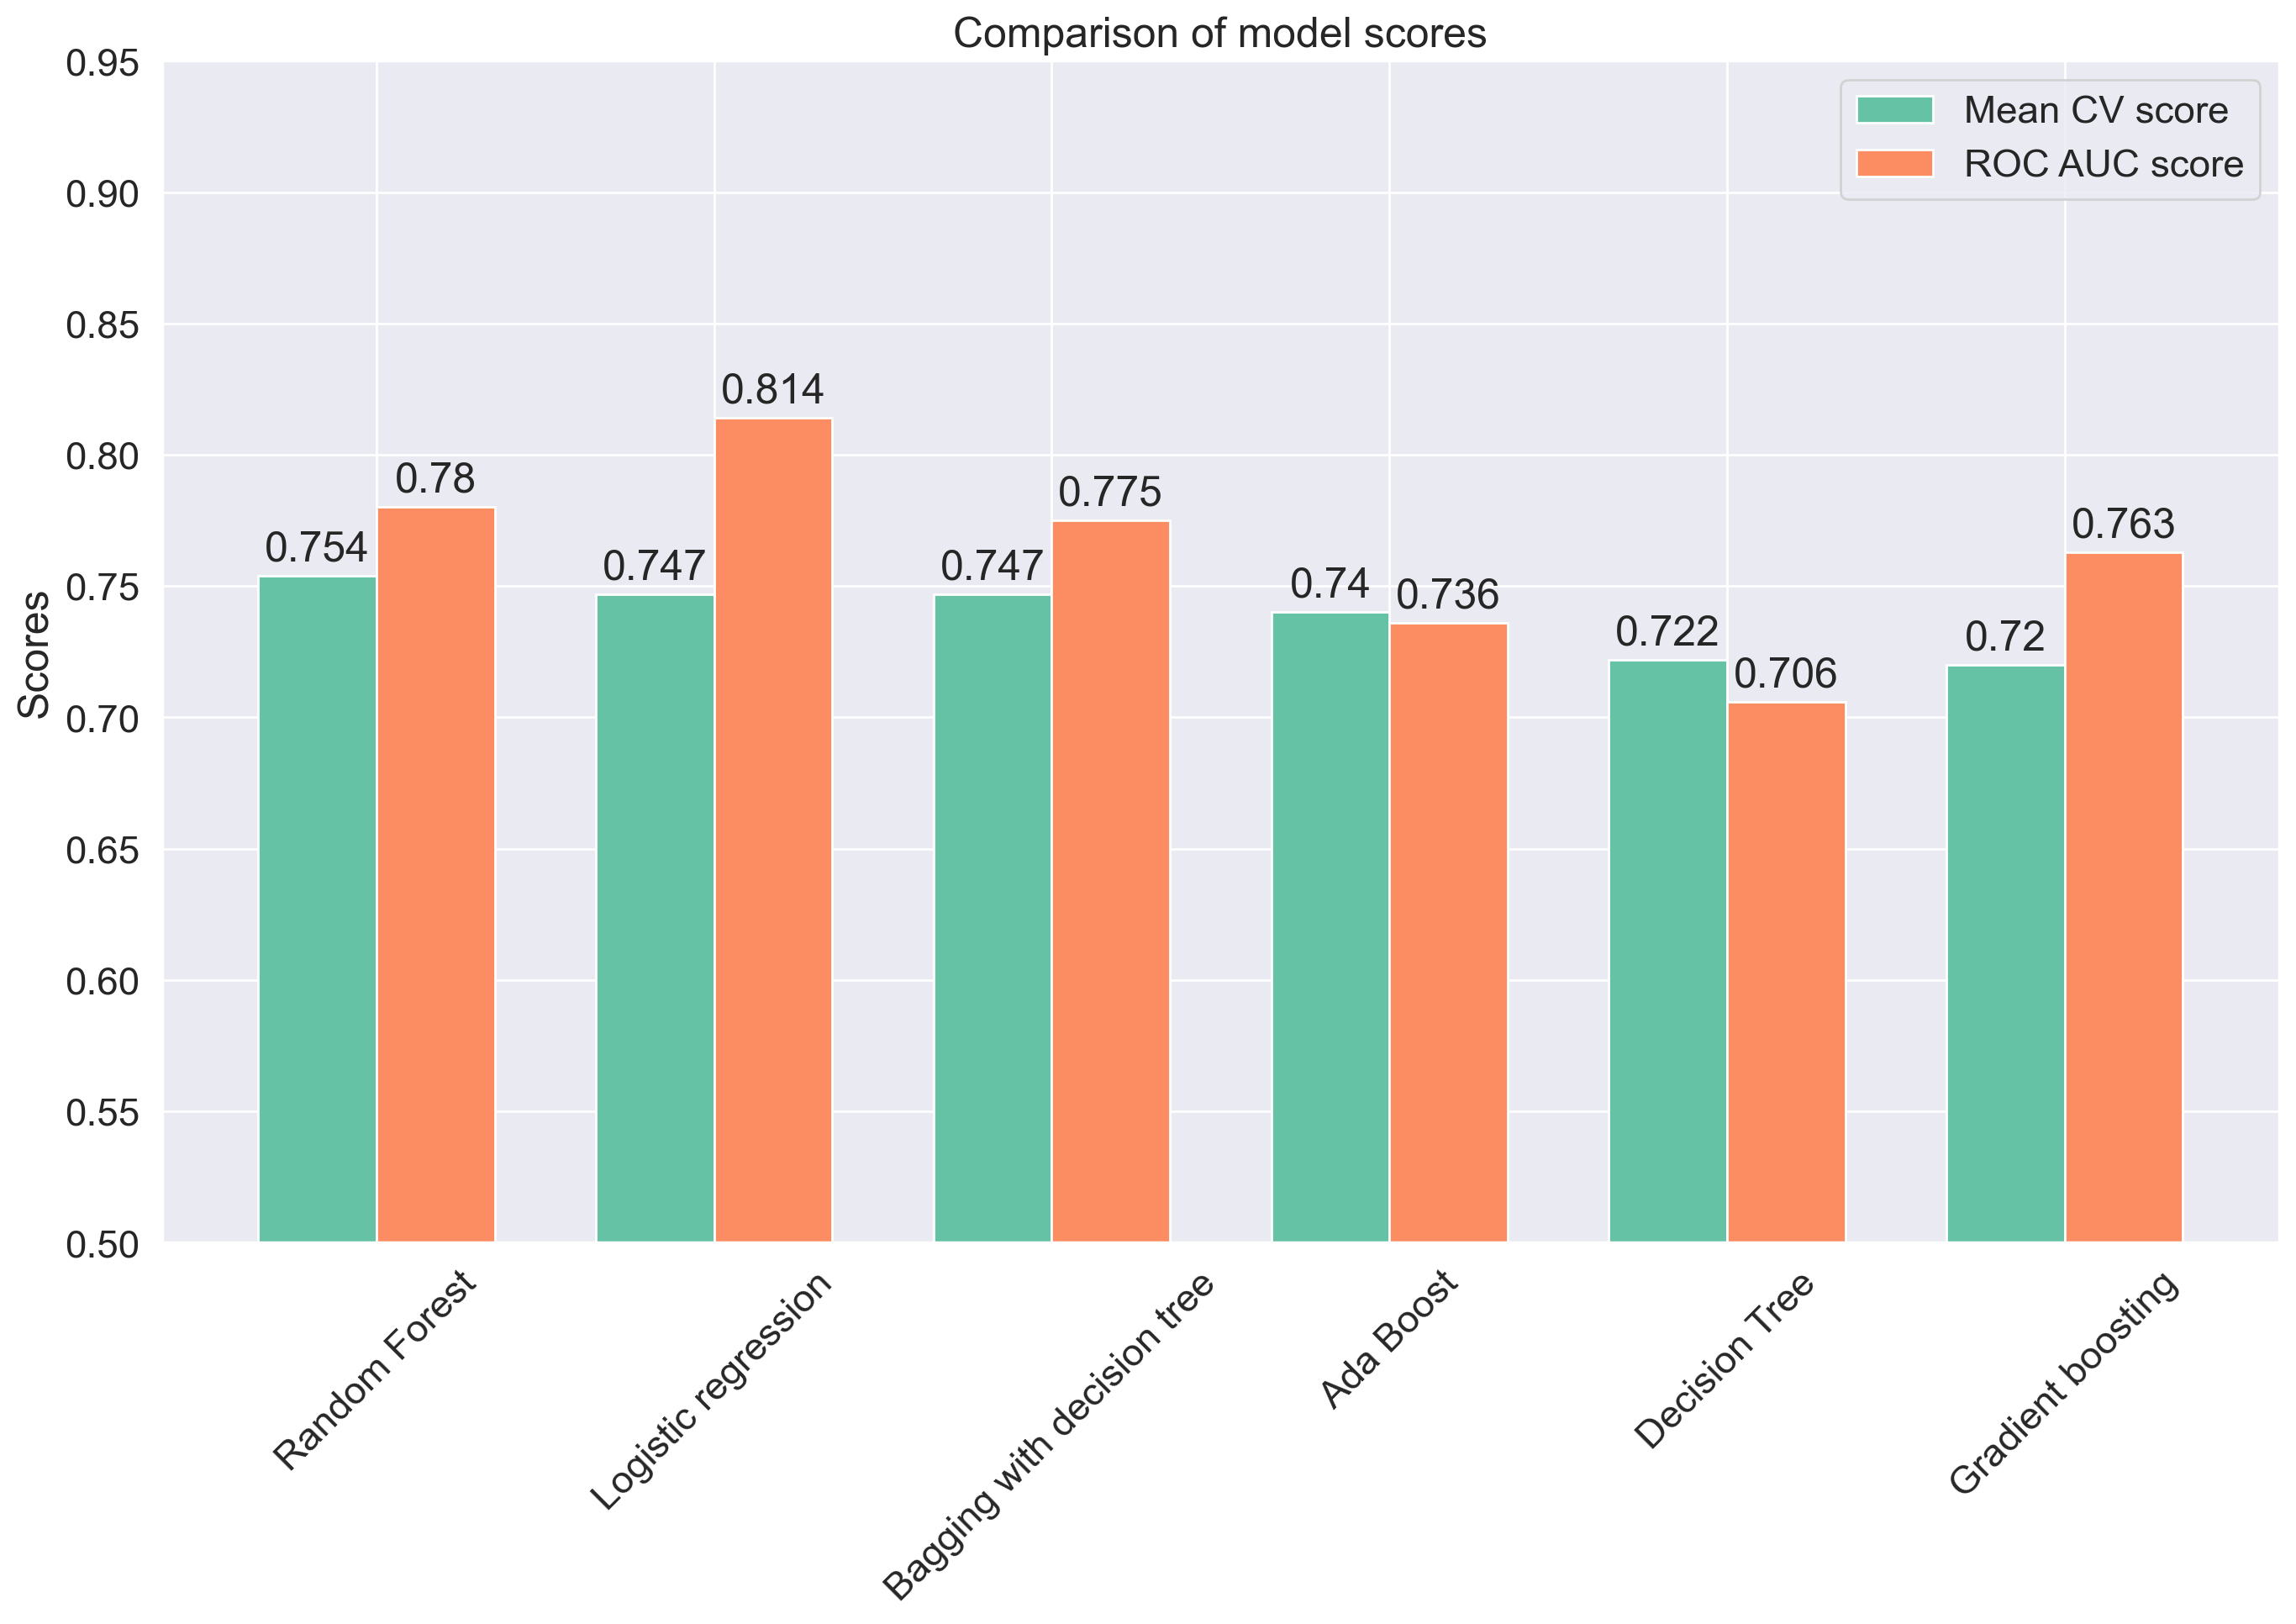

In [101]:
plot_df = scores_df.sort_values(by='mean_cv_score', ascending=False)
labels = plot_df.model_name
mean_cv_scores = round(plot_df.mean_cv_score, 3)
roc_auc_scores = round(plot_df.roc_auc_score, 3)

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(14, 10))
rects1 = ax.bar(x - width/2, mean_cv_scores, width, label='Mean CV score')
rects2 = ax.bar(x + width/2, roc_auc_scores, width, label='ROC AUC score')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Comparison of model scores')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45)
ax.set_ylim(0.5, 0.95)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

### Comparison of models
The bar chart above shows the mean cross-validated scores and the ROC AUC scores for the 6 different models, ordered by the mean cross-validated scores.

The Gradient boosting and decision tree models are the worst performing. The Decision Tree classifiers improves a lot with the use of ensemble techniques i.e. bagging or boosting.

The remaining models have similar mean cross-validated accuracy scores. The bar chart also shows the ROC AUC scores (the area under the ROC curve) which although directly related to the accuracy scores, is often preferred over the accuracy because it is automatically adjusted to the baseline and gives a robust picture of how the classifier performs at different threshold choices.

Let's look in more detail at the Random Forest which has the highest mean cross-validated accuracy score and the Logistic Regression which has the highest ROC AUC score.

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


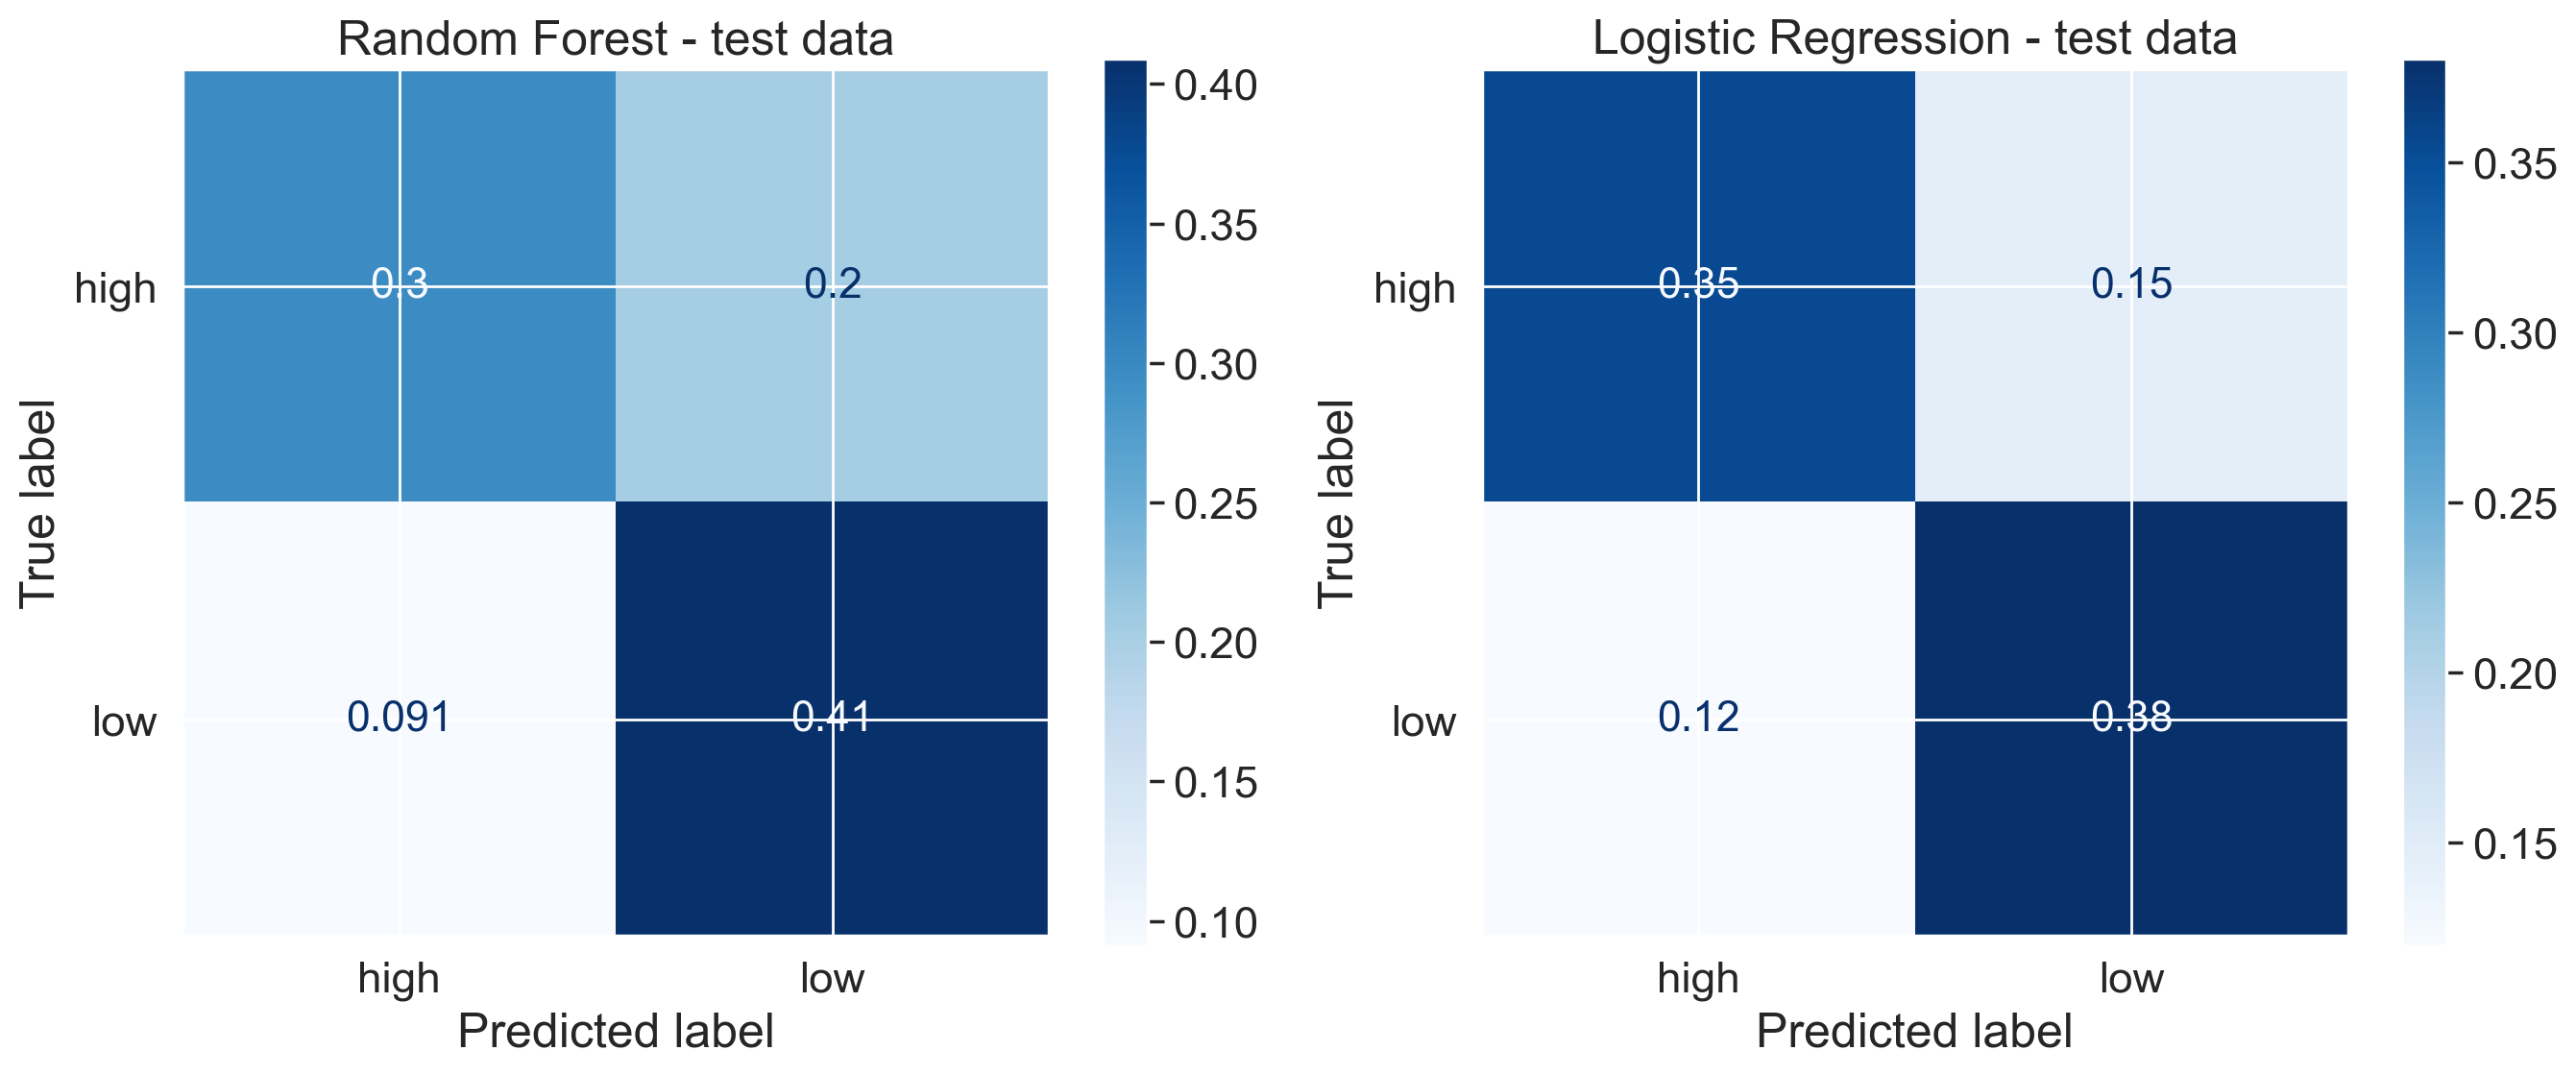

In [130]:
fig, ax = plt.subplots(ncols=2, figsize=(16,6))
plot_confusion_matrix(randFor_gs.best_estimator_, X2_test, y_test, cmap='Blues', ax=ax[0],normalize='all')
plot_confusion_matrix(logReg_gs.best_estimator_, X2_test, y_test, cmap='Blues', ax=ax[1], normalize='all')
ax[0].set_title('Random Forest - test data')
ax[1].set_title('Logistic Regression - test data')
for a in ax:
    texts = a.texts
    for text in texts:
        text.set_size(16)
plt.show()

Both achieved a test score of 0.978 which means they both predict all of the high and low salaries correctly on the full training set.

Given that we would rather tell a client incorrectly that they would get a lower salary job than tell a client incorrectly that they would get a high salary job. This means that we would like to minimize false positives for high salary i.e. when we predict high when it should be low but we do not mind so much about false negatives i.e. when we predict low when it should be high. This means we would like a lower number in the bottom left of the confusion matrix and we do not mind so much about the number in the top right. 

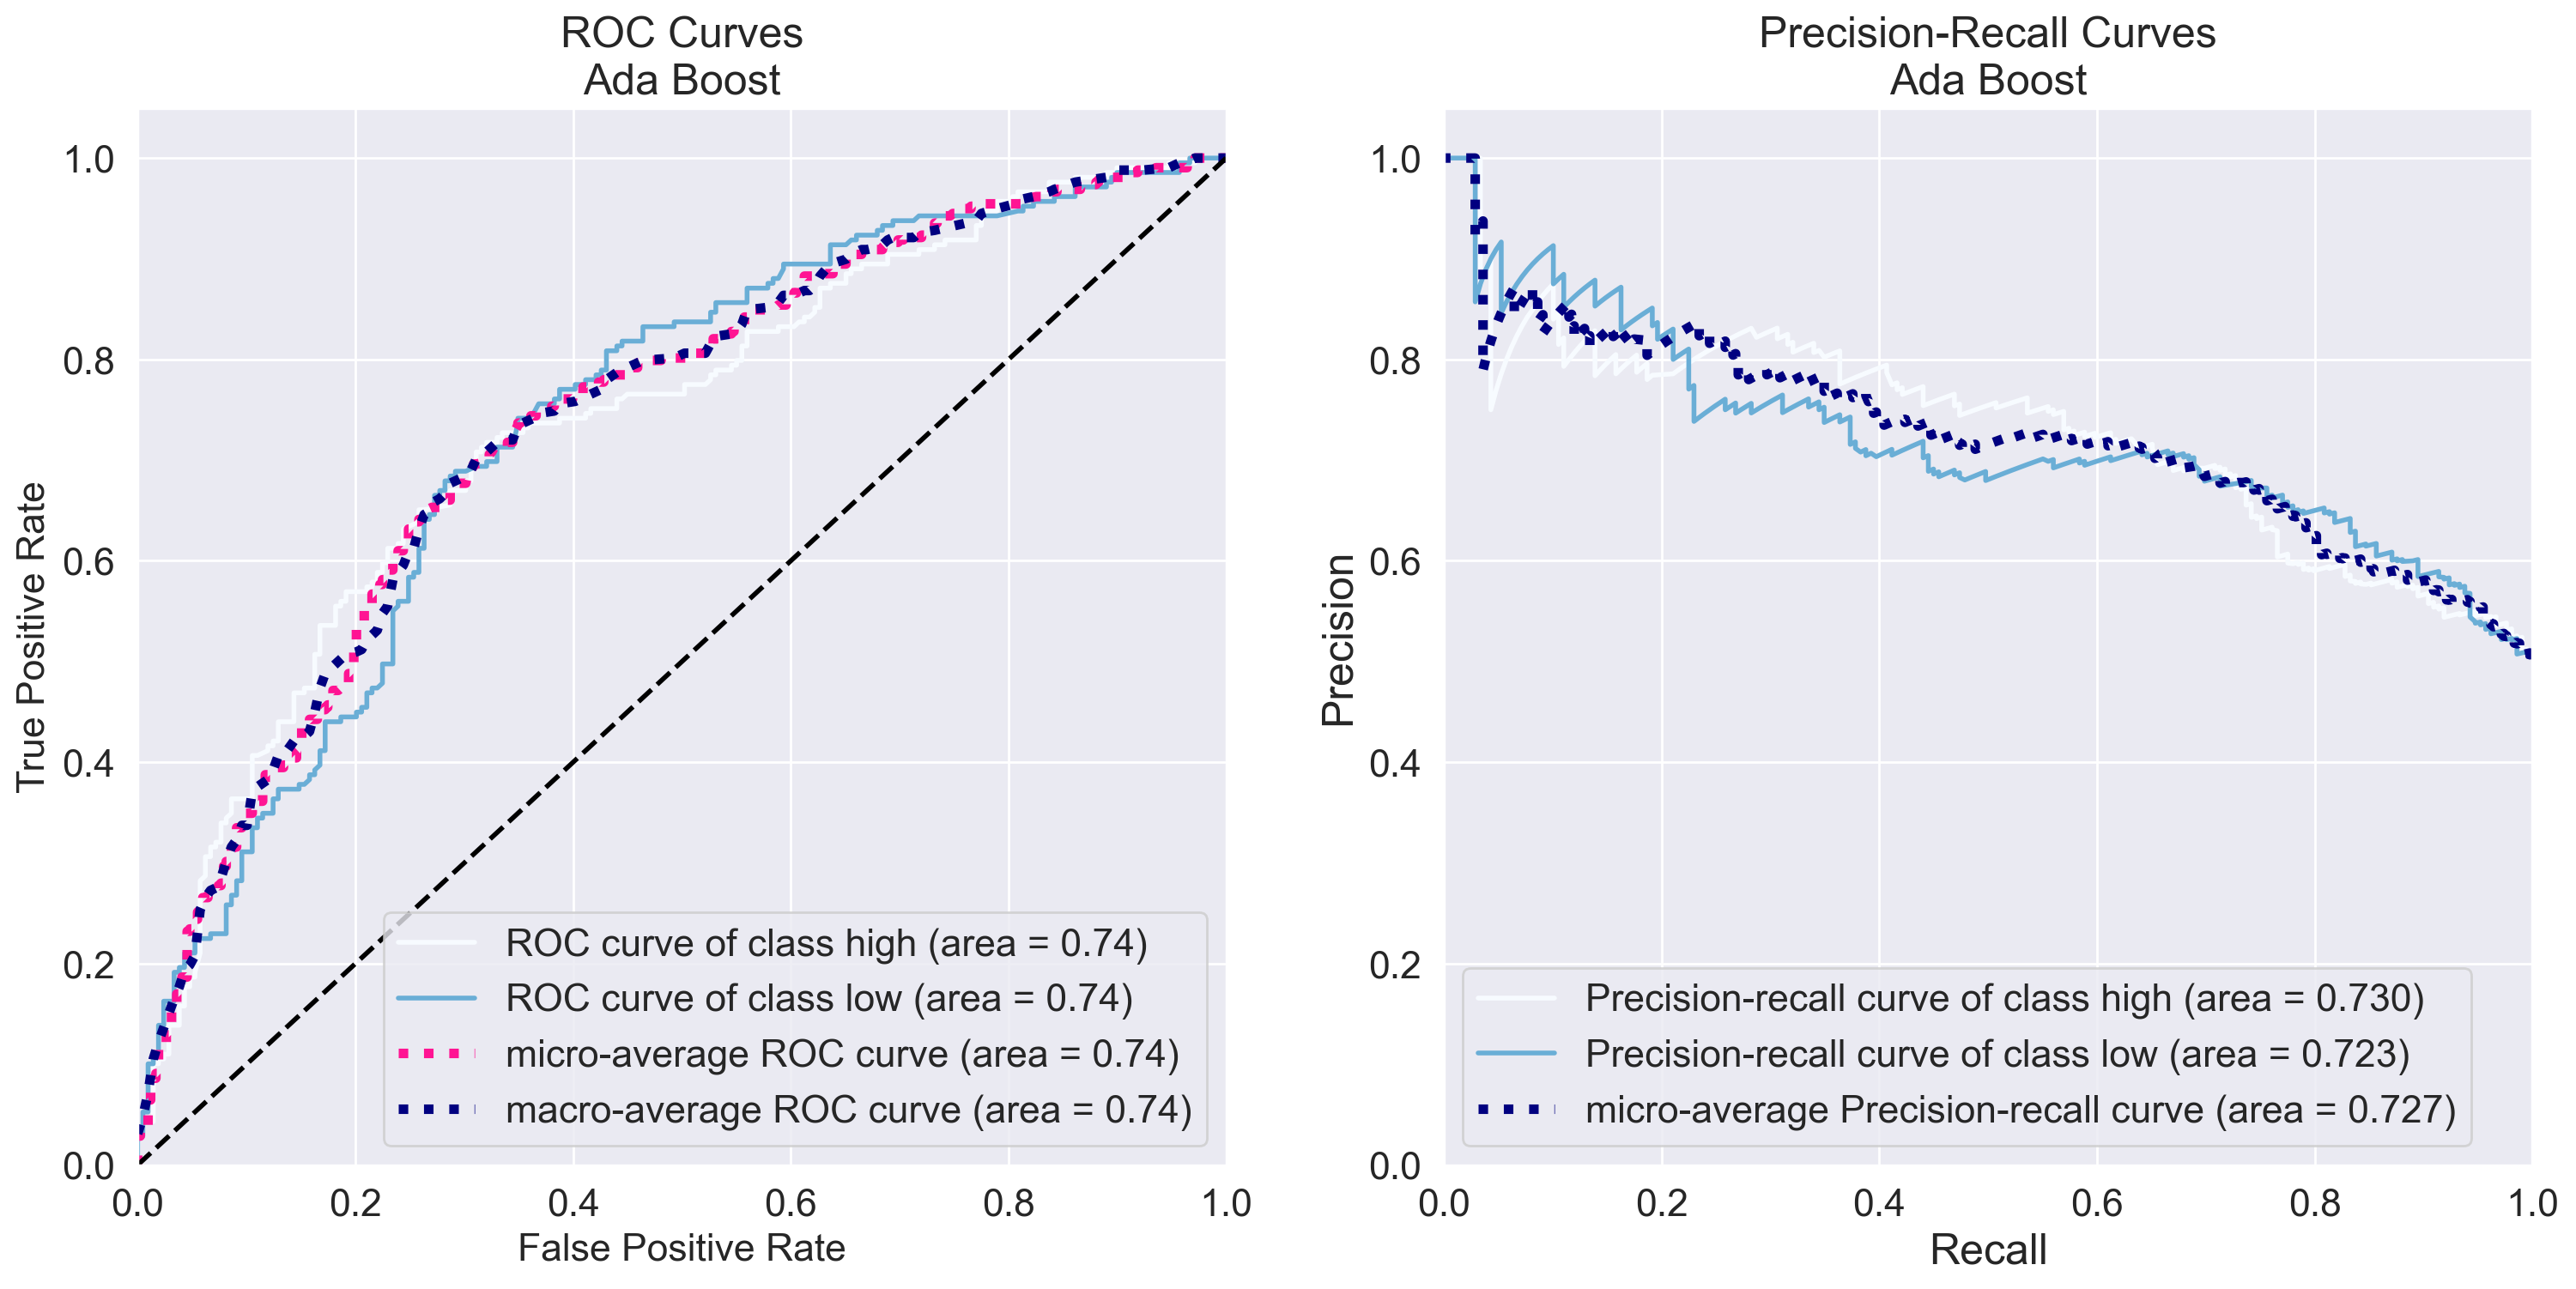

In [132]:
fig, ax = plt.subplots(ncols=2, figsize=(18, 8))
skplt.metrics.plot_roc(y_test, adaBoost_best.predict_proba(X2_test), plot_micro=True, plot_macro=True, 
                       title_fontsize=20, text_fontsize=16, cmap='Blues', ax=ax[0])
skplt.metrics.plot_precision_recall(y_test, adaBoost_best.predict_proba(X2_test), plot_micro=True, 
                       title_fontsize=20, text_fontsize=16, cmap='Blues', ax=ax[1])
ax[0].set_title('ROC Curves\nAda Boost')
ax[1].set_title('Precision-Recall Curves\nAda Boost')
plt.show()

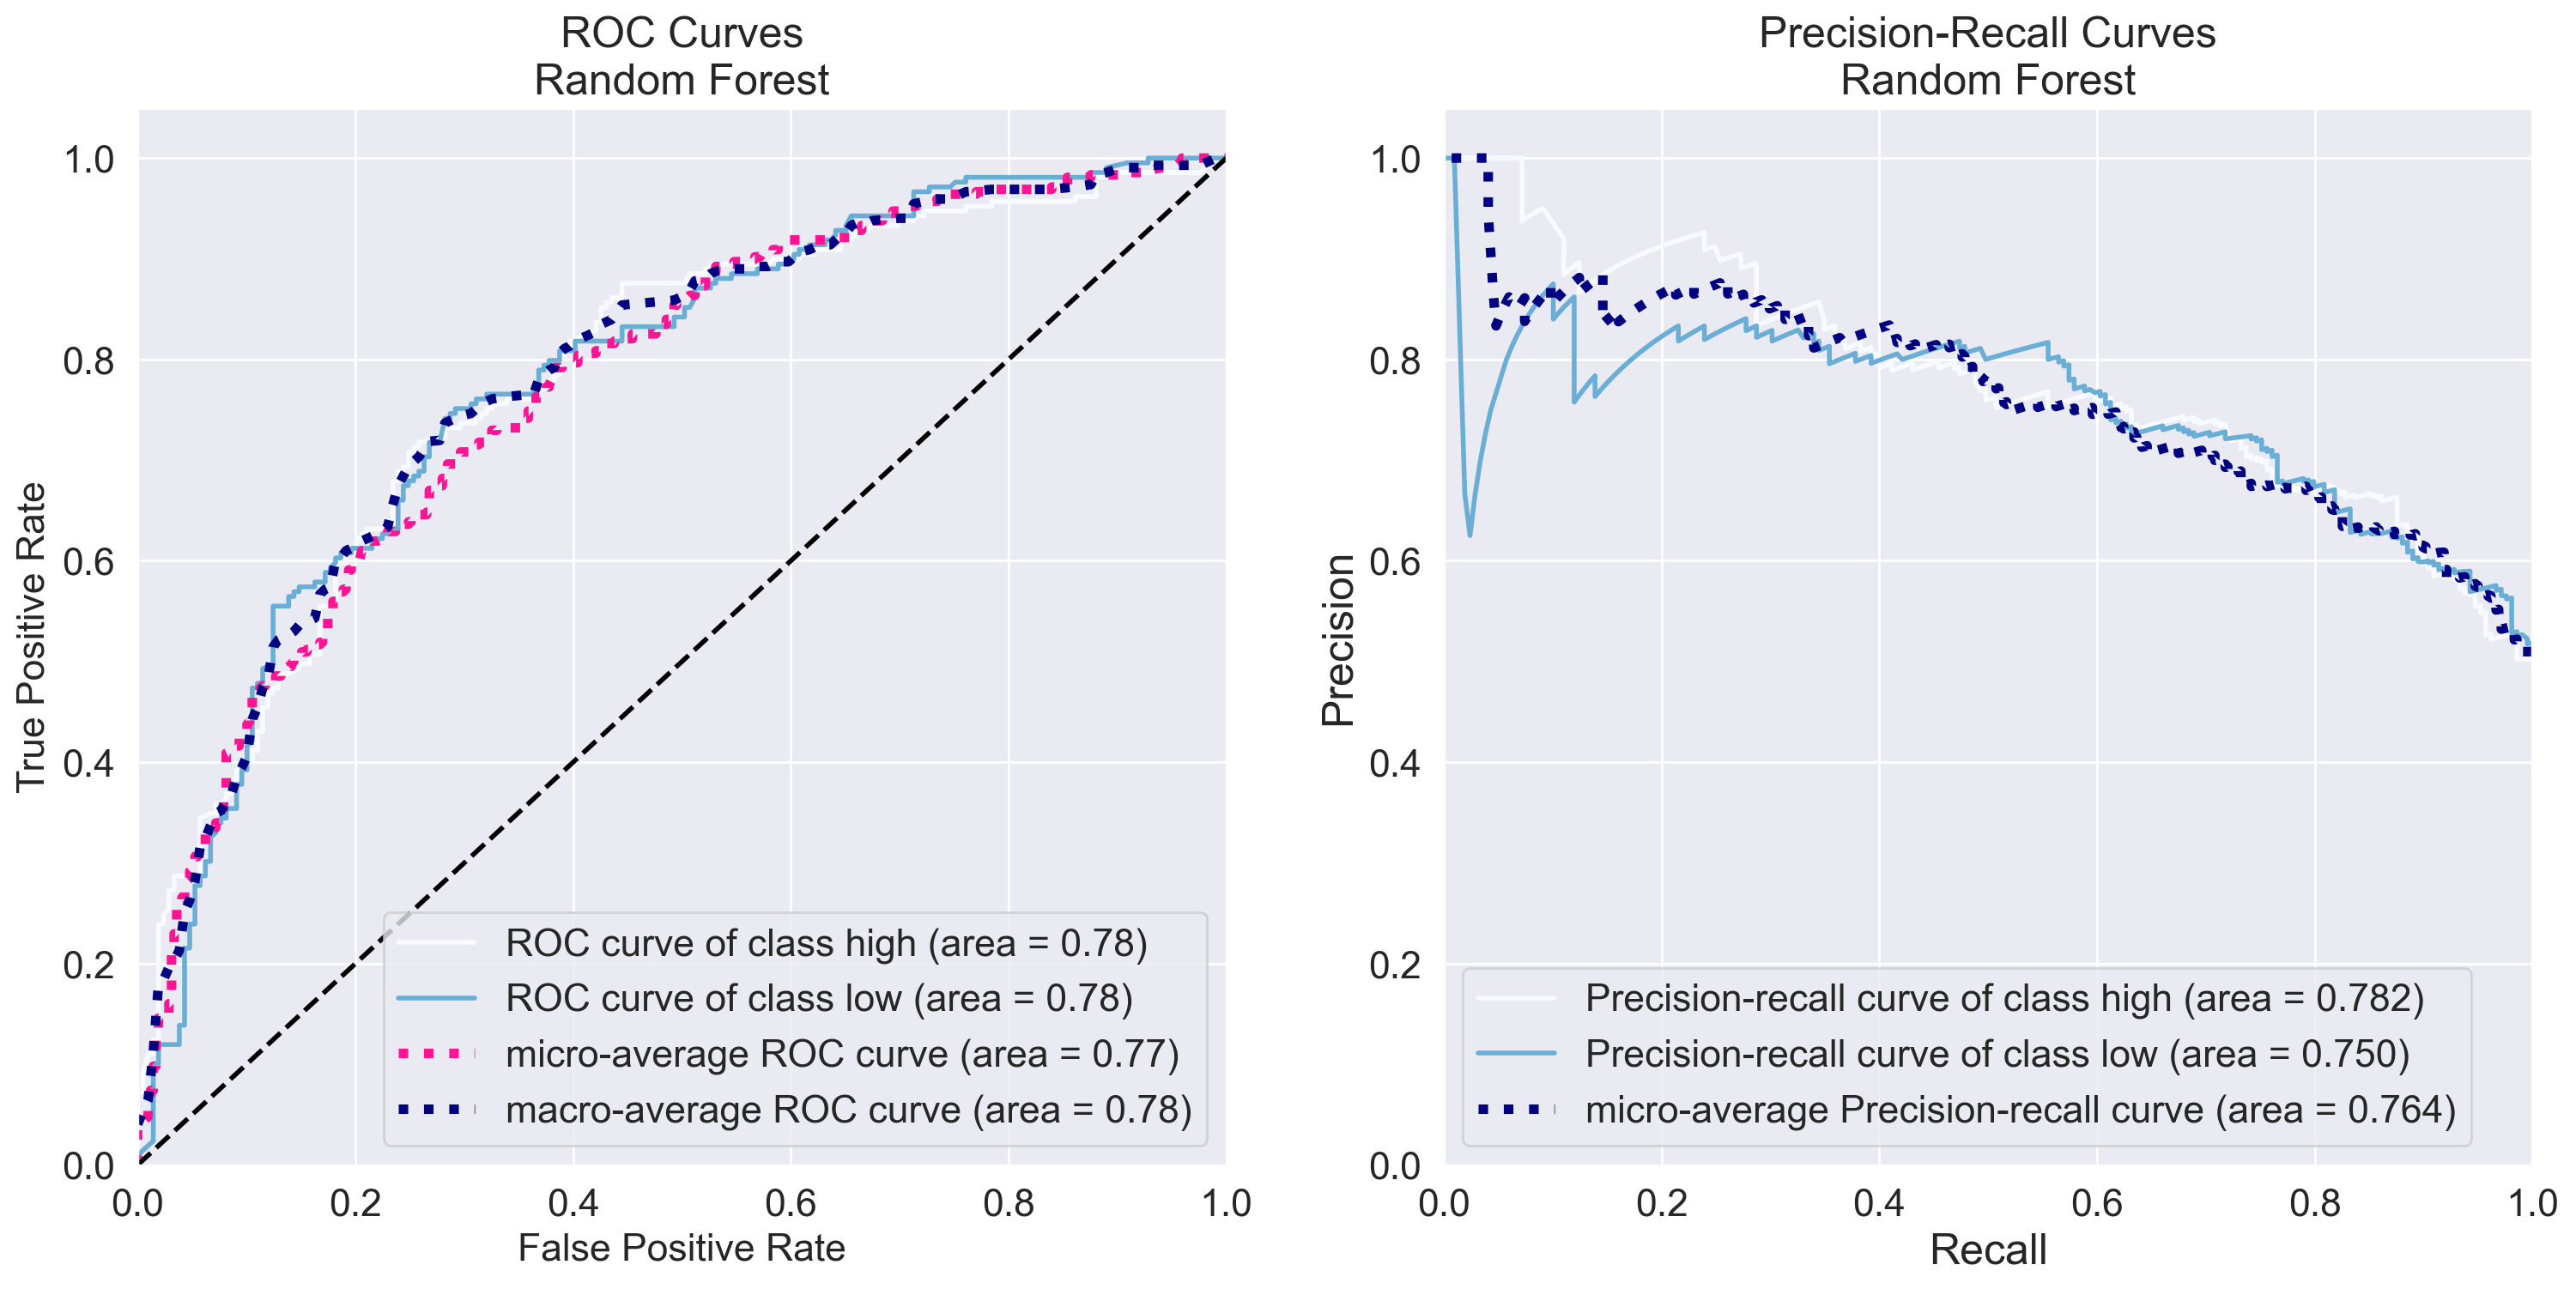

In [133]:
fig, ax = plt.subplots(ncols=2, figsize=(18, 8))
skplt.metrics.plot_roc(y_test, randFor_best.predict_proba(X2_test), plot_micro=True, plot_macro=True, 
                       title_fontsize=20, text_fontsize=16, cmap='Blues', ax=ax[0])
skplt.metrics.plot_precision_recall(y_test, randFor_best.predict_proba(X2_test), plot_micro=True, 
                       title_fontsize=20, text_fontsize=16, cmap='Blues', ax=ax[1])
ax[0].set_title('ROC Curves\nRandom Forest')
ax[1].set_title('Precision-Recall Curves\nRandom Forest')
plt.show()

In [104]:
# precision and recall scores for the 8 classifiers, ordered by precision
scores_df[['model_name','precision_high', 'recall_high']].sort_values('precision_high', ascending=False)

model_name  precision_high  recall_high
1               Random Forest        0.763636     0.602871
0         Logistic regression        0.747475     0.708134
3  Bagging with decision tree        0.743017     0.636364
5           Gradient boosting        0.735135     0.650718
2               Decision Tree        0.734463     0.622010
4                   Ada Boost        0.714286     0.645933

As we would prefer to maximize the precision score over the recall score for a high salary. On this basis, the Random Forest appears to be a better model.

Given the Random Forest is the best classifier for this problem on several scores seen above. Look at feature importance of the model.

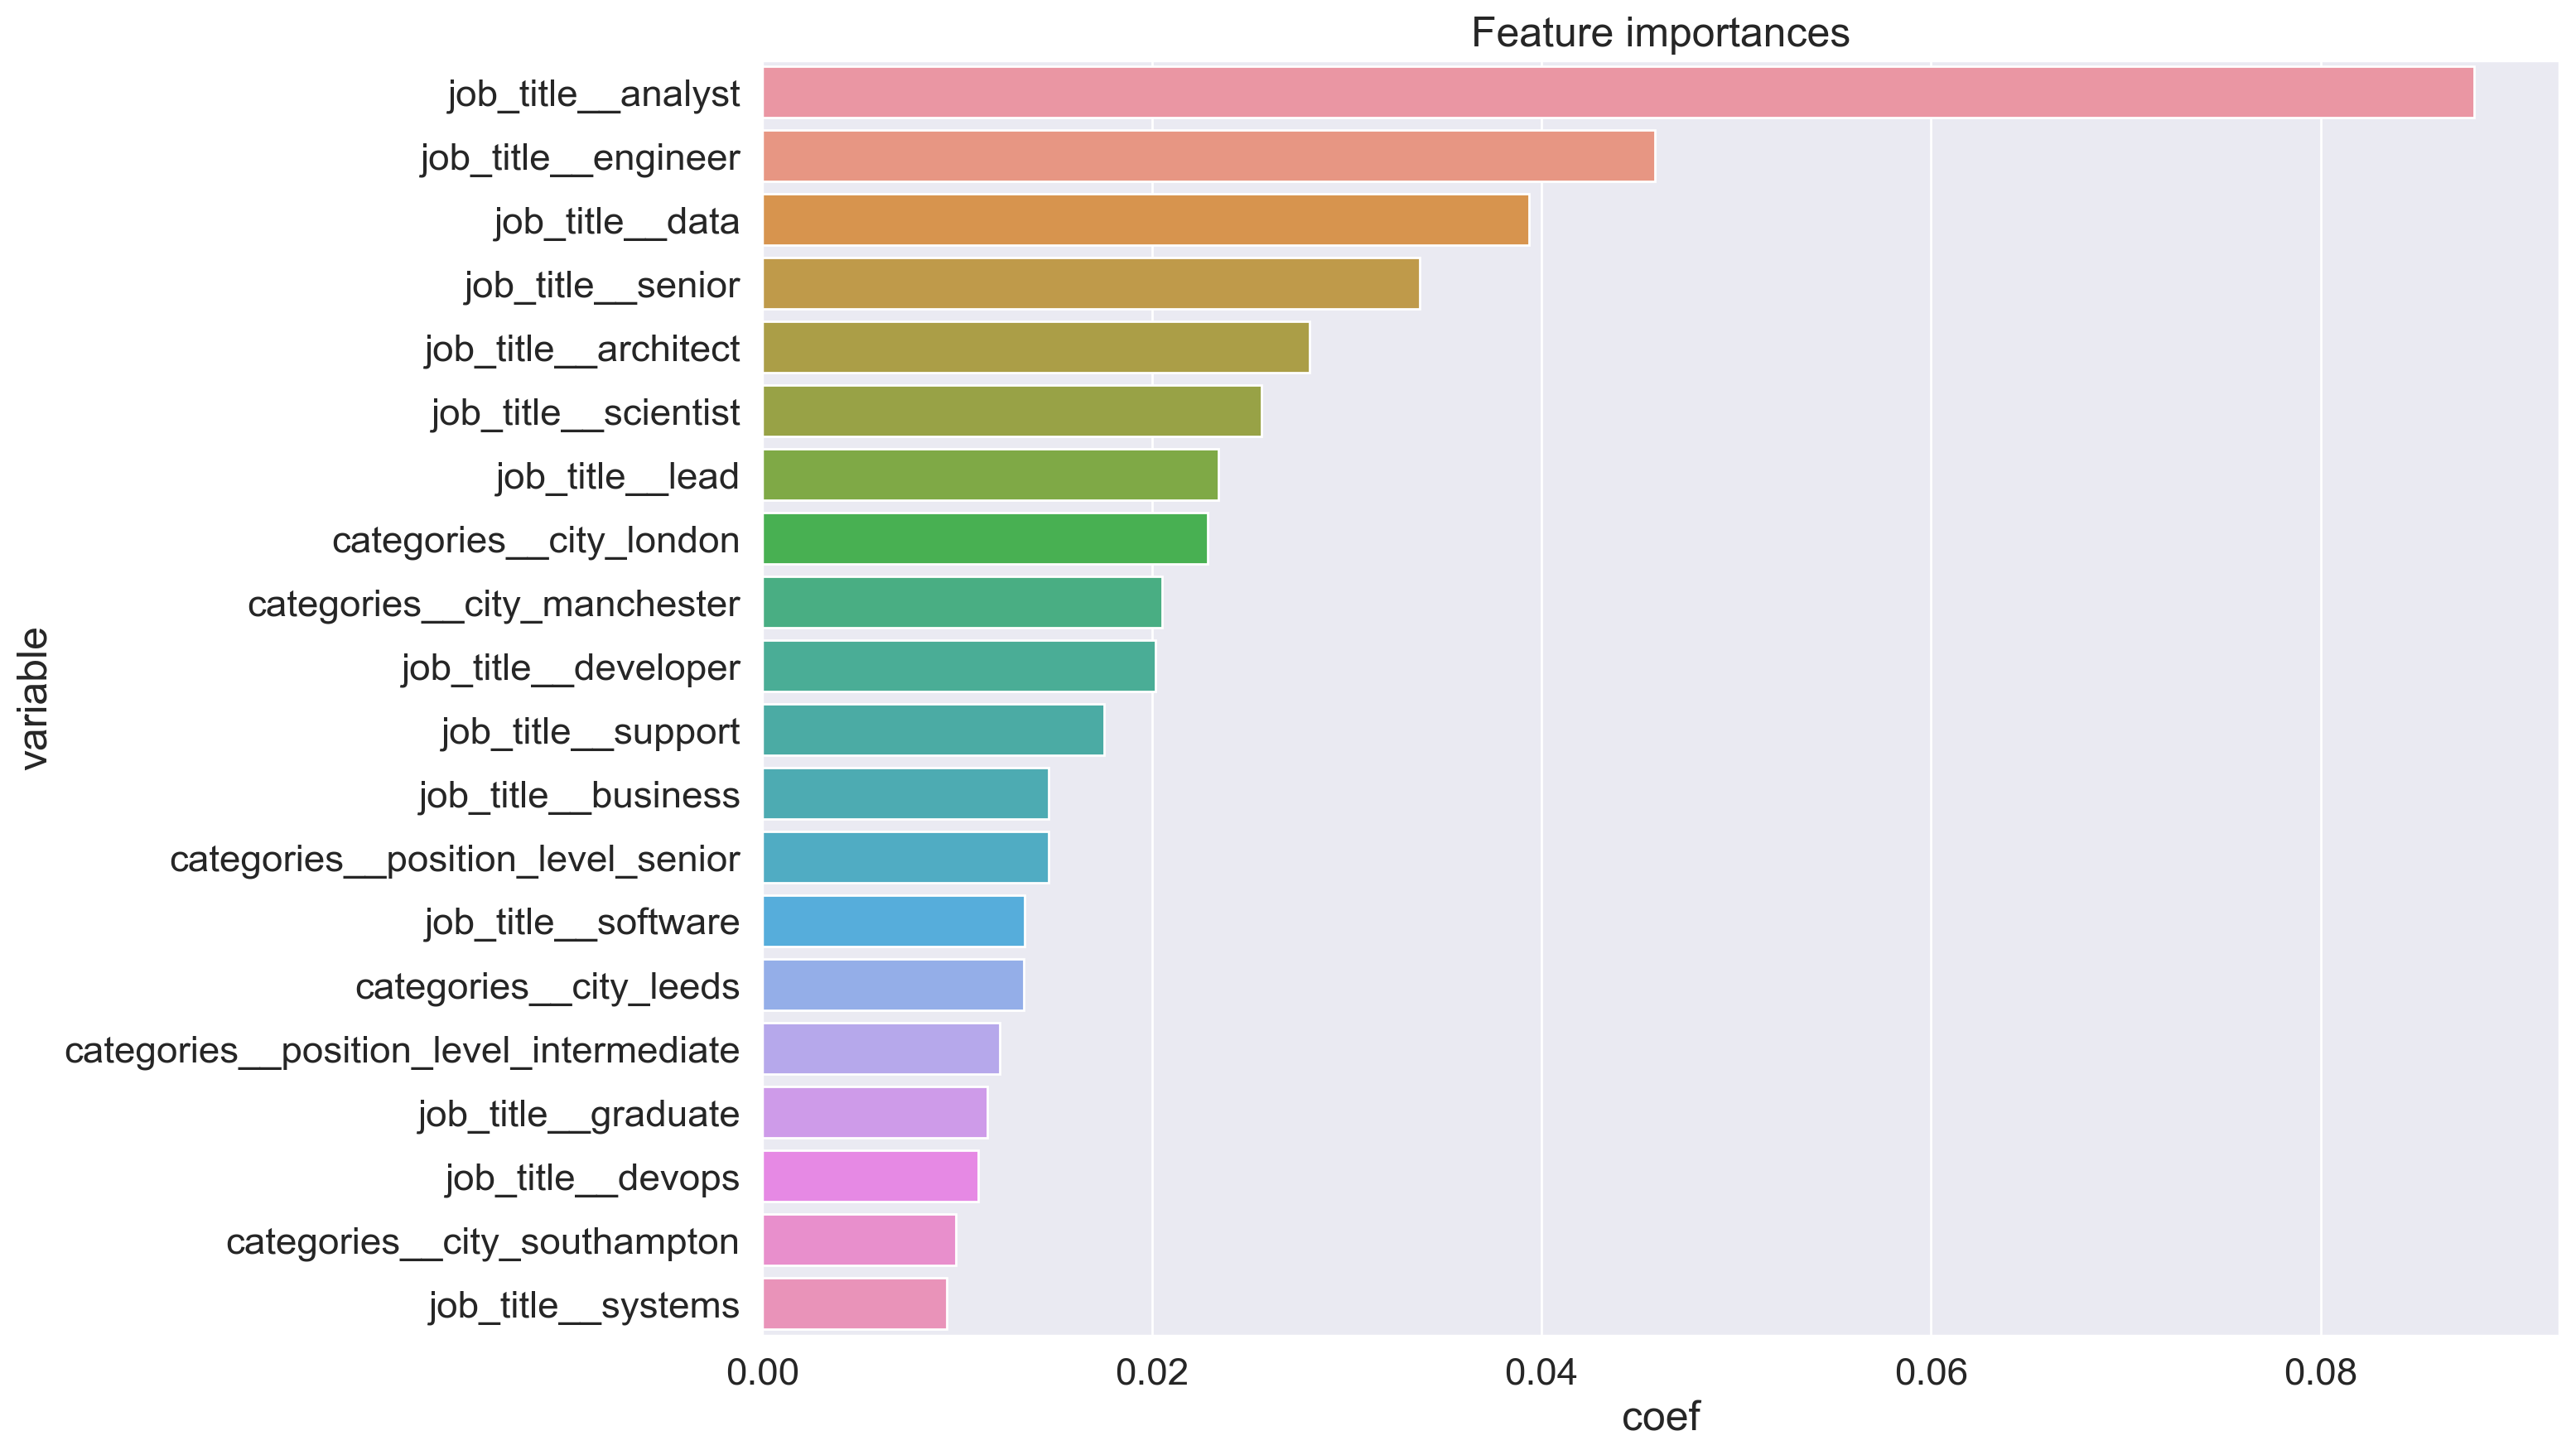

In [110]:
# plot feature importances for random forest
model = randFor_gs.best_estimator_
df_coef = pd.DataFrame({'variable': col_trans_2.get_feature_names_out(), 
                        'coef': model.feature_importances_})

fig5, ax = plt.subplots(figsize=(14,10))
sns.barplot(data=df_coef.sort_values('coef', ascending=False).head(20), x='coef', y='variable')
plt.title('Feature importances')
plt.show()
#pickle.dump(fig5, open('fig5.png', 'wb'))
fig5.savefig("fig5.png")

The bar chart above shows the top 20 feature importances for the Random Forest model. Words from the job title make up 14 out of the 20 most important features from the model for example: analyst, engineer, data, senior, architect. The region London is the 8th most important feature - this makes sense given that salaries tend to be higher in London.

In [107]:
false_positives = []
for thresh in np.arange(1, 100)/100.:
    labeled_1 = np.array(['high' if x >= thresh else 'low' for x in randFor_best.predict_proba(X2_test)[:, 0]])
    fp = np.mean((y_test == 'low') & (labeled_1 == 'high'))
    false_positives.append((thresh, fp))
    #print('Threshold:', thresh, 'false positives:', fn)
false_positives = np.array(false_positives)

In [108]:
accuracies = []
for thresh in np.arange(1, 100)/100.:
    labeled_1 = np.array(['high' if x >= thresh else 'low' for x in randFor_best.predict_proba(X2_test)[:, 0]])
    acc = np.mean(y_test==labeled_1)
    accuracies.append((thresh, acc))
    #print('Threshold:', thresh, 'Correct predictions:', acc)
accuracies = np.array(accuracies)

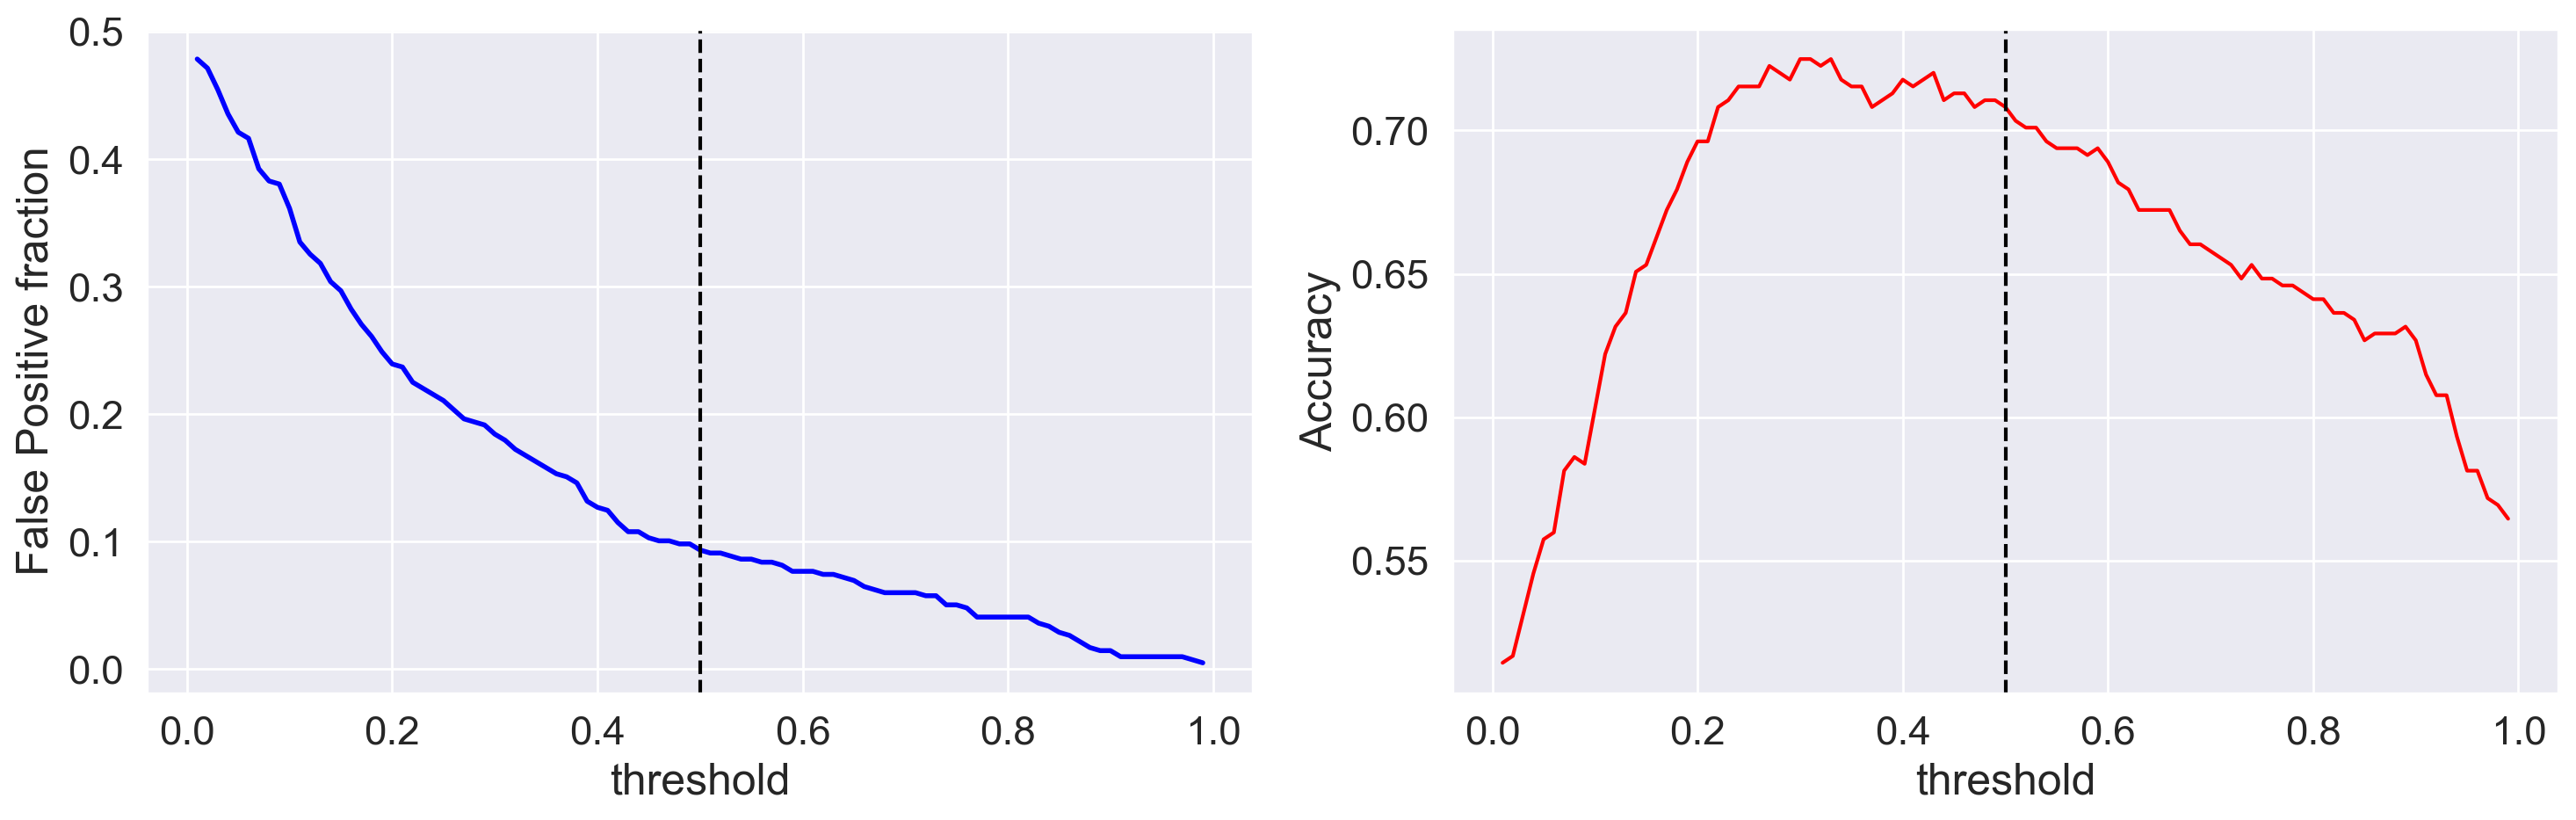

In [109]:
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(15,5))
sns.lineplot(x= false_positives[:, 0], y=false_positives[:, 1],color='b', lw=2, ax=ax[0])
sns.lineplot(x = accuracies.T[0],y = accuracies.T[1], color='r',ax=ax[1])
#sns.lineplot(x= [0.5,0.5],y = [0,0.5], color='black', ax=ax[0])
ax[0].axvline(0.5, ls='--',color='black')
ax[1].axvline(0.5, ls='--',color='black')

ax[0].set_ylabel('False Positive fraction')
ax[1].set_ylabel('Accuracy')
ax[0].set_xlabel('threshold')
ax[1].set_xlabel('threshold')

fig.tight_layout()

plt.show();

The precision-recall curves show precision versus recall for different class assignment threshold values. If we wanted to increase precision, we could increase the class assignment threshold and the precision-recall curve would show us what the recall we could then reach at most would be.

To further reduce the number of False positives we can to increase the threshold of probabilty for the 'high' class. By increasing threshold we also affect :
- Recall would decrease - increasing overall FN's (see precision-recall curve)
- Overall accuracy would decrease - reaffirmed by our ROC curve where True positives decrease with decreasing False positives (see accuracy vs threshold graph in red)


The precision-recall curves and ROC curves have been plotted above for both Ada Boost and Random Forest. The area under the curves in both charts is higher for Random Forest.

**The overall tradeoff would be to sacrifice False negatives for False positives (increase FN) and sacrifice the accuracy of predicting 'high' salaries.**

## Executive Summary 
Our aim was to predict whether one was to receive a 'high' or 'low' salary based given a few attributes off a job posting. Prior to modelling we calcualted our baseline accuracy and arrived at 50%. 

We modelled using title of job, location of job, whether you were paid by hour, day, week, month or year, position level along with other variables. Various models were trained and all were evaluated on unseen data to validate corresponding performance. The best model was chosen based on a metric that explained the models' variance, where the model that could explain the largest variance was chosen. Out of all our models, our best model was found to have an accuracy score of around 75%.

The 5 most important variables which dictated the salary outcome came from key words in the jobtitle - Analyst, Engineer, Data, Senior and Scientist, this can be seen in above figure. One could expect this as job title describes the job in a nutshell. Key words like Senior and scientist were key differentiators in explaining whether a salary was going to be high.

Although this model achieved the best accuracy score we also wanted to evaluate the number of times our model predicted a 'high' salary when in actual fact it should have predicted 'low' salary outcome. This is known as our false positive rate whereas the opposite is given by false negative rate. The results for false positives and false negatives on test data was 10% and 15% respectively.

We wanted to optimise the model in such a way to reduce the occurance of a false positive. The main reason for this is due to the fact that we want to limit the dissapointment factor when telling someone they should be receiving a 'high' salary from a given job when in fact they will be receiving a 'low' salary job. A way in which this could be optimised was to increase the threshold for predicting a 'high' salary, the result of doing so would increase the occurence of false negatives. in other words increase the occurence of telling someone they will receive a 'low' salary but in actual fact they will be surprised with a 'high' salary job. The overall tradeoff of such optimisation is to also decrease the accuracy of 'high' salary outcome predictions. This is displayed in the red curve graph of accuracy vs threshold - as threshold increases accuracy decreases.

Overall the model performance serves well and can be used to predict salary outcomes accurately 75% of cases. However this needs to be carried out with caution as the model has only been tested on a small amount of data. Many improvements could be achieved by further featuring of attributes as well as inclusion of more variables. If more time allowed, I would include Job summary as another variable. I presume this would add value to model performance as the jobtitle key words dominated in terms of importance and job summary would have more detailed keywords to choose from. Further parameter tuning could be carried out to increase accuarcy incrementally. The data pool could be increased to include far more data, allowing a wider range of data to be trained and tested on, therefore reducing model error and accounting for more variance. Finally the raw data could be investigated further to identify outliers and treat them accordingly. 